# **Basic Import**

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import shapiro, probplot
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm, trange
from scipy.optimize import minimize

In [4]:
def calculate_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(lambda x: np.log(x / x.shift(1)))

In [5]:
with open("Data/N_TX_Components.csv", "r", encoding="big5", errors="replace") as f:
    TX_Closing = pd.read_csv(f, index_col=['股票代號'], low_memory=False)
TX_Closing =  TX_Closing[ TX_Closing.columns[4:]]
TX_Closing.drop(["股票名稱"], inplace=True)
TX_Closing.index = pd.to_datetime([re.search(r'\d+', i).group() for i in TX_Closing.index])
TX_Closing = TX_Closing.astype(float)

with open("Data/N_TX_Weights.csv", "r", encoding="big5", errors="replace") as f:
    TX_Weights = pd.read_csv(f, index_col=['股票代號'], low_memory=False)
TX_Weights =  TX_Weights[ TX_Weights.columns[4:]]
TX_Weights.drop(["股票名稱"], inplace=True)
TX_Weights.index = pd.to_datetime([re.search(r'\d+', i).group() for i in TX_Weights.index])
TX_Weights = TX_Weights.astype(float)
TX_Weights = TX_Weights.div(TX_Weights.sum(axis=1), axis=0)[1:]

In [6]:
with open("Data/E_library.csv", "r", encoding="big5", errors="replace") as f:
    E_list= pd.read_csv(f, index_col=['股票代號'], low_memory=False)
    E_list = E_list.astype(str)

with open("Data/F_library.csv", "r", encoding="big5", errors="replace") as f:
    F_list= pd.read_csv(f, index_col=['股票代號'], low_memory=False)
    F_list = F_list.astype(str)

E_list = list(map(lambda x: str(x), E_list.index.tolist()))
F_list = list(map(lambda x: str(x), F_list.index.tolist()))
E_list = [x for x in TX_Weights.columns.tolist() if x in E_list]
F_list = [x for x in TX_Weights.columns.tolist() if x in F_list]
NEF_list = [x for x in TX_Weights.columns.tolist() if x not in E_list and x not in F_list ]

In [7]:
with open("Data/N_TX_Components.csv", "r", encoding="big5", errors="replace") as f:
    name_l = pd.read_csv(f, low_memory=False)[:1]
name_l = name_l[name_l.columns[4:]]
name_l.set_index('股票代號', inplace=True)
name_l = name_l.T

# **Parameters Setup**

In [8]:
num_of_features = [100, 300, 500, 700, 900, 963]
num_of_days = [100, 200, 300, 400, 500]
testing_days = 50

# **Choose by Weights**

## *Method 1: Linear Regression*

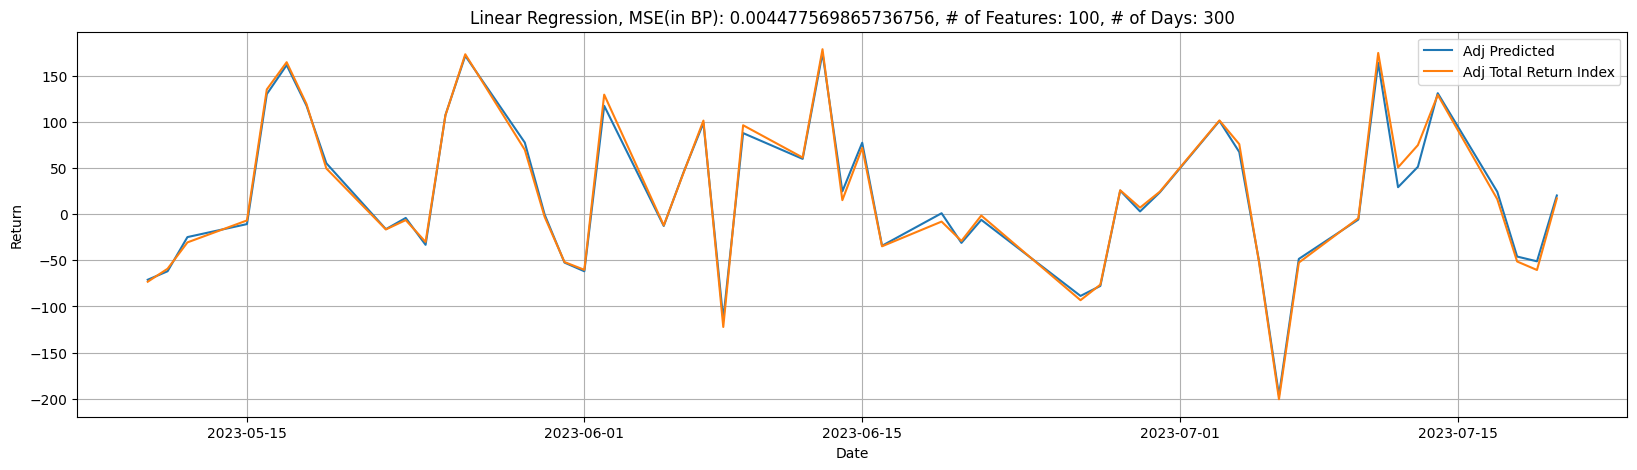

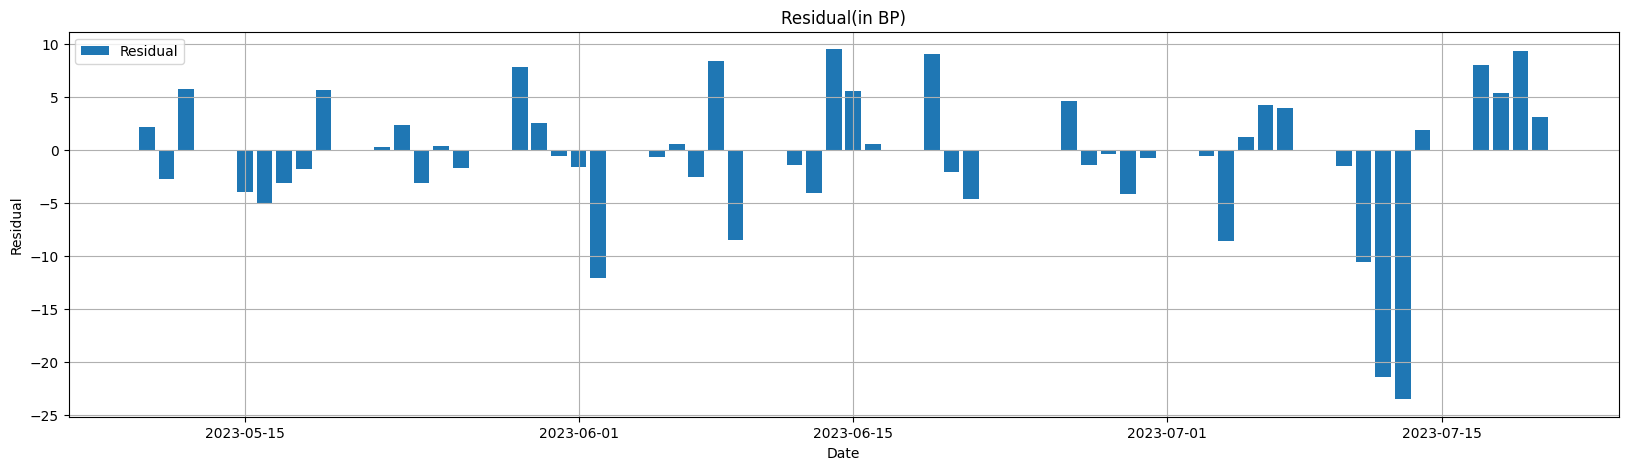

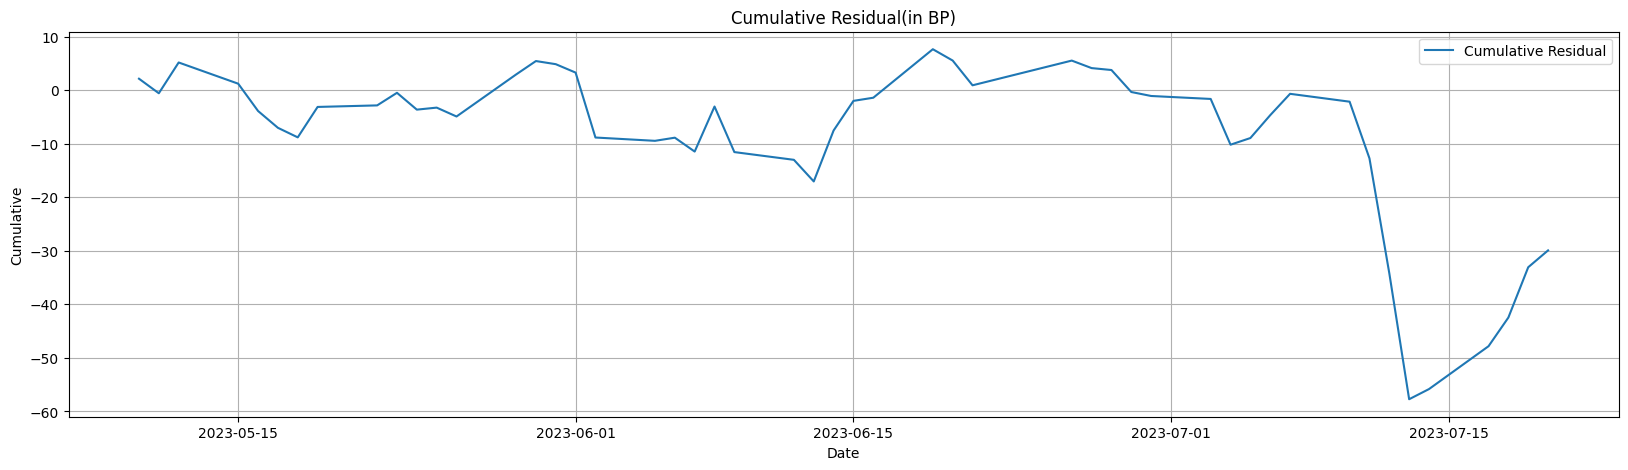

Weights
2330  0.337531
2317  0.038400
2454  0.033472
2412  0.025185
2308  0.018970
...        ...
3023  0.004993
3653  0.000979
2633 -0.003673
2049  0.003948
2383  0.004507

[98 rows x 1 columns]

0.0023528964868679506


In [9]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = LinearRegression(fit_intercept = False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Linear Regression MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_pred), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Linear Regression, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day+1:].sum(axis = 1)[-1], index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## *Method 2: Lasso*

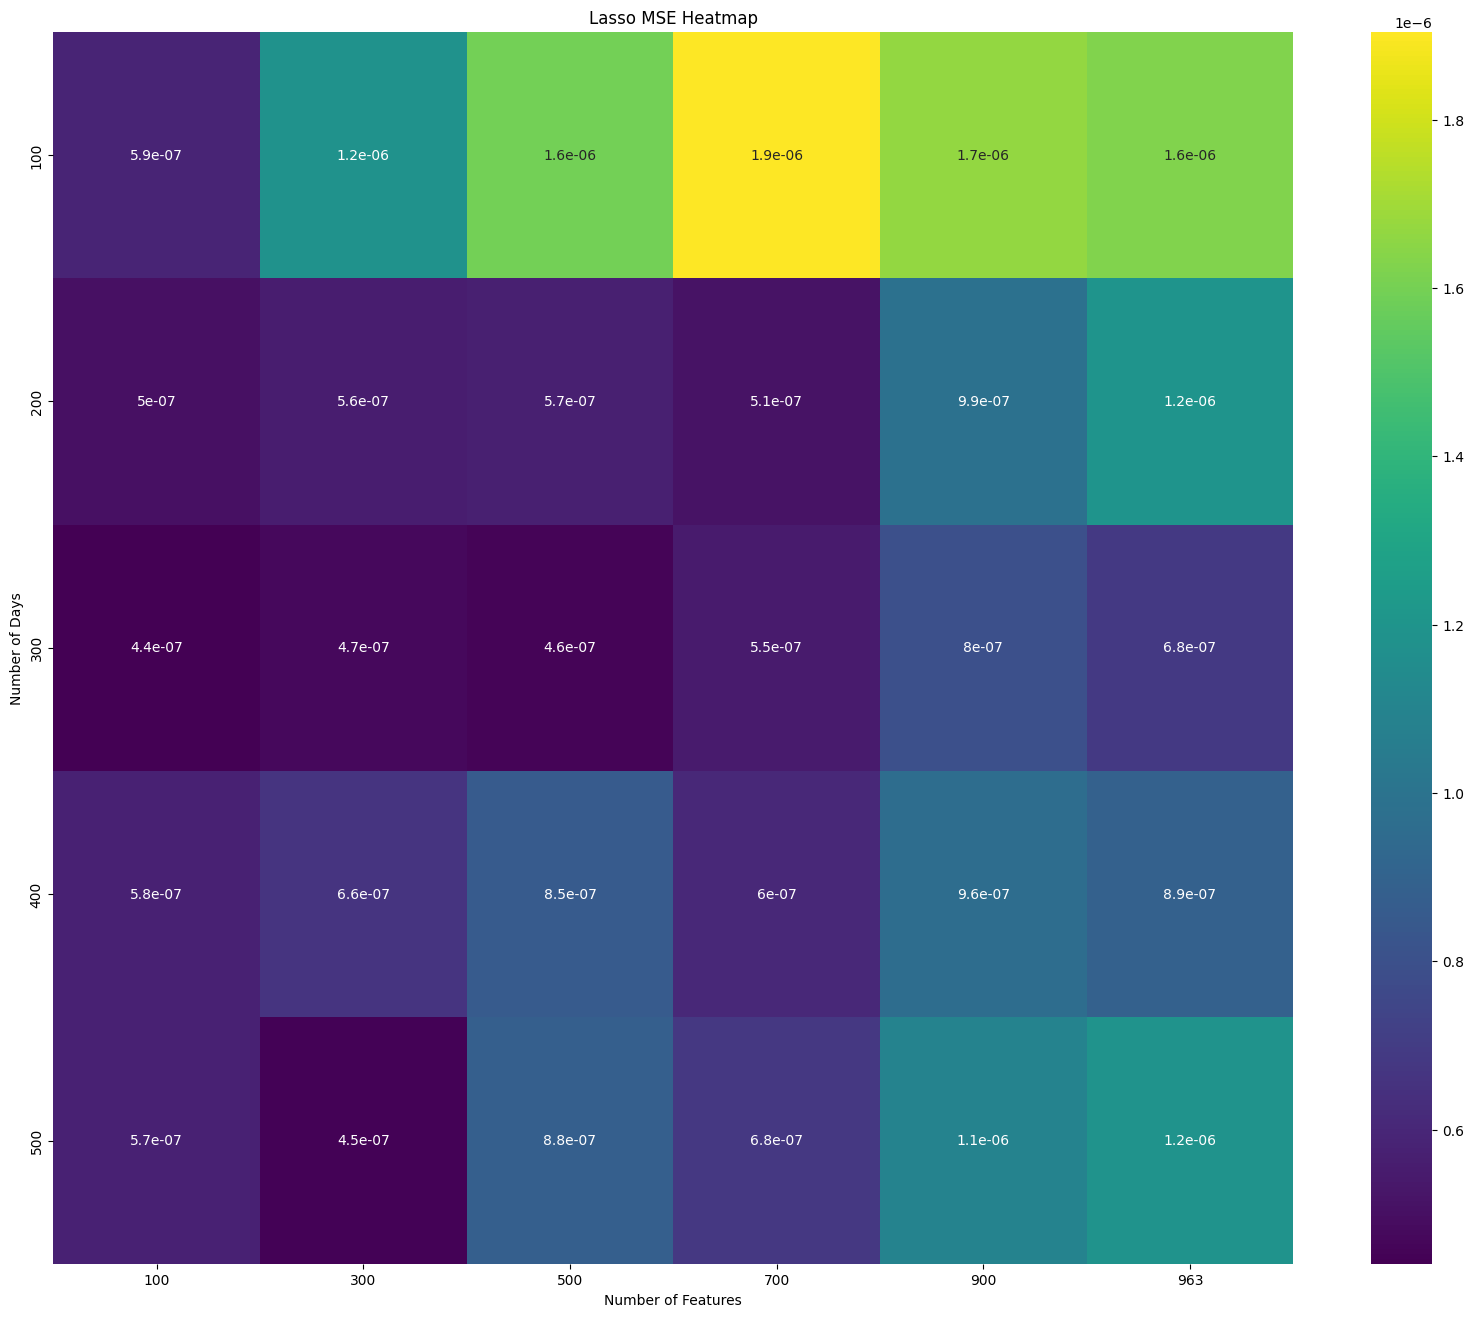

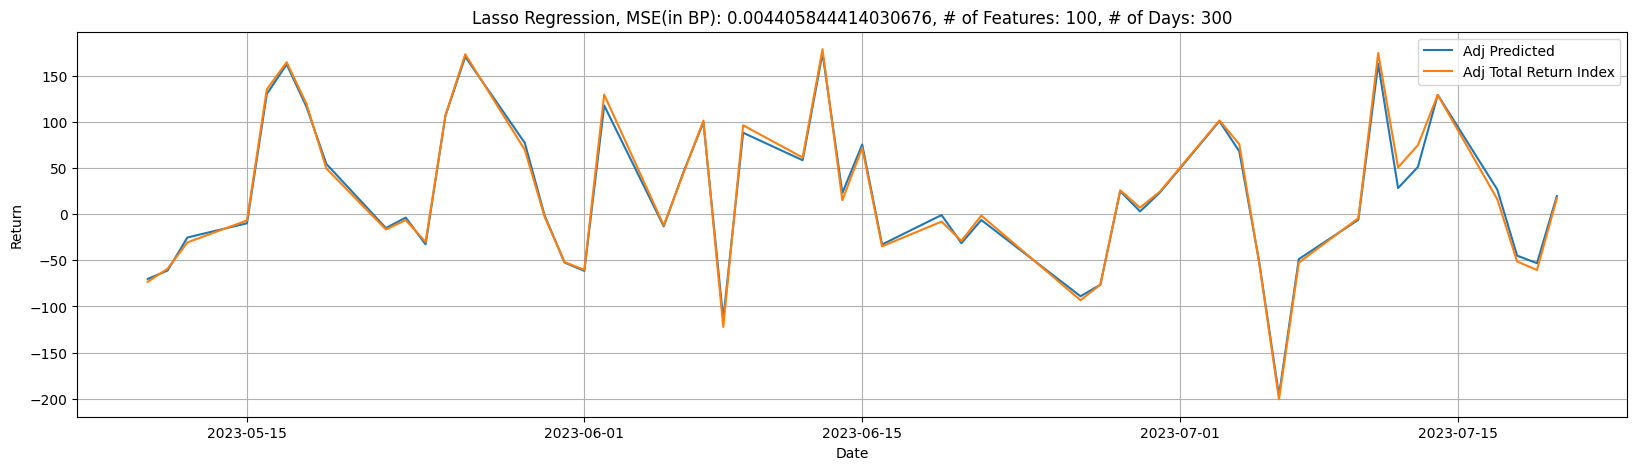

Weights
2330  0.337202
2317  0.037894
2454  0.033400
2412  0.024280
2308  0.018881
...        ...
3023  0.004705
3653  0.001173
2633 -0.000000
2049  0.003597
2383  0.004787

[98 rows x 1 columns]

0.0023702375398146095


In [10]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()
alpha = 0.0000001


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = Lasso(fit_intercept = False, alpha = alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Lasso MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = Lasso(fit_intercept = False, alpha = alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_pred), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Lasso Regression, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day+1:].sum(axis = 1)[-1],
                    index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## *Method 3: CGR*

In [11]:
def Optimizer(tested_return,target,initial_weights,  constraints, bounds, method, options): 
    def objective(weights):
        portfolio_returns = tested_return.dot(weights)
        return ((portfolio_returns - target)**2).sum()

    res = minimize(objective, initial_weights, method=method, bounds=bounds,
            constraints=constraints, options=options)
    
    return res.x

Number of Days: 100, Number of Features: 100, MSE: 5.001699388414097e-06, Nan in weights: False
Number of Days: 200, Number of Features: 100, MSE: 1.8897495225239752e-06, Nan in weights: False
Number of Days: 300, Number of Features: 100, MSE: 1.8687895978652364e-06, Nan in weights: False
Number of Days: 400, Number of Features: 100, MSE: 1.8993243862592405e-06, Nan in weights: False
Number of Days: 500, Number of Features: 100, MSE: 1.8763119242274252e-06, Nan in weights: False
Number of Days: 100, Number of Features: 300, MSE: 3.3418994387706345e-07, Nan in weights: False
Number of Days: 200, Number of Features: 300, MSE: 3.206434351609499e-07, Nan in weights: False
Number of Days: 300, Number of Features: 300, MSE: 3.6956113481485726e-07, Nan in weights: False
Number of Days: 400, Number of Features: 300, MSE: 4.1739376971686195e-07, Nan in weights: False
Number of Days: 500, Number of Features: 300, MSE: 4.6897518855568016e-07, Nan in weights: False
Number of Days: 100, Number of F

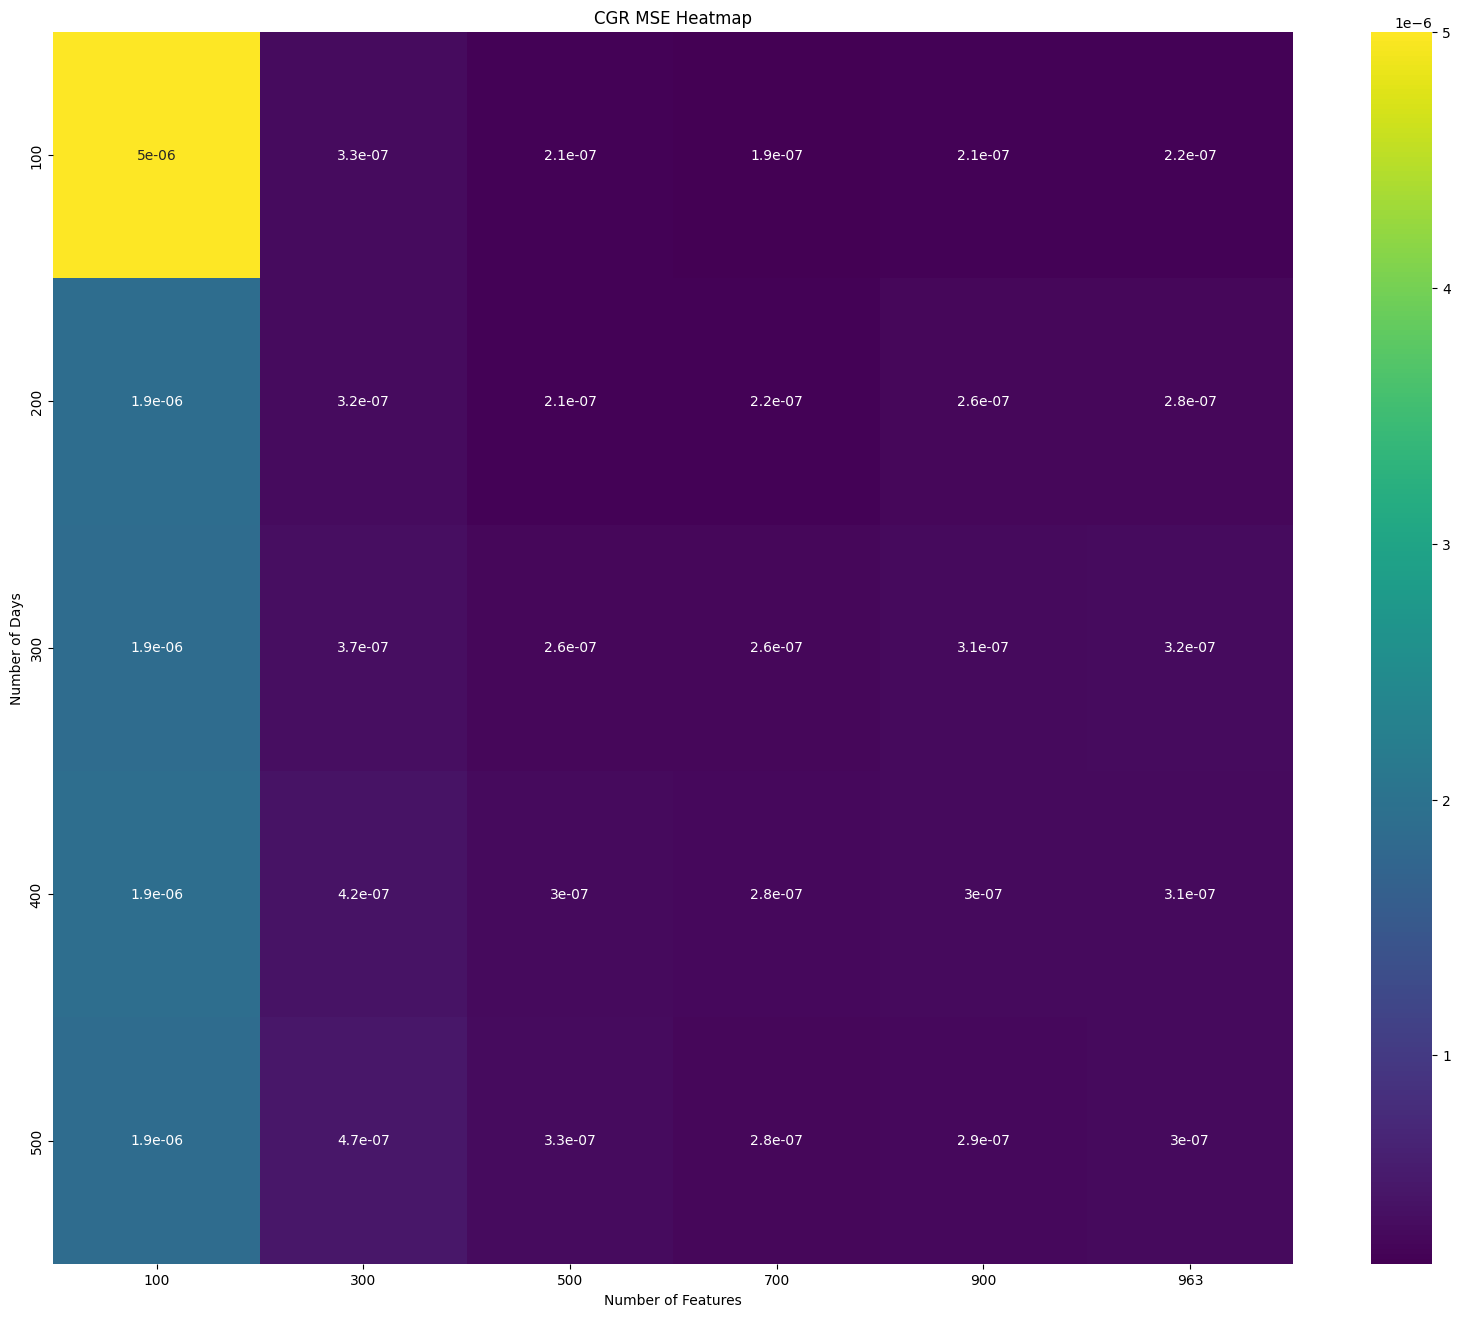

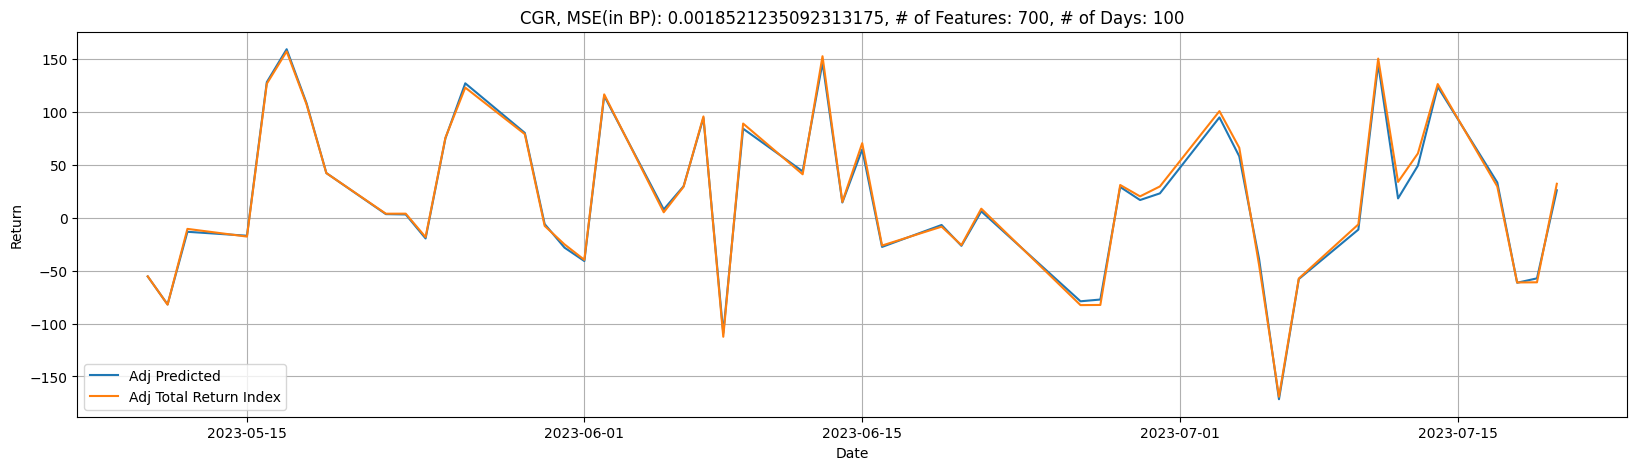

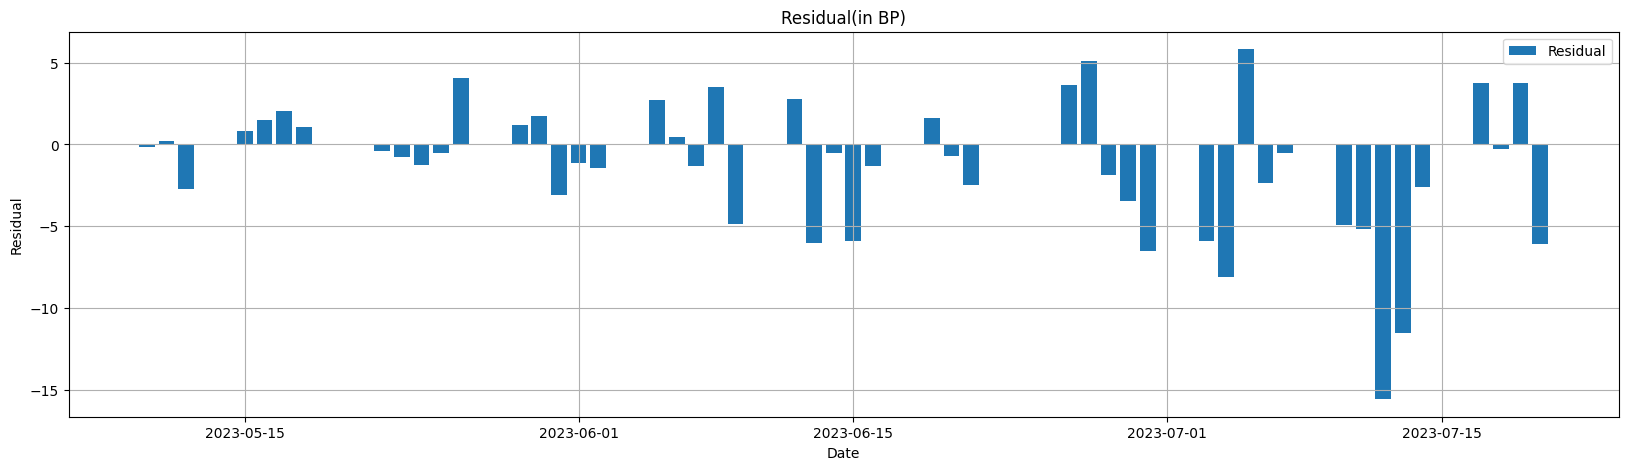

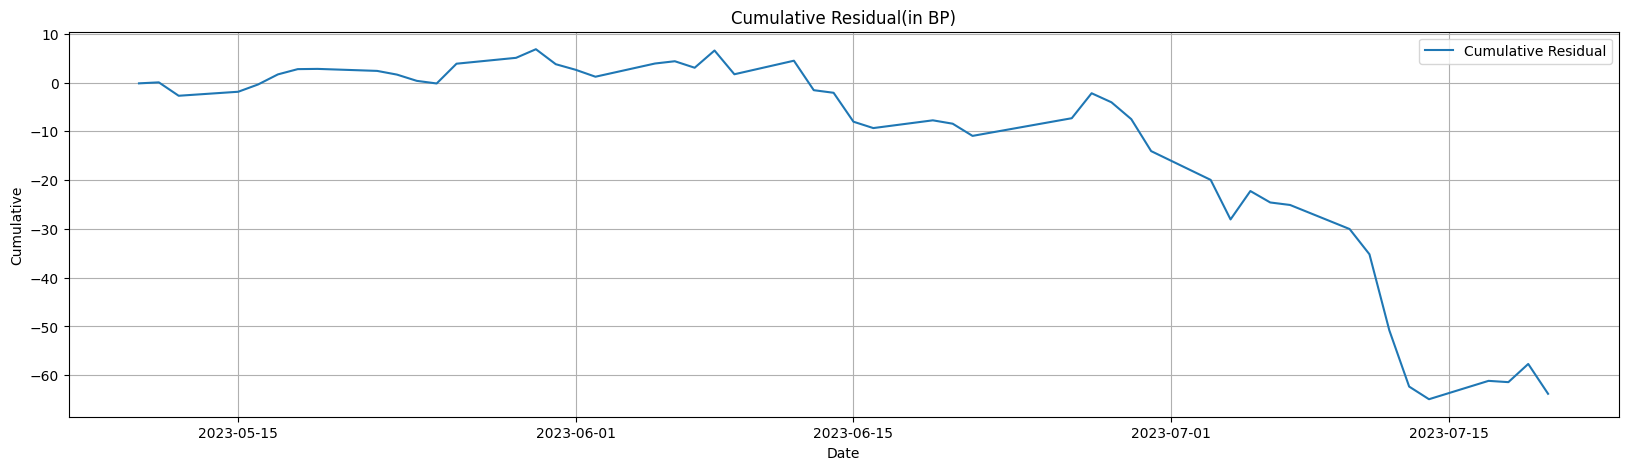

Weights
2330  0.276540
2317  0.030873
2454  0.024497
2412  0.019524
2308  0.016451
...        ...
6792  0.000076
6861  0.000198
3338  0.000155
6283  0.000145
2399  0.000104

[700 rows x 1 columns]

0.0015582940057515555


In [12]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].sum(axis = 0) / len(weights[:num_of_day])

        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
        )
        bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]
    
        optmized_weights = Optimizer(X_train,y_train,initial_weights,
                                    constraints, bounds, 
                                    method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

        optimization = (optmized_weights * X_test).sum(axis = 1)


        mse = mean_squared_error(y_test, optimization)
        print(f'Number of Days: {num_of_day}, Number of Features: {num_of_feature}, MSE: {mse}, Nan in weights: {initial_weights.isna().any()}')

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"CGR MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].sum(axis = 0) / len(weights[:num_of_day])

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
)
bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]

optmized_weights = Optimizer(X_train,y_train,initial_weights,
                            constraints, bounds, 
                            method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

optimization = (optmized_weights * X_test).sum(axis = 1)


mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'CGR, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(optmized_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

# **Anomaly Detection**

In [13]:
TSMC_return = calculate_log_returns(TX_Closing[["2330"]])[1:]
FBN_return = calculate_log_returns(TX_Closing[["2881"]])[1:]
FPCC_return = calculate_log_returns(TX_Closing[["6505"]])[1:]

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='CGR Prediction (700 Components)')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Total Return Index')
plt.plot(adj_y_test.index, 10000 * TSMC_return[-50:], label='TSMC')
plt.plot(adj_y_test.index, 10000 * FBN_return[-50:], label='FBN')
plt.plot(adj_y_test.index, 10000 * FPCC_return[-50:], label='FPCC')

plt.legend()
plt.title(f'Daily Return of strongests in Elec., BKI., and NEF.')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

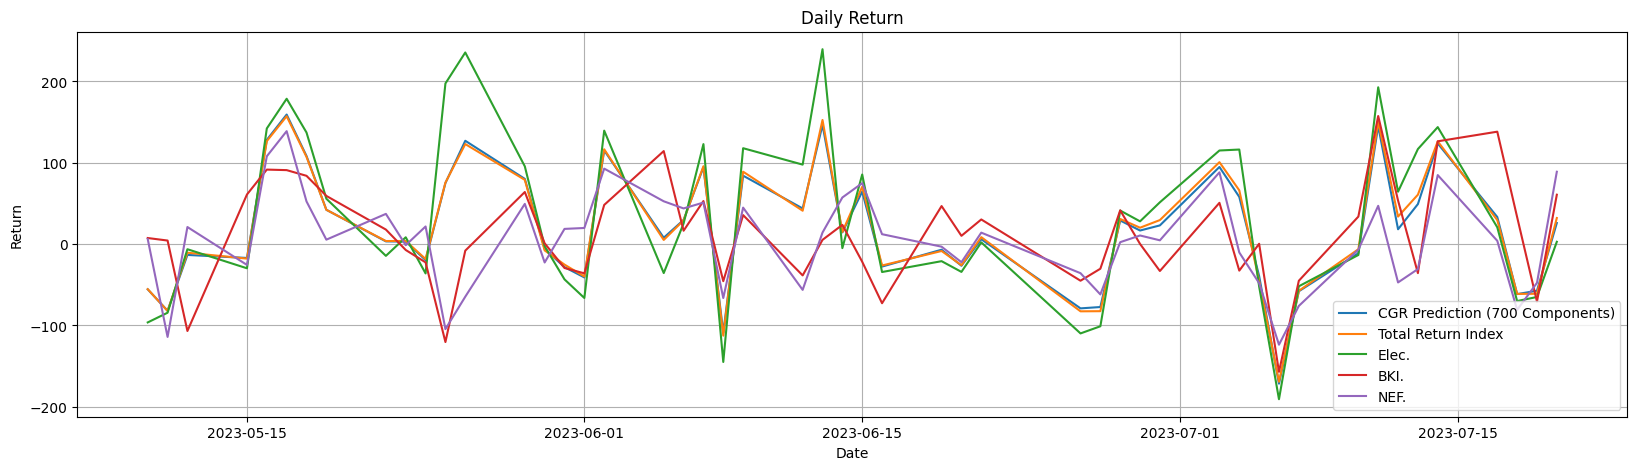

In [14]:
E_return = calculate_log_returns(TX_Closing[E_list])[1:]
F_return = calculate_log_returns(TX_Closing[F_list])[1:]
NEF_return = calculate_log_returns(TX_Closing[NEF_list])[1:]

E_weights = TX_Weights[E_list].div(TX_Weights[E_list].sum(axis = 1), axis = 0)
F_weights = TX_Weights[F_list].div(TX_Weights[F_list].sum(axis = 1), axis = 0)
NEF_weights = TX_Weights[NEF_list].div(TX_Weights[NEF_list].sum(axis = 1), axis = 0)

Total_E_return = (E_weights * E_return).sum(axis = 1)
Total_F_return = (F_weights * F_return).sum(axis = 1)
Total_NEF_return = (NEF_weights * NEF_return).sum(axis = 1)

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='CGR Prediction (700 Components)')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Total Return Index')
plt.plot(adj_y_test.index, 10000 * Total_E_return [-50:], label='Elec.')
plt.plot(adj_y_test.index, 10000 * Total_F_return [-50:], label='BKI.')
plt.plot(adj_y_test.index, 10000 * Total_NEF_return [-50:], label='NEF.')


plt.legend()
plt.title(f'Daily Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

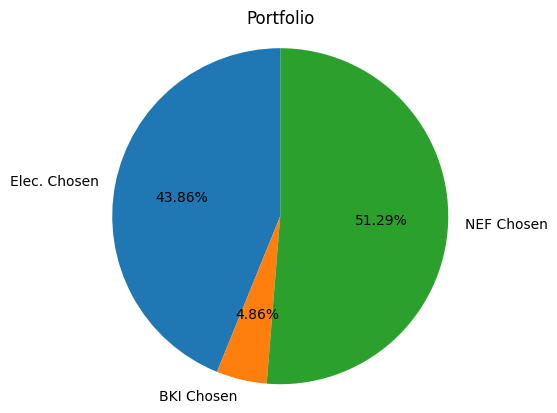

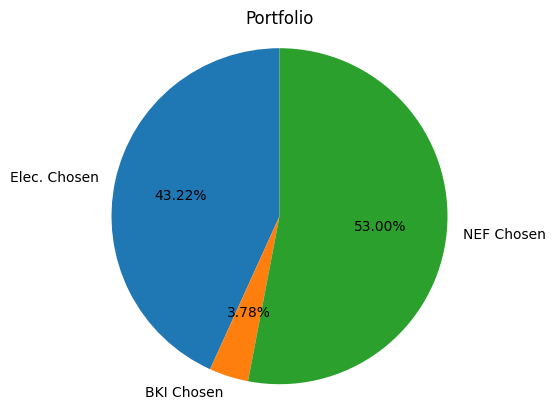

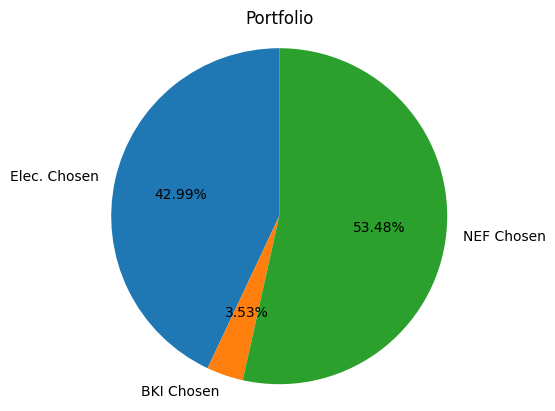

In [15]:
for num_of_feature in num_of_features:
    top_E = [x for x in TX_Weights.columns[:num_of_feature] if x in E_list]
    top_F = [x for x in TX_Weights.columns[:num_of_feature] if x in F_list]
    top_NEF = [x for x in TX_Weights.columns[:num_of_feature] if x in NEF_list]

    # Values
    weights = [len(top_E), len(top_F), len(top_NEF)]

    # Labels
    labels = ['Elec. Chosen', 'BKI Chosen', 'NEF Chosen']

    # Create pie chart
    plt.pie(weights, labels=labels, autopct='%1.2f%%', startangle=90)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')

    # Display the chart
    plt.title(f'Portfolio')
    plt.show()

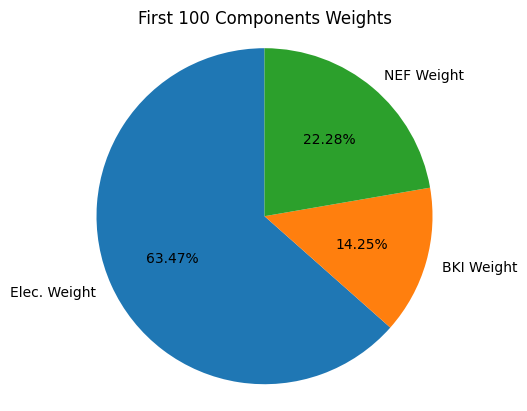

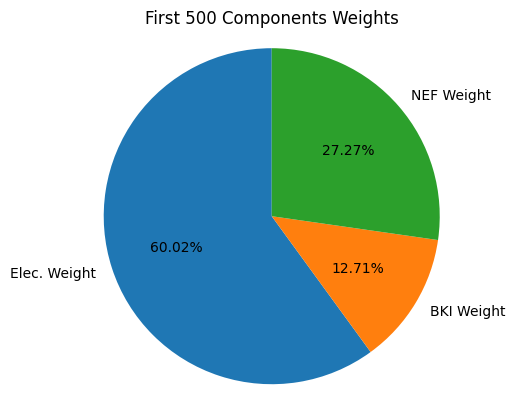

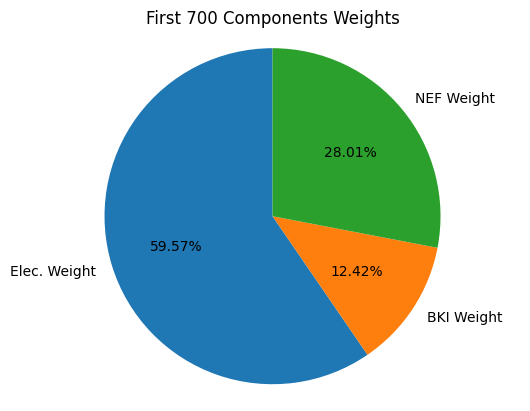

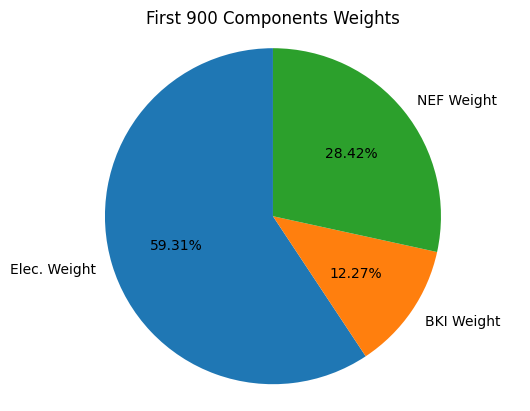

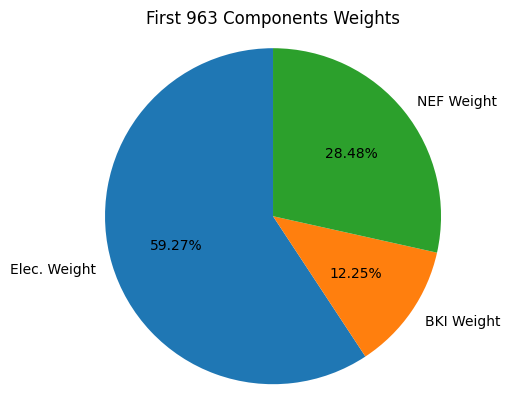

In [16]:
for num_of_feature in num_of_features:
    top_E = [x for x in TX_Weights.columns[:num_of_feature] if x in E_list]
    top_F = [x for x in TX_Weights.columns[:num_of_feature] if x in F_list]
    top_NEF = [x for x in TX_Weights.columns[:num_of_feature] if x in NEF_list]

    Total_E_Weight = TX_Weights[top_E].sum(axis=1).sum(axis = 0) / len(TX_Weights[top_E].sum(axis=1))
    Total_F_Weight = TX_Weights[top_F].sum(axis=1).sum(axis = 0) / len(TX_Weights[top_F].sum(axis=1))
    Total_NEF_Weight = TX_Weights[top_NEF].sum(axis=1).sum(axis = 0) / len(TX_Weights[top_NEF].sum(axis=1))

    # Values
    weights = [Total_E_Weight, Total_F_Weight, Total_NEF_Weight]

    # Labels
    labels = ['Elec. Weight', 'BKI Weight', 'NEF Weight']

    # Create pie chart
    plt.pie(weights, labels=labels, autopct='%1.2f%%', startangle=90)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')

    # Display the chart
    plt.title(f'First {num_of_feature} Components Weights')
    plt.show()

# **Selection of Components: Replication of Shape**

## *Combined with Linear Regression*

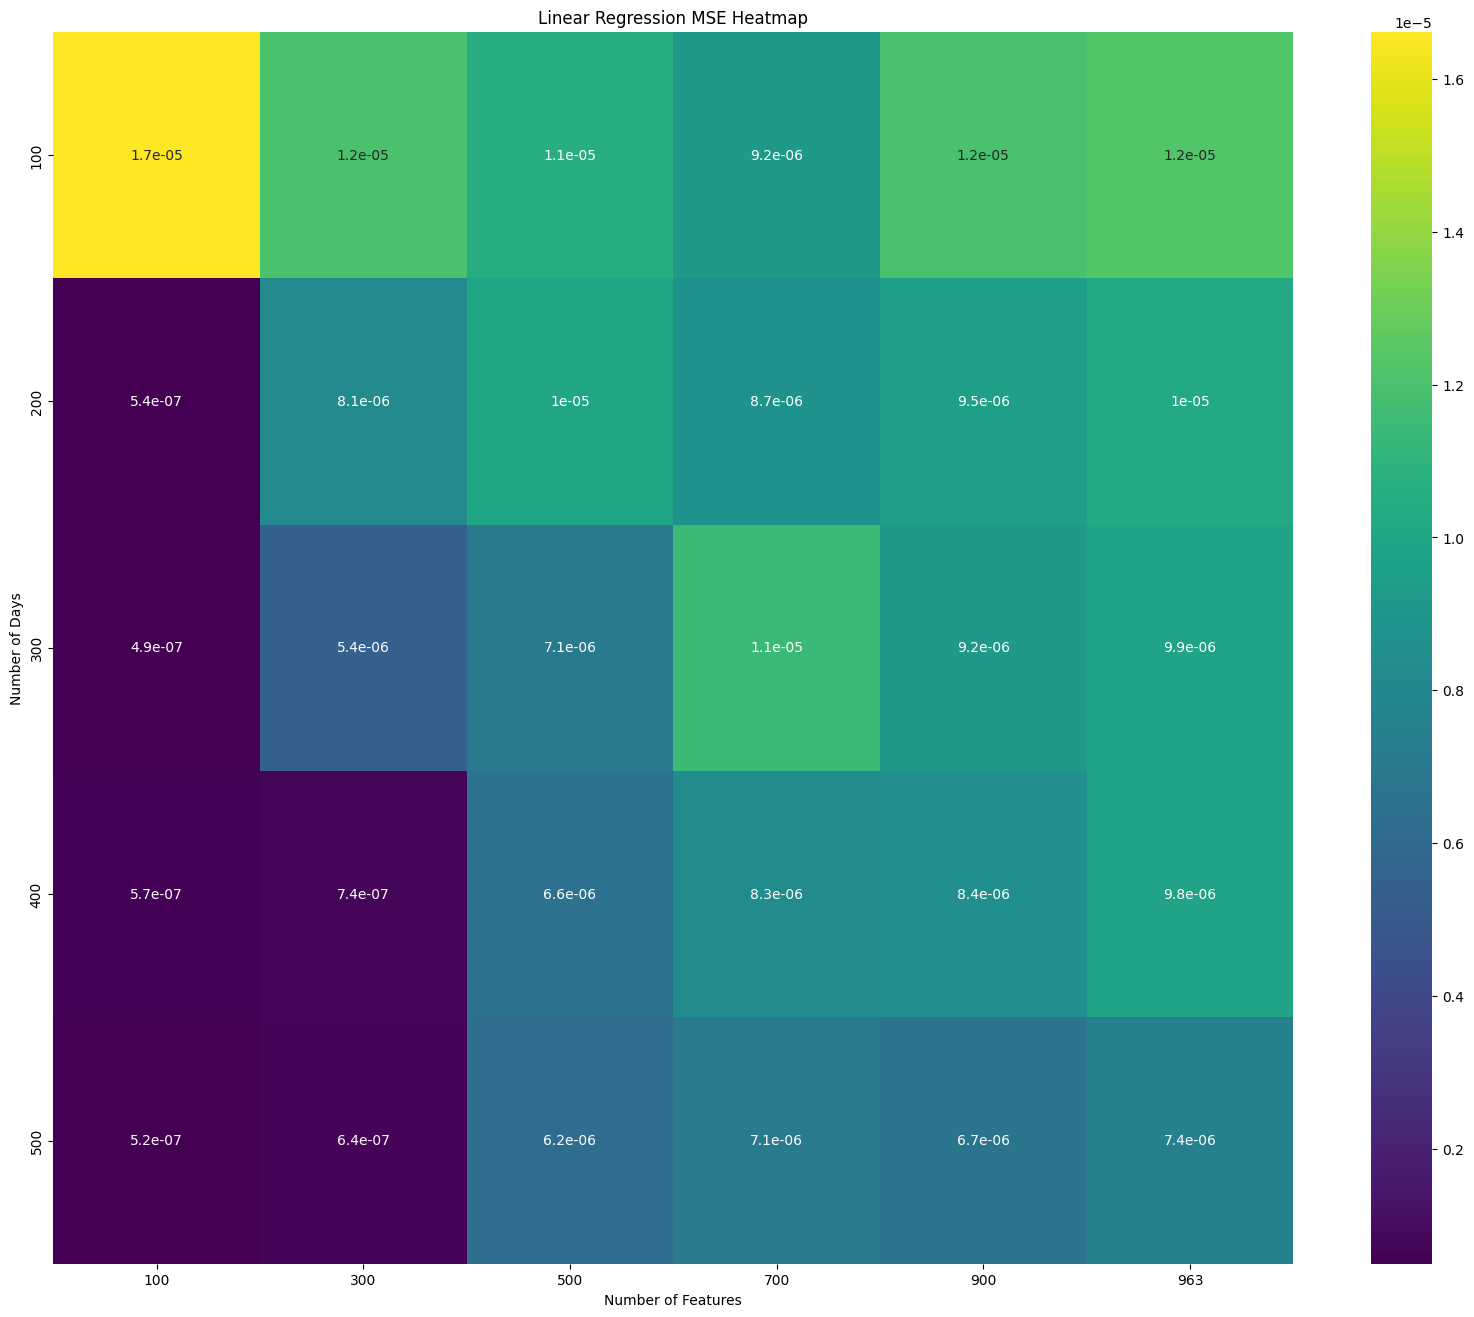

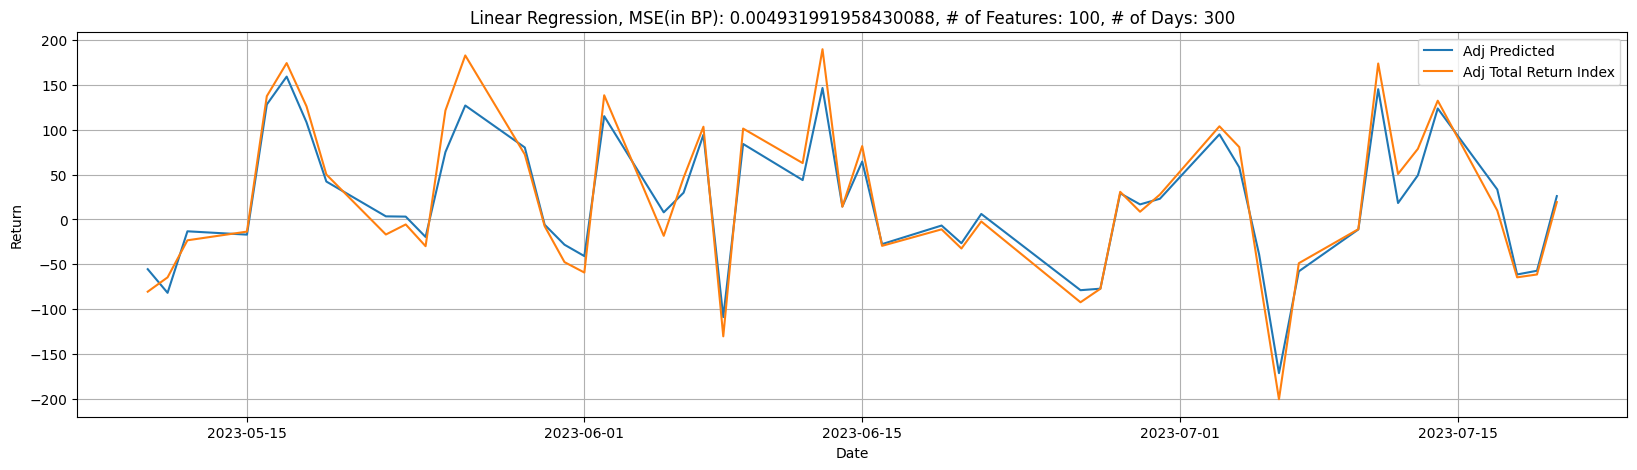

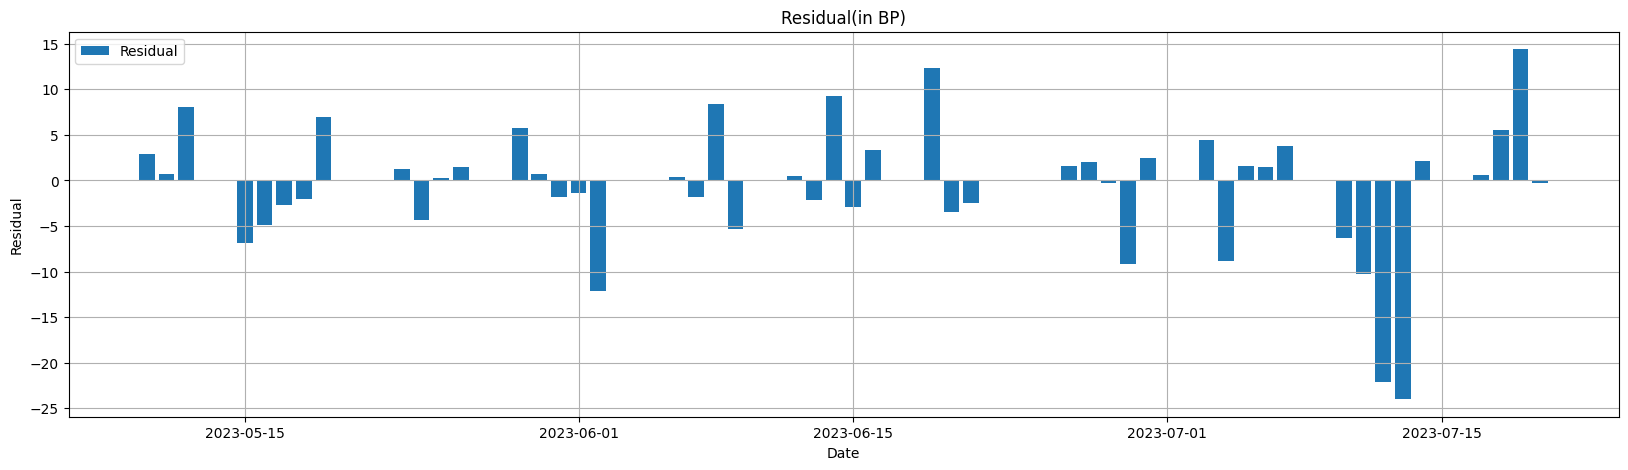

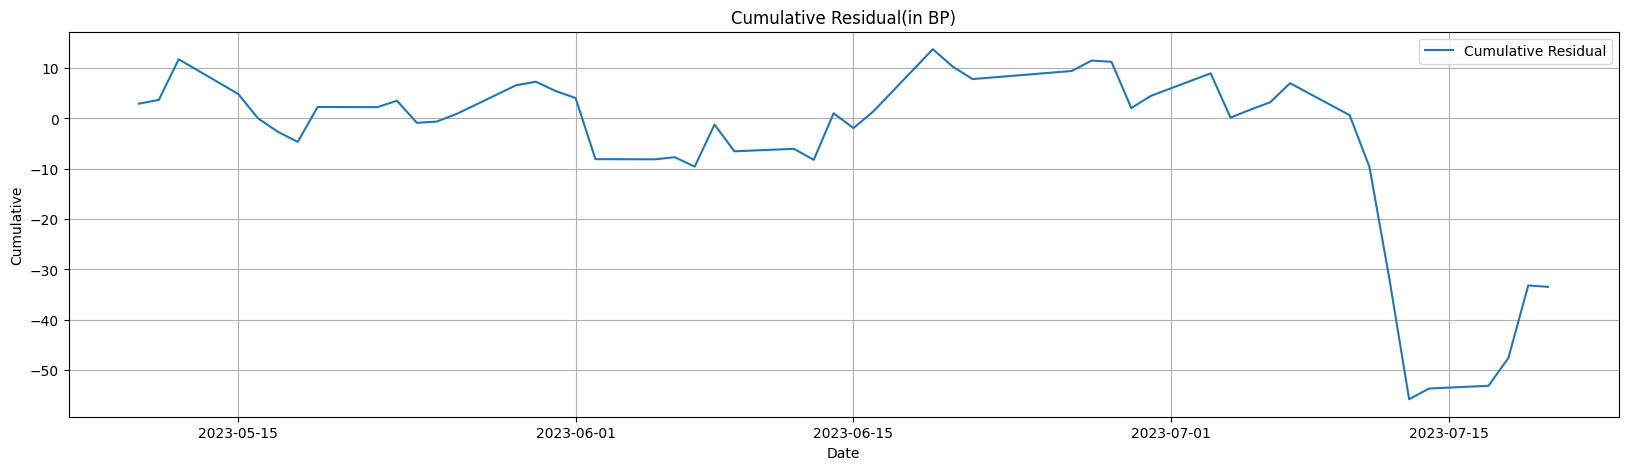

Weights
2330  0.363868
2317  0.043070
2454  0.036380
2412  0.028987
2308  0.021329
...        ...
2204  0.000760
2923  0.004351
1210 -0.002780
5522 -0.000934
1434  0.002986

[99 rows x 1 columns]

0.002401511347592847


In [17]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id

        E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = LinearRegression(fit_intercept = False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Linear Regression MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id

E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Linear Regression, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day:].sum(axis = 1)[-1],
                    index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## *Combined with Lasso*

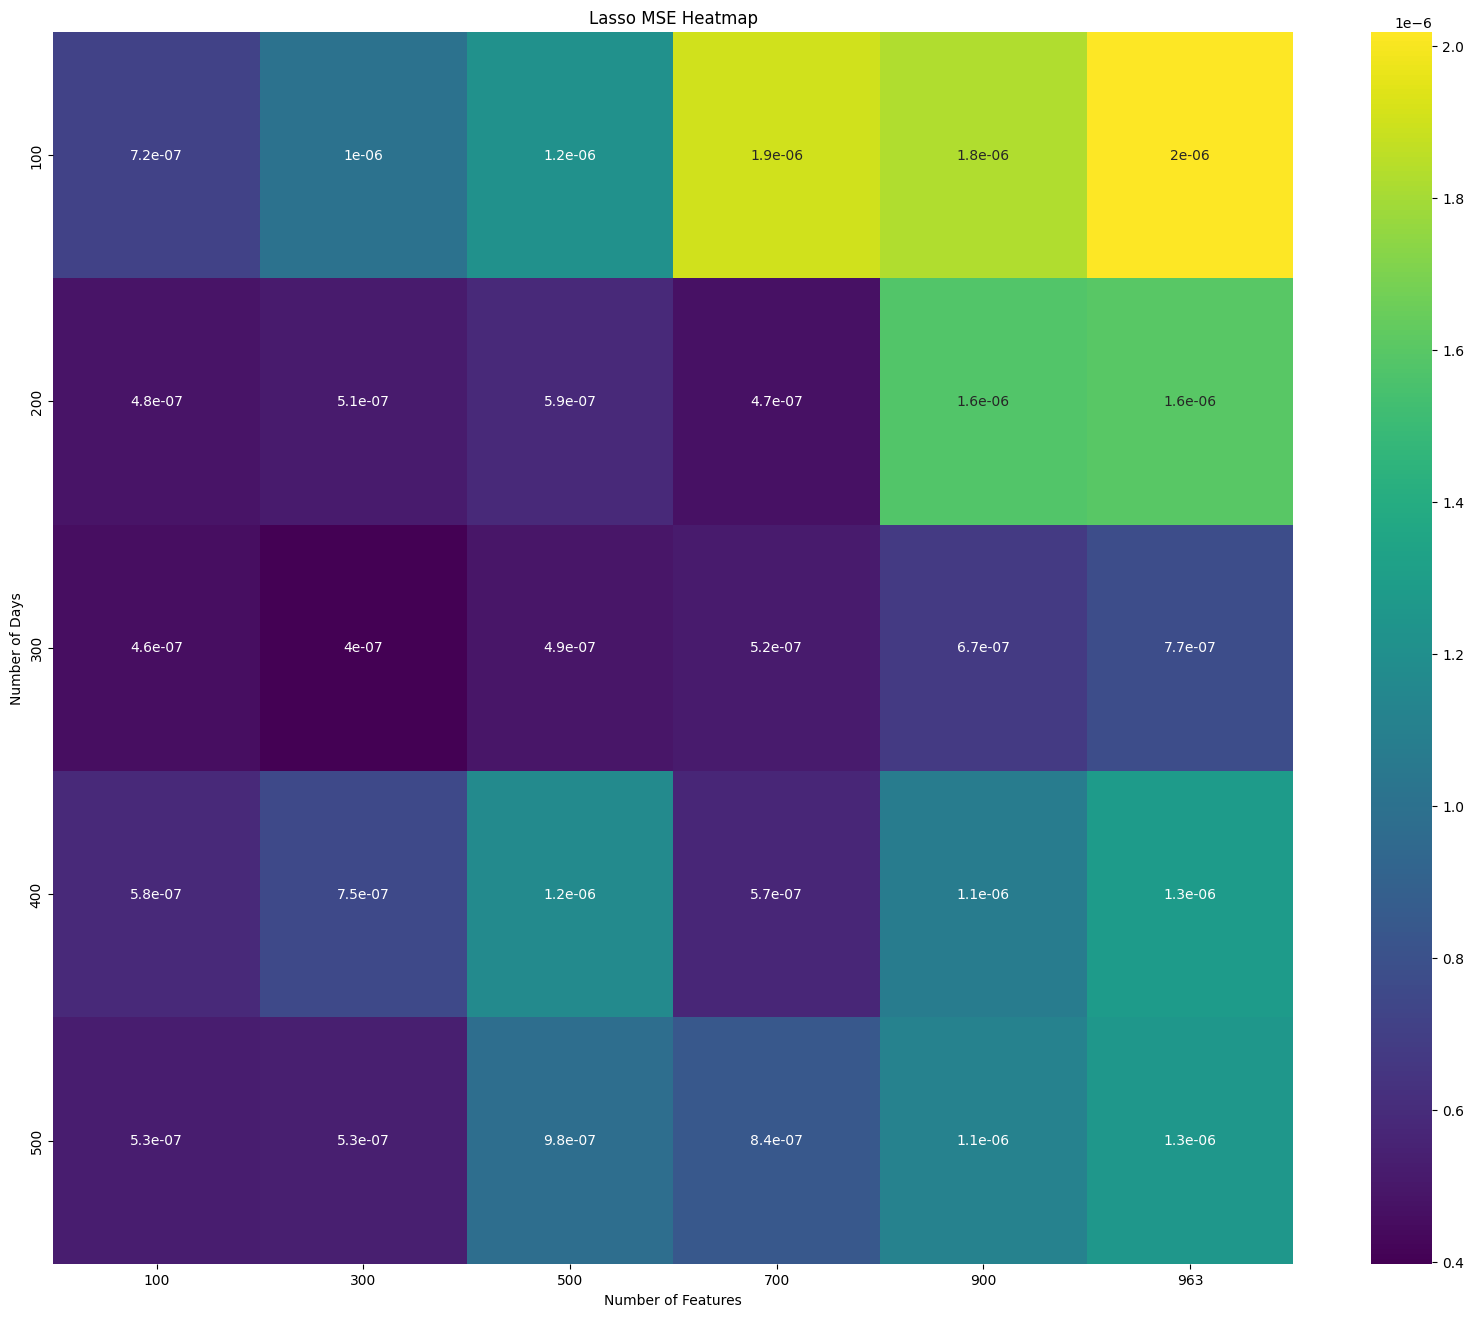

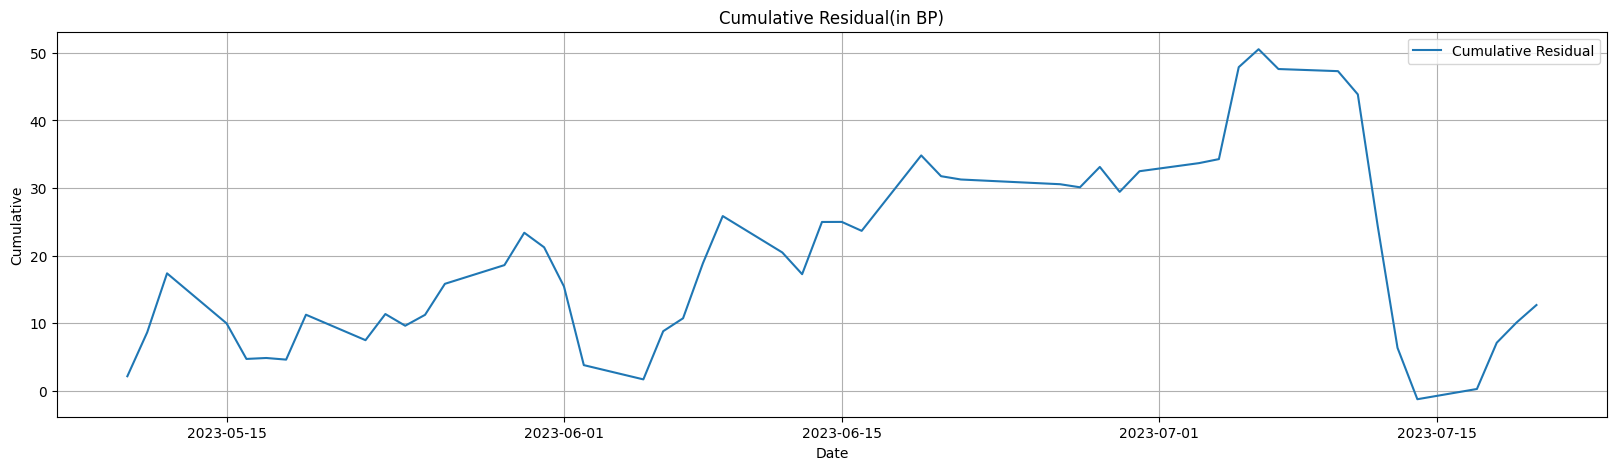

Weights
2330  0.297671
2317  0.029504
2454  0.027582
2412  0.023294
2308  0.017023
...        ...
1718  0.001315
9930  0.000000
1532 -0.000000
1305  0.001267
1903  0.000509

[288 rows x 1 columns]

0.001943190806976378


In [18]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()
alpha = 0.0000001


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id

        E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = Lasso(fit_intercept = False, alpha = alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Lasso MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id

E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = Lasso(fit_intercept = False, alpha = alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Lasso, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day:].sum(axis = 1)[-1],
                    index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## *Combined with CGR*

In [19]:
def Optimizer(tested_return,target,initial_weights,  constraints, bounds, method, options): 
    def objective(weights):
        portfolio_returns = tested_return.dot(weights)
        return ((portfolio_returns - target)**2).sum()

    res = minimize(objective, initial_weights, method=method, bounds=bounds,
            constraints=constraints, options=options)
    
    return res.x

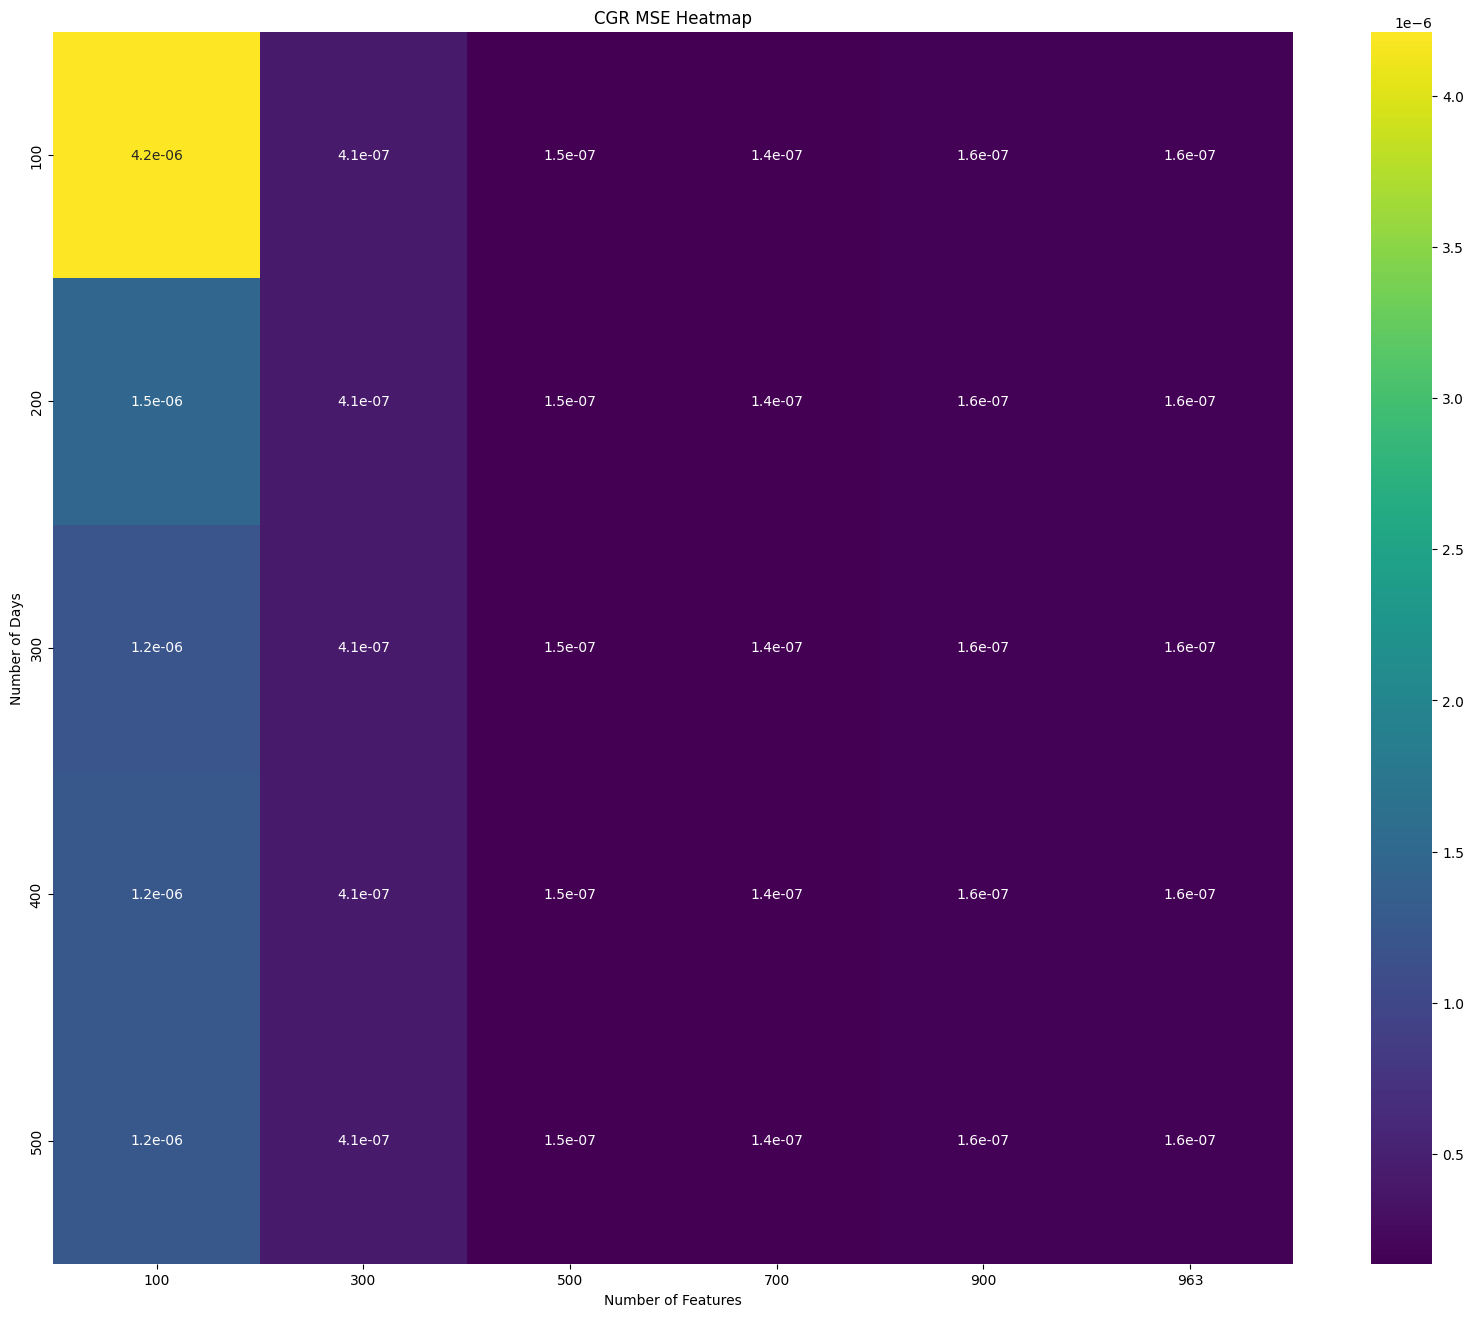

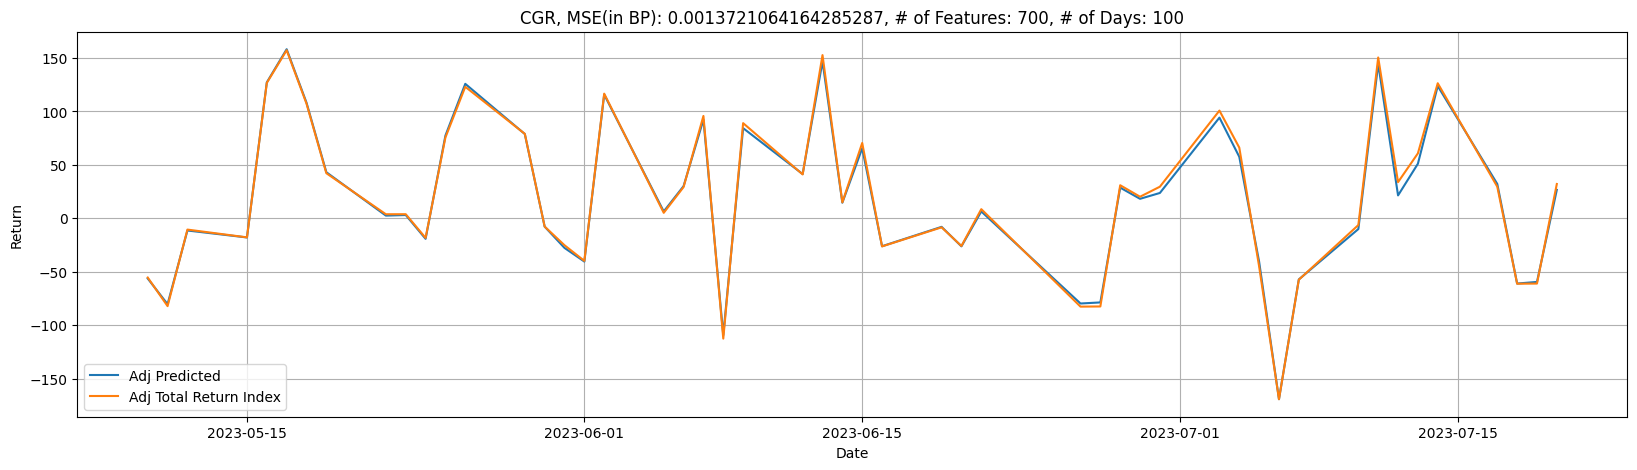

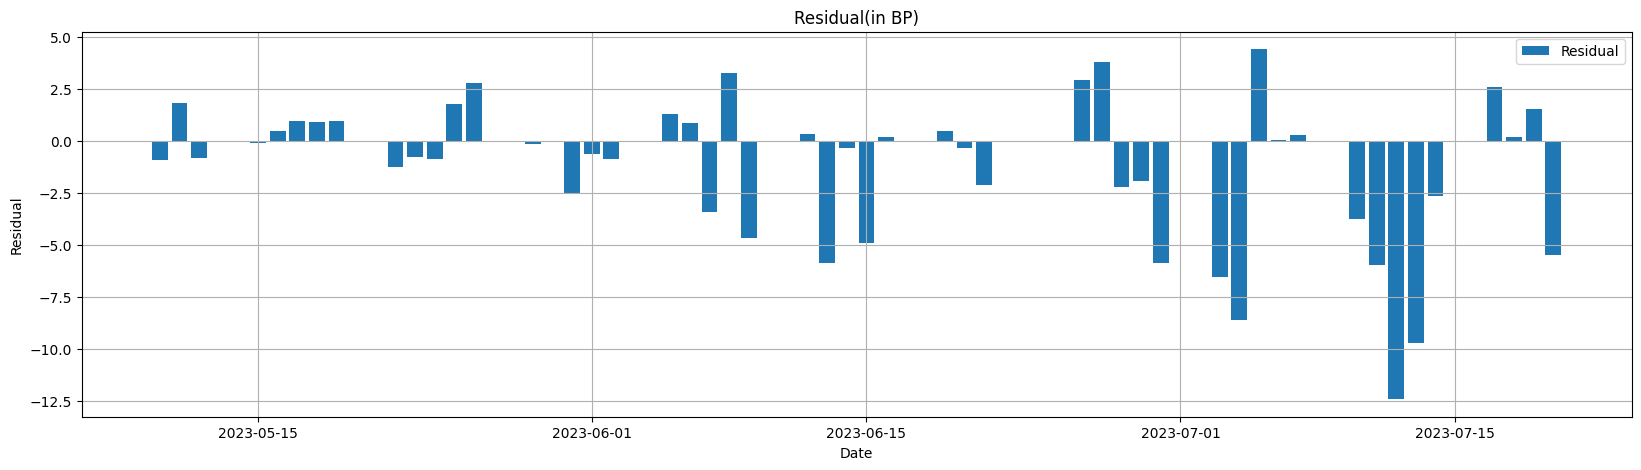

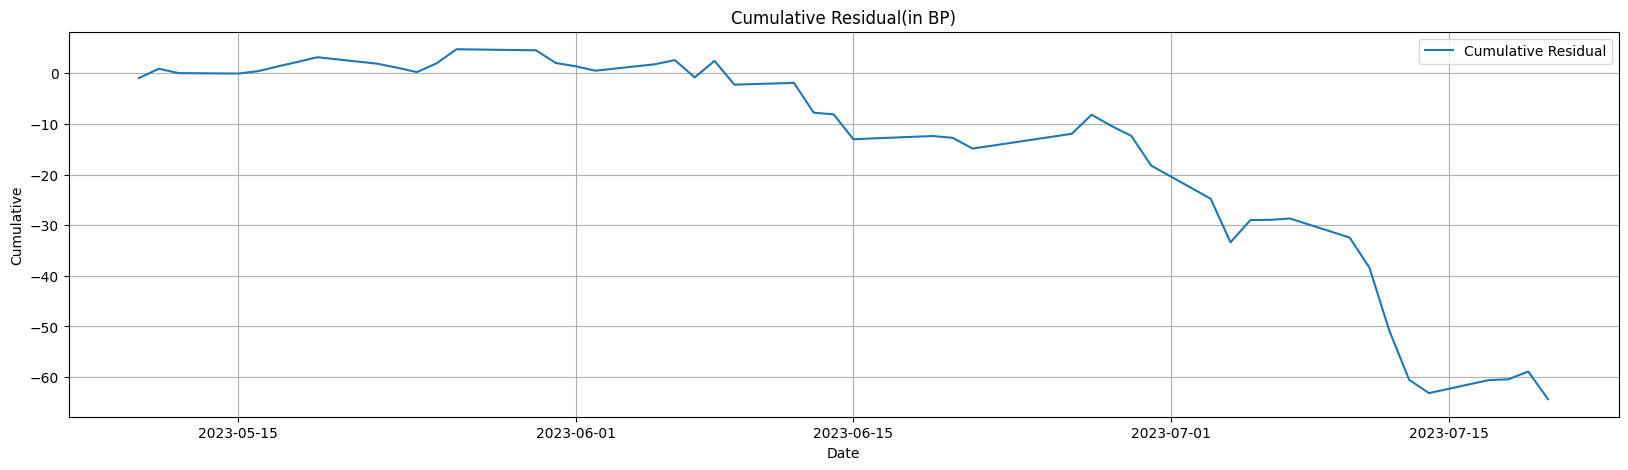

Weights
2330  0.272726
2317  0.030350
2454  0.022286
2412  0.020639
2308  0.016325
...        ...
2509  0.000071
2506  0.000076
5515  0.000069
4722  0.000074
5546  0.000070

[700 rows x 1 columns]

0.001241515028006835


In [20]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


        E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].iloc[-1]

        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
        )

        bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]
    
        optmized_weights = Optimizer(X_train,y_train,initial_weights,
                                    constraints, bounds, 
                                    method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

        optimization = (optmized_weights * X_test).sum(axis = 1)
        # in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
        # in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

        # plt.figure(figsize=(20, 5))
        # plt.bar(y_train.index, np.array(in_sample_residual), label='Residual')
        # plt.legend()
        # plt.title(f'Residual(in BP)')
        # plt.xlabel('Date')
        # plt.ylabel('In-Sample Residual')
        # plt.grid()
        # plt.show()




        mse = mean_squared_error(y_test, optimization)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"CGR MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].iloc[-1]

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
)
bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]

optmized_weights = Optimizer(X_train,y_train,initial_weights,
                            constraints, bounds, 
                            method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

optimization = (optmized_weights * X_test).sum(axis = 1)

in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test
in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array((optmized_weights * X_train).sum(axis = 1)), label='Adj Predicted')
# plt.plot(y_train.index, 10000 * np.array(y_train) , label='Adj Total Return Index')
# plt.legend()
# plt.title(f'In-sample Linear Regression, MSE(in BP): {in_sample_mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
# plt.xlabel('Date')
# plt.ylabel('Return')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.bar(y_train.index, 10000 * np.array(in_sample_residual), label='Residual')
# plt.legend()
# plt.title(f'Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('In-Sample Residual')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array(in_sample_residual).cumsum(), label='Cumulative Residual')
# plt.legend()
# plt.title(f'In-Sample Cumulative Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('Cumulative')
# plt.grid()
# plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'CGR, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(optmized_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

# **Selection of Components: Random-Forest Feature Importance**

In [21]:
X = calculate_log_returns(TX_Closing.dropna())[1:]
y = ((TX_Weights[X.columns].loc[X.index]) * X).sum(axis = 1)

In [22]:
# 创建随机森林回归器实例
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X, y)

nl = []
for i in X.columns:
    nl.append(name_l.loc[i][0])

# 输出特征重要性
importance_df = pd.DataFrame({'Feature': X.columns, "Name": nl
                            ,"Importance": rf.feature_importances_}).sort_values(by='Importance', ascending=False)
importance_df

Feature Name  Importance
0      2330  台積電    0.498126
95     3653   健策    0.020029
300    3413   京鼎    0.019685
263    2338   光罩    0.018833
73     6770  力積電    0.017479
..      ...  ...         ...
753    2461  光群雷    0.000000
758    6442   光聖    0.000000
760    9935  慶豐富    0.000000
532    1582   信錦    0.000000
417    1110   東泥    0.000000

[963 rows x 3 columns]

## *Combined with Linear Regression*

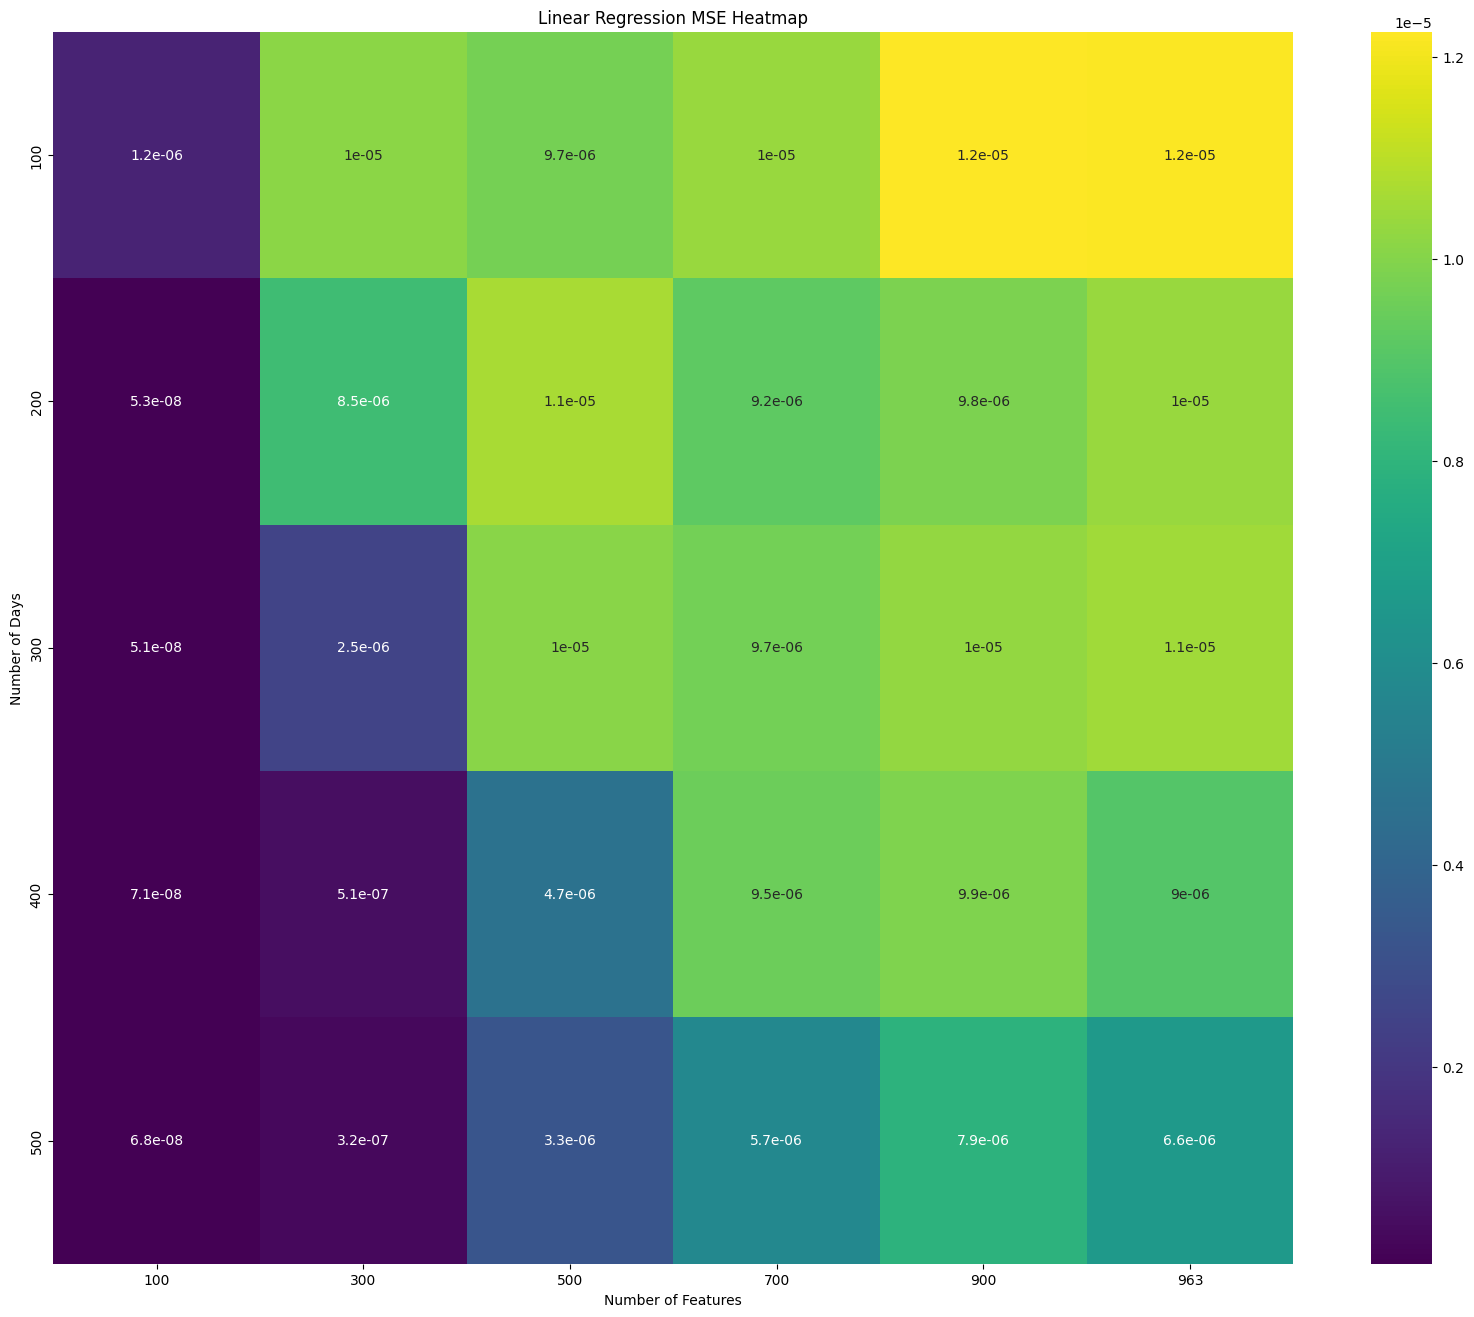

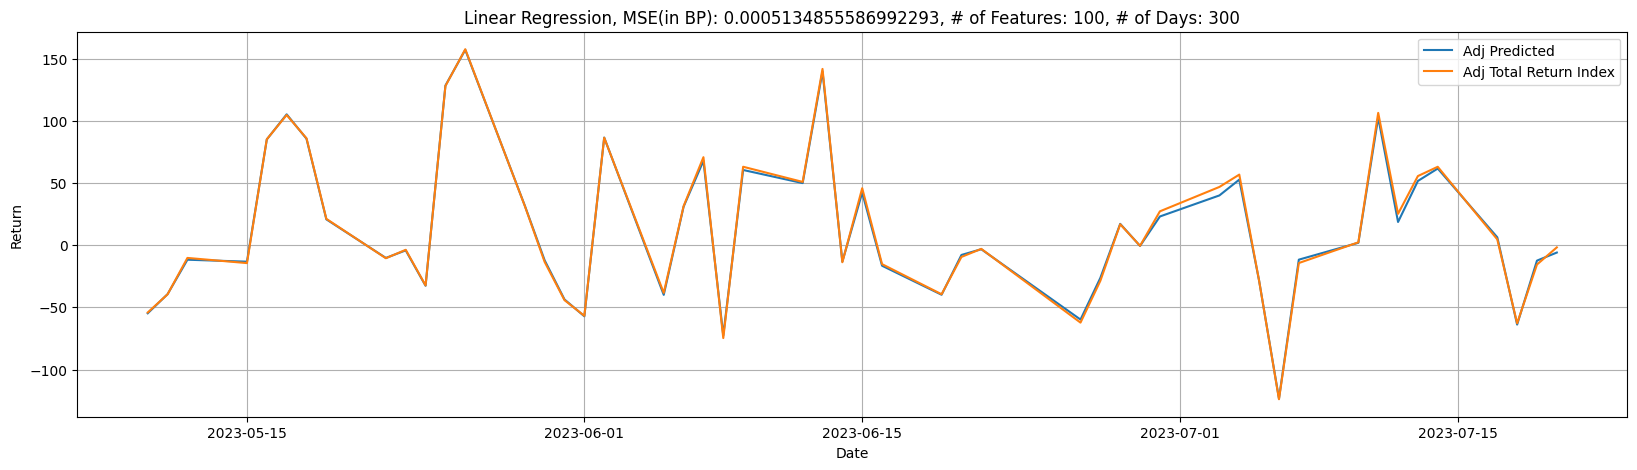

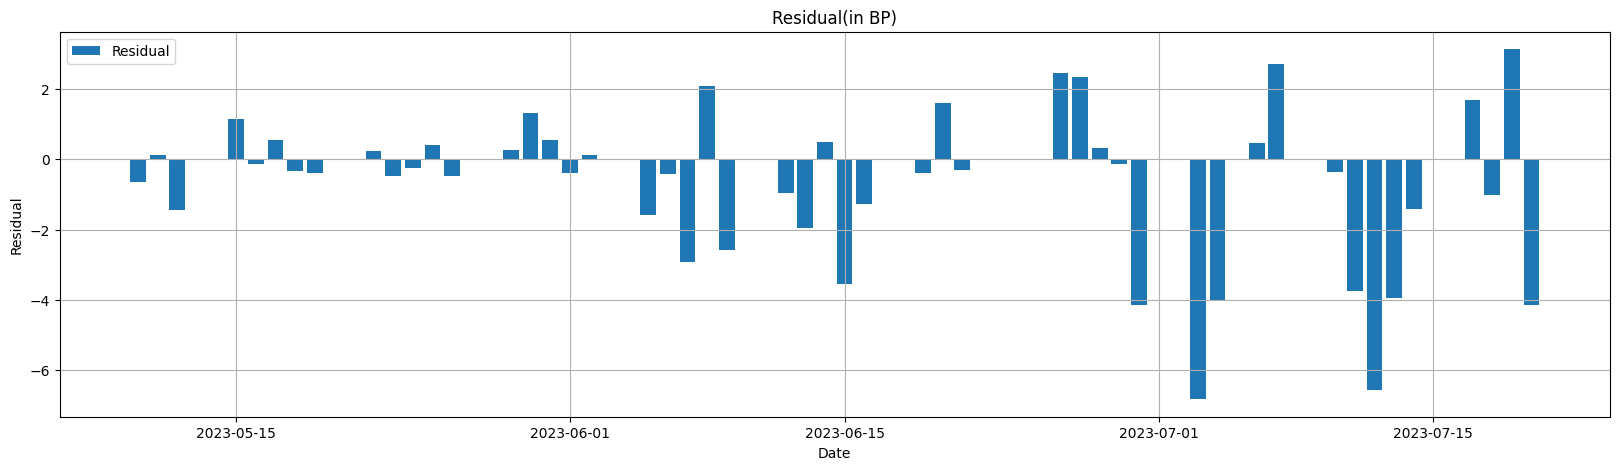

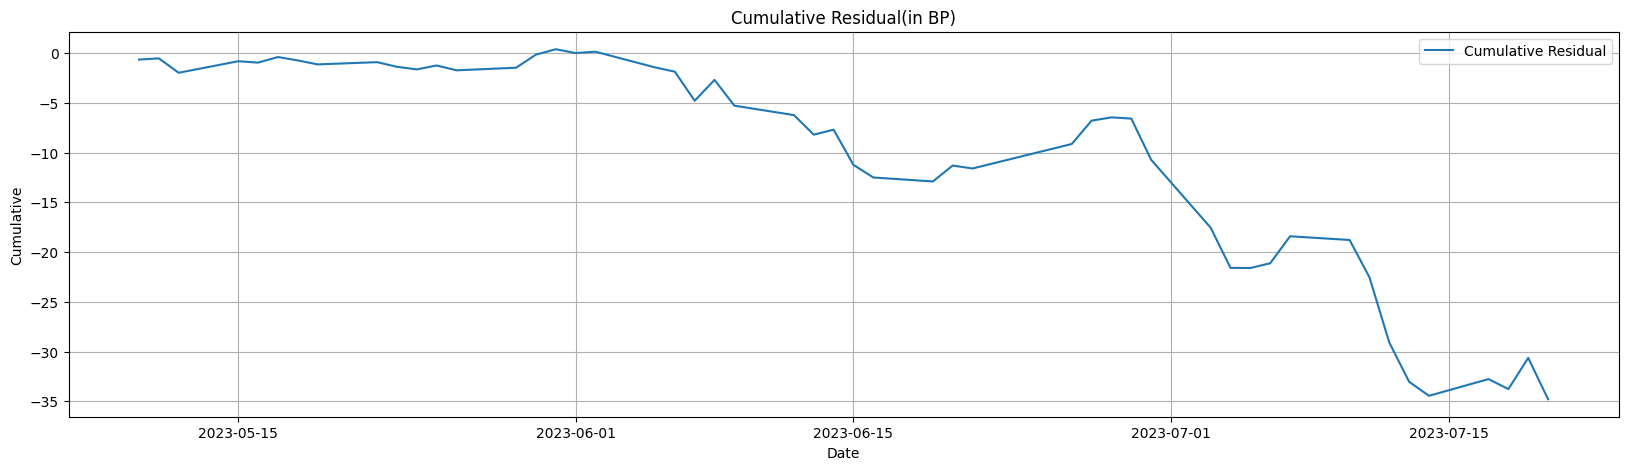

Weights
2330  0.363270
3653  0.001422
3413  0.001025
2338  0.000489
5880  0.010105
...        ...
3013  0.000507
4919  0.002296
2883  0.007279
3032  0.000597
6671 -0.000158

[96 rows x 1 columns]

0.0006828848681577999


In [23]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = LinearRegression(fit_intercept = False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Linear Regression MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_pred), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Linear Regression, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day+1:].sum(axis = 1)[-1], index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## *Combined with Lasso*

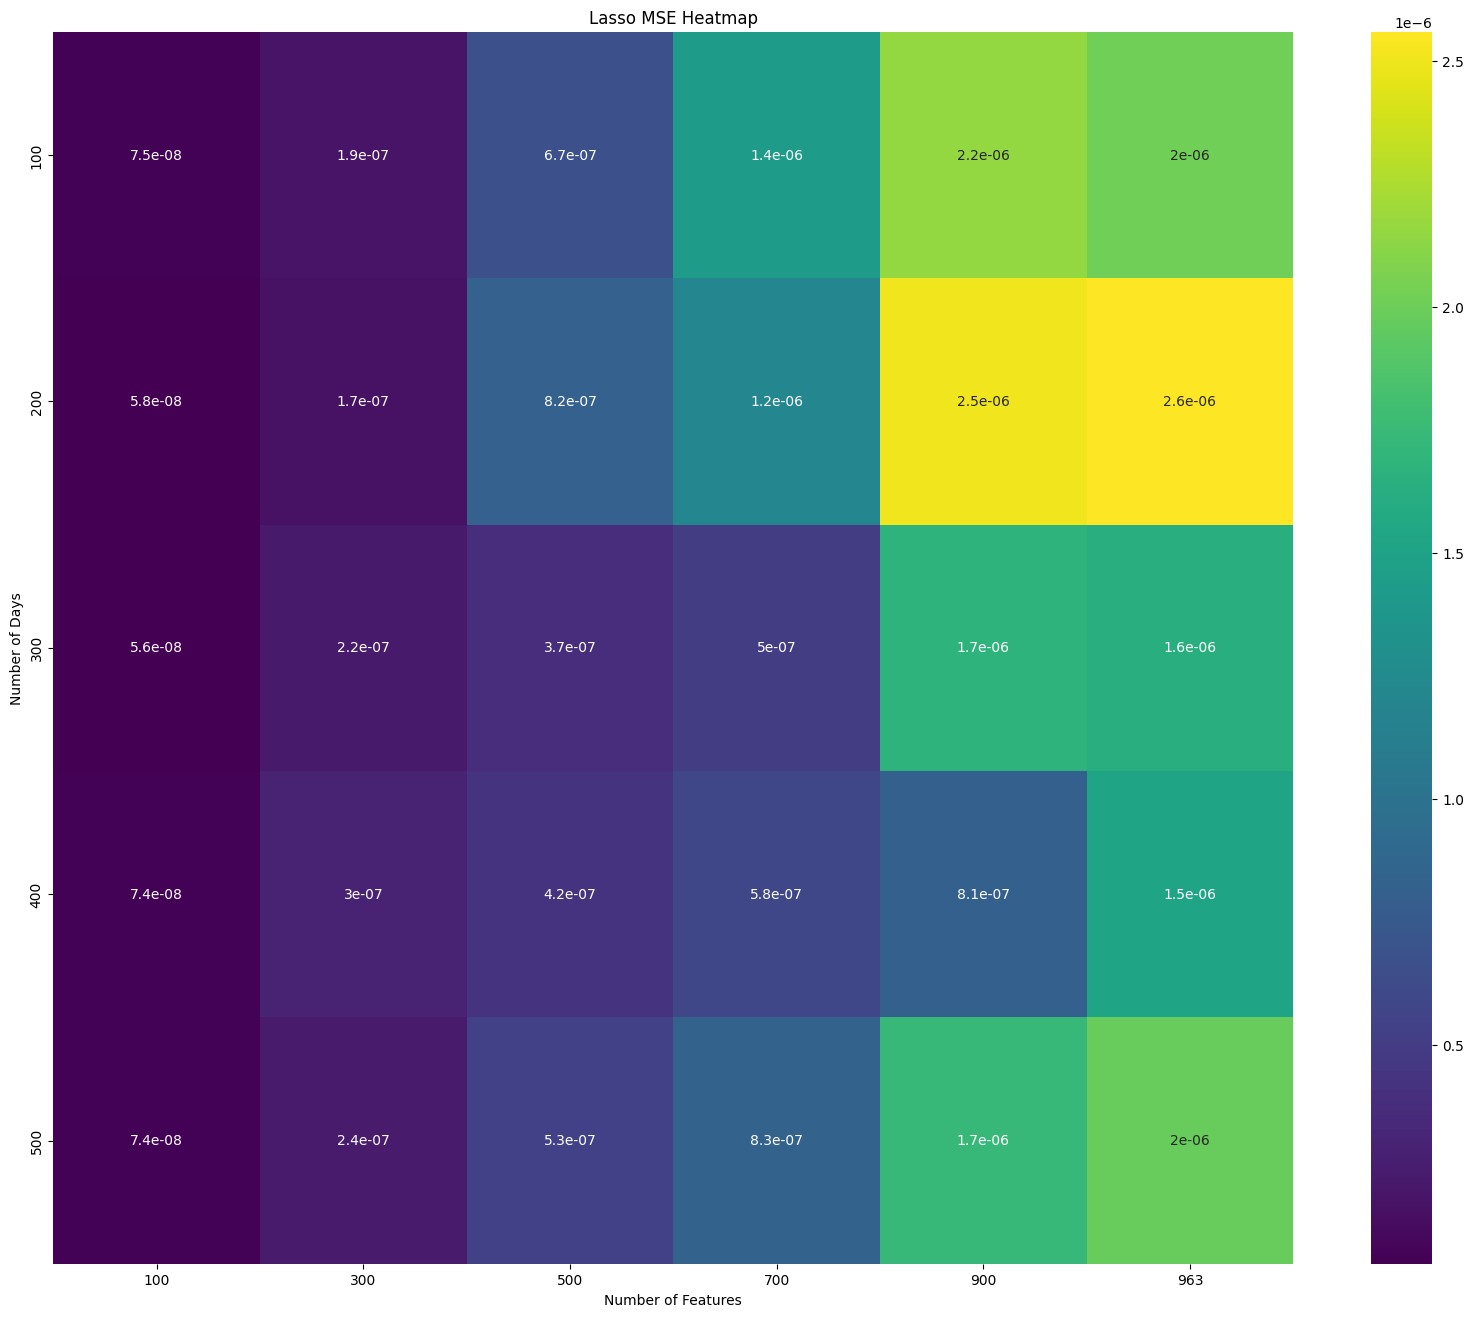

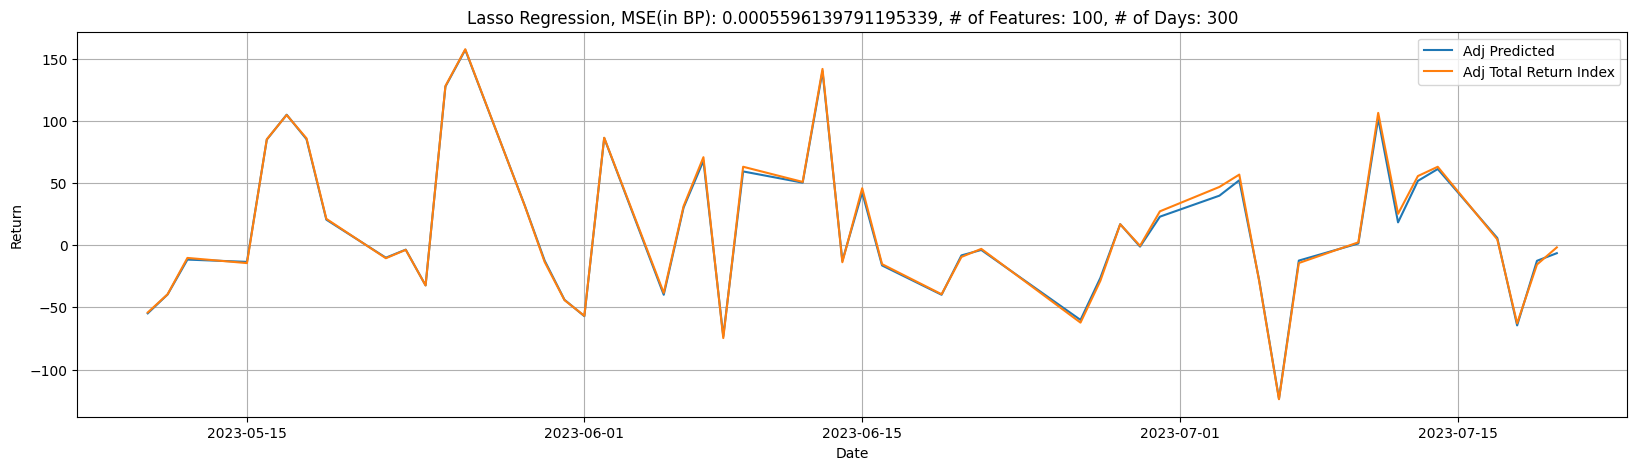

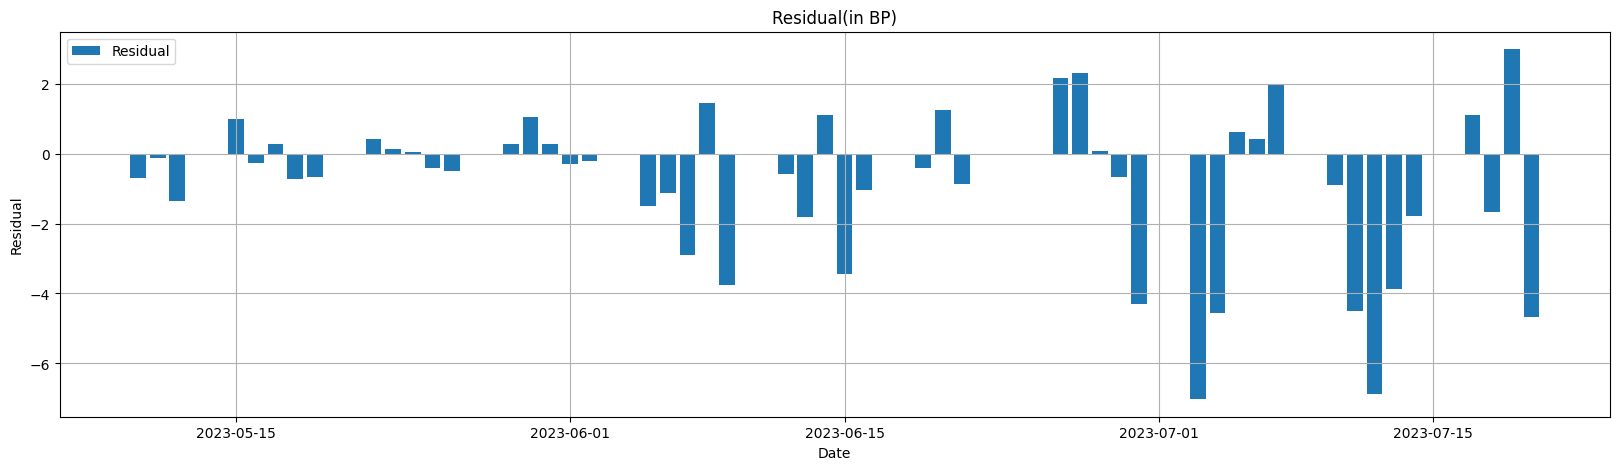

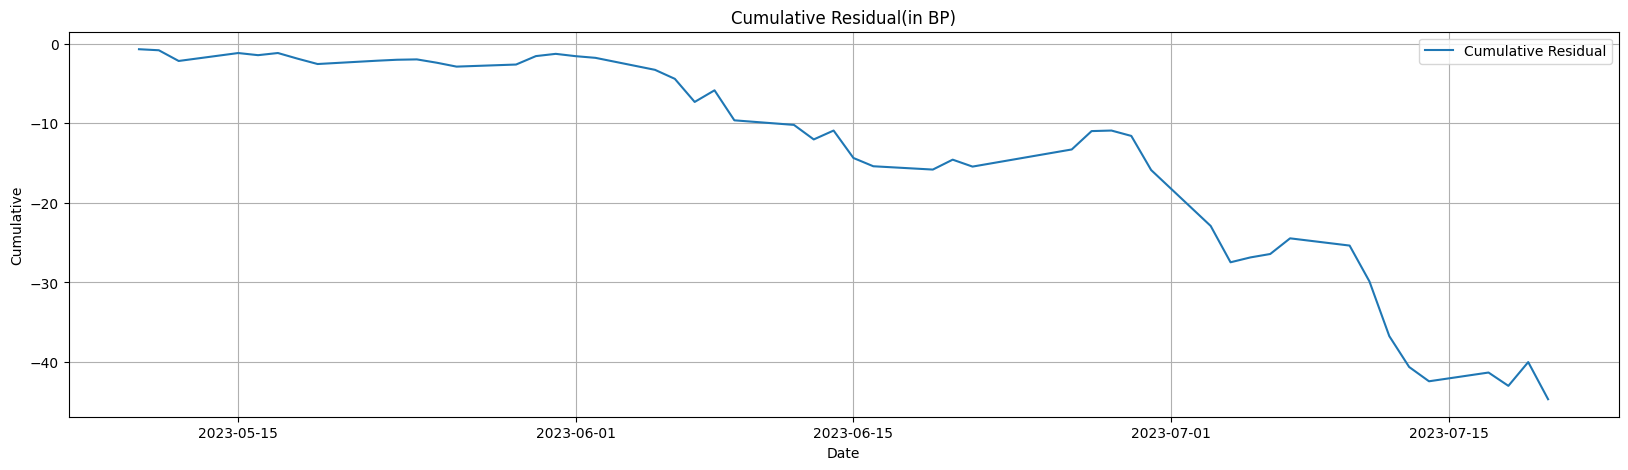

Weights
2330  0.363330
3653  0.001434
3413  0.000879
2338  0.000488
5880  0.009902
...        ...
3013  0.000419
4919  0.001845
2883  0.007249
3032  0.000298
6671  0.000000

[96 rows x 1 columns]

0.0007024712105207038


In [24]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()
alpha = 0.0000001


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = Lasso(fit_intercept = False, alpha = alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Lasso MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = Lasso(fit_intercept = False, alpha = alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day+1:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_pred), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(adj_y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Lasso Regression, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day+1:].sum(axis = 1)[-1],
                    index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## *Combined with CGR*

Number of Days: 100, Number of Features: 100, MSE: 1.8186581664563424e-05, Nan in weights: False
Number of Days: 200, Number of Features: 100, MSE: 1.4080145370642362e-05, Nan in weights: False
Number of Days: 300, Number of Features: 100, MSE: 1.5499814655458945e-05, Nan in weights: False
Number of Days: 400, Number of Features: 100, MSE: 1.406063236896728e-05, Nan in weights: False
Number of Days: 500, Number of Features: 100, MSE: 1.4788996128722104e-05, Nan in weights: False
Number of Days: 100, Number of Features: 300, MSE: 1.7846056117862483e-06, Nan in weights: False
Number of Days: 200, Number of Features: 300, MSE: 1.7996682598854464e-06, Nan in weights: False
Number of Days: 300, Number of Features: 300, MSE: 1.8993862193745432e-06, Nan in weights: False
Number of Days: 400, Number of Features: 300, MSE: 1.9520738652557407e-06, Nan in weights: False
Number of Days: 500, Number of Features: 300, MSE: 1.9505098218071925e-06, Nan in weights: False
Number of Days: 100, Number of 

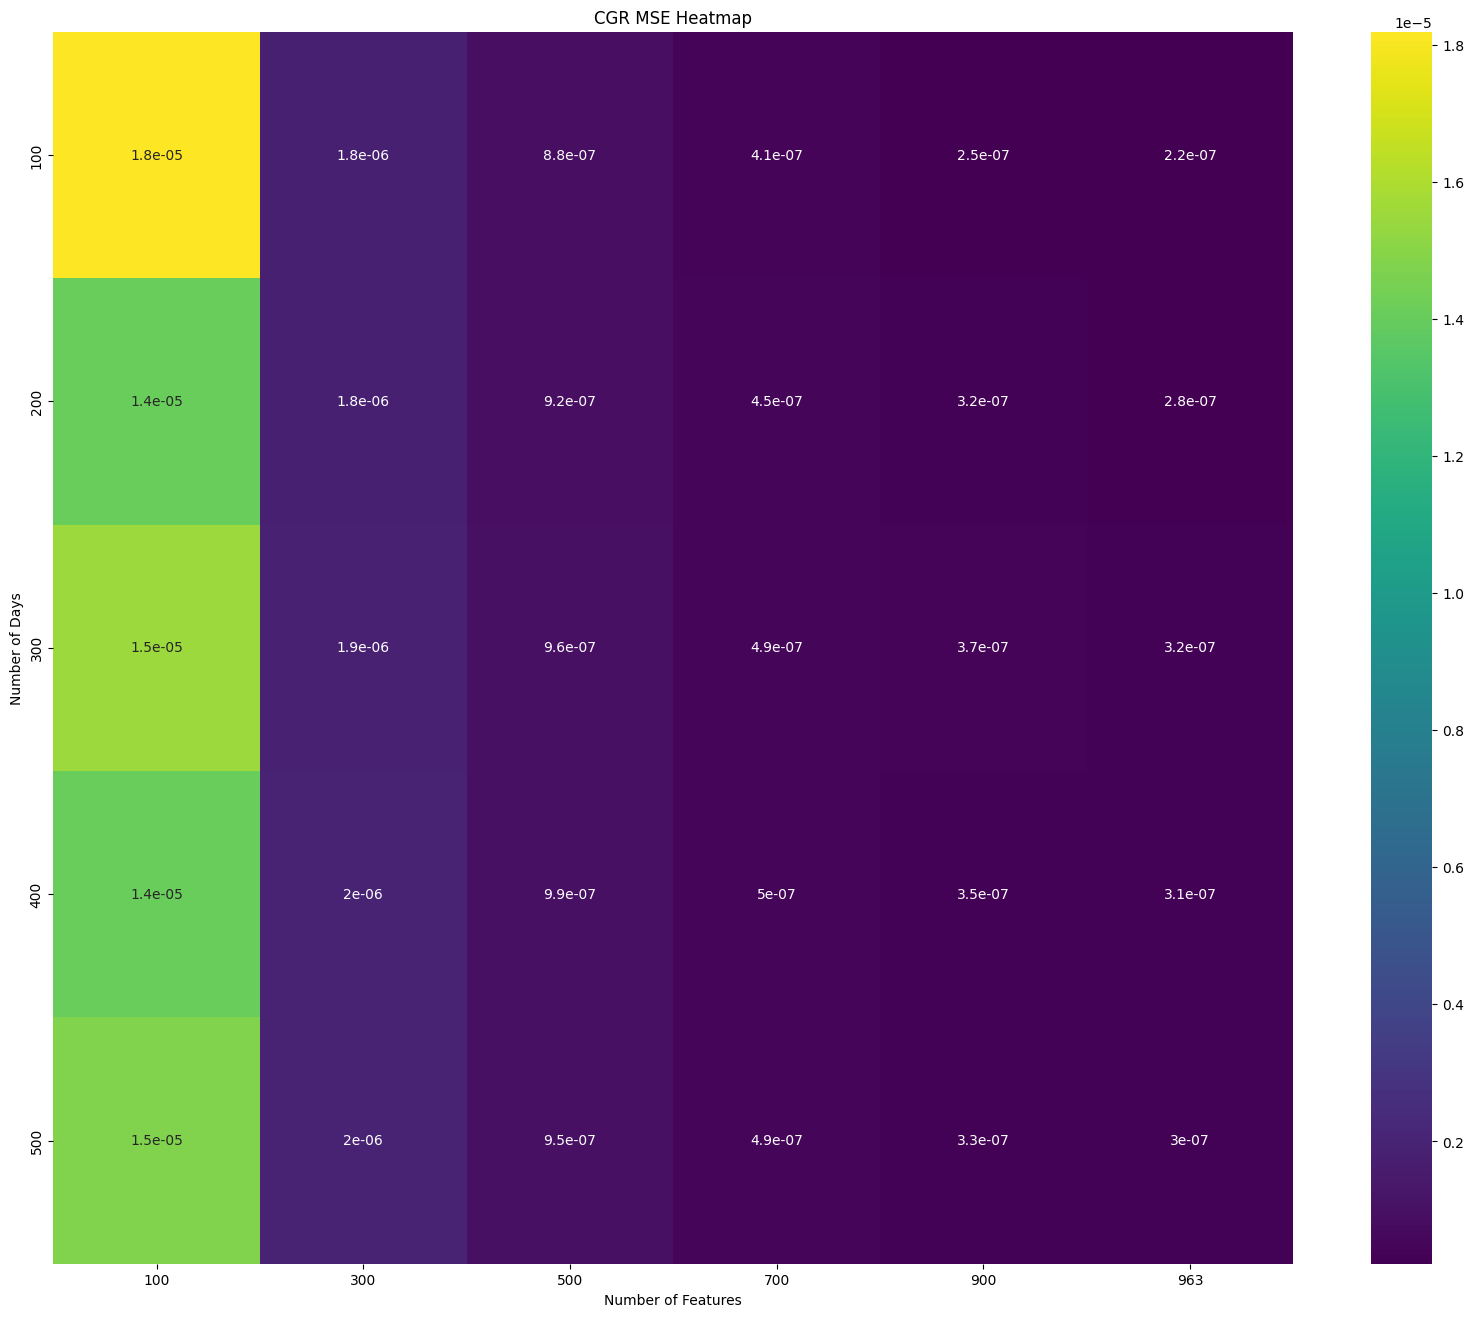

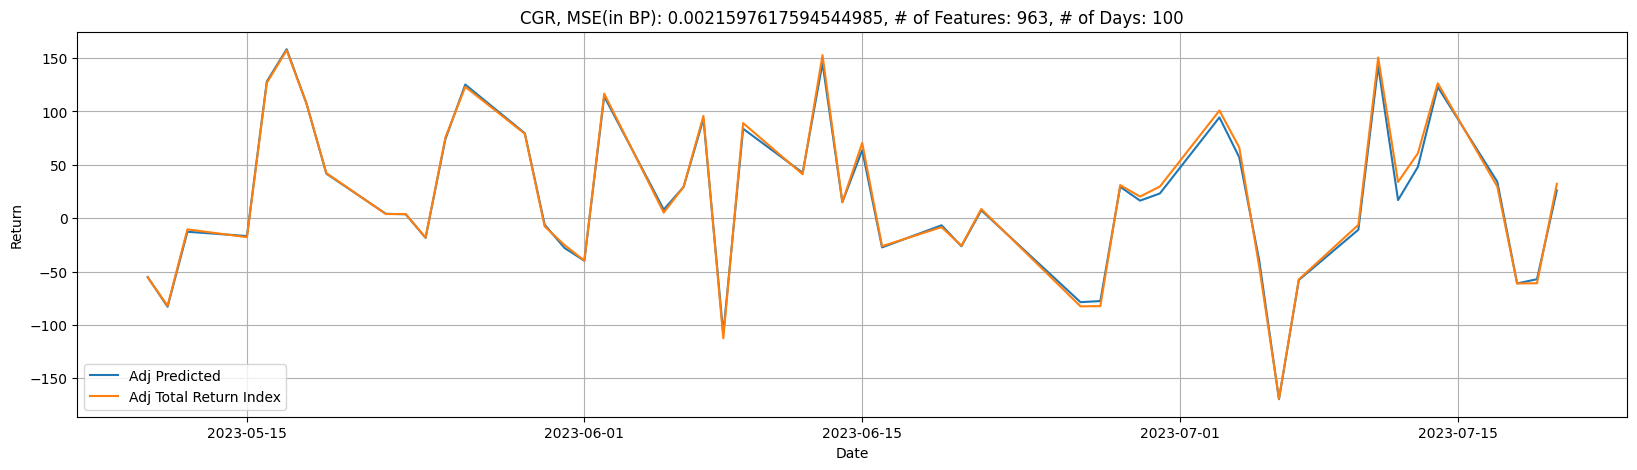

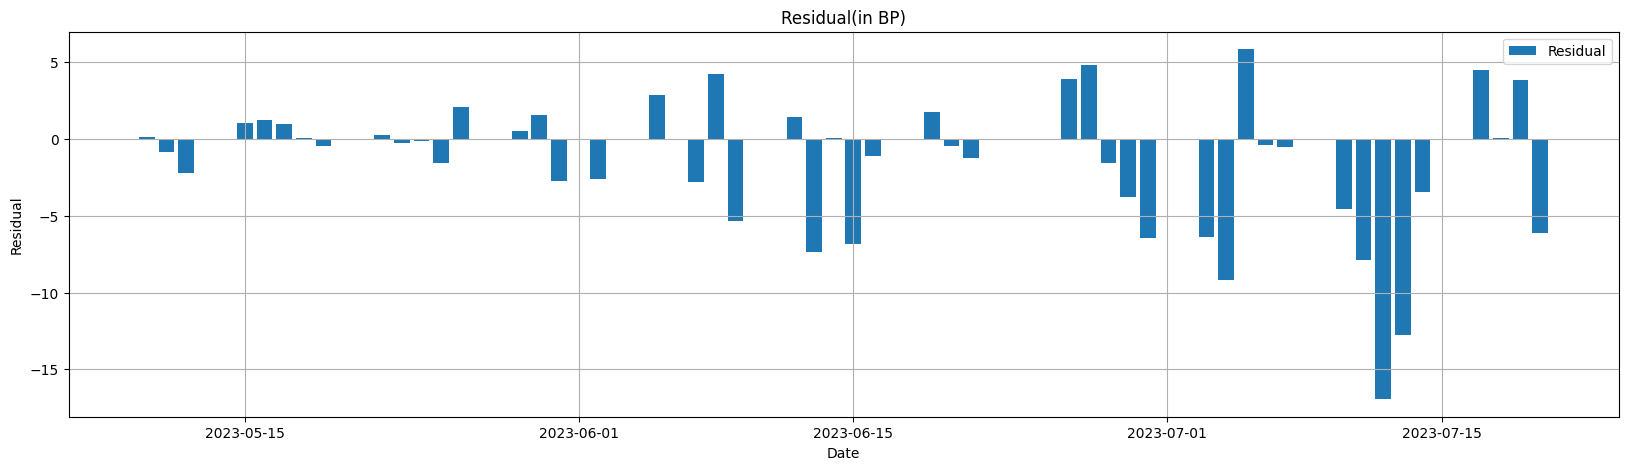

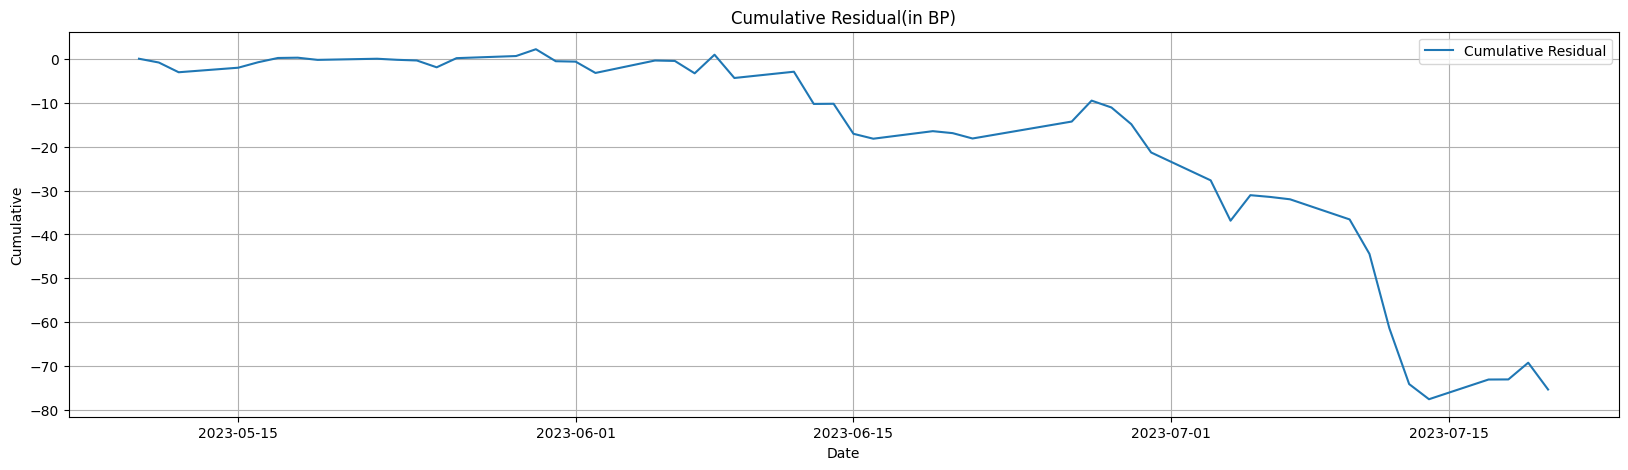

Weights
2330  0.273686
3653  0.001271
3413  0.000411
2338  0.000545
6770  0.002878
...        ...
2461  0.000109
6442  0.000136
9935  0.000098
1582  0.000165
1110  0.000172

[963 rows x 1 columns]

0.0016943782635096898


In [25]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].sum(axis = 0) / len(weights[:num_of_day])

        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
        )
        bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]
    
        optmized_weights = Optimizer(X_train,y_train,initial_weights,
                                    constraints, bounds, 
                                    method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

        optimization = (optmized_weights * X_test).sum(axis = 1)


        mse = mean_squared_error(y_test, optimization)
        print(f'Number of Days: {num_of_day}, Number of Features: {num_of_feature}, MSE: {mse}, Nan in weights: {initial_weights.isna().any()}')

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"CGR MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].sum(axis = 0) / len(weights[:num_of_day])

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
)
bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]

optmized_weights = Optimizer(X_train,y_train,initial_weights,
                            constraints, bounds, 
                            method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

optimization = (optmized_weights * X_test).sum(axis = 1)


mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'CGR, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(optmized_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

# ***Update***

## ***benchmark 01***

Number of Days: 100, Number of Features: 100, MSE: 2.1633096248544084e-06, Nan in weights: False
Number of Days: 200, Number of Features: 100, MSE: 2.1633096248544105e-06, Nan in weights: False
Number of Days: 300, Number of Features: 100, MSE: 2.1633096248544105e-06, Nan in weights: False
Number of Days: 400, Number of Features: 100, MSE: 2.1633096248544105e-06, Nan in weights: False
Number of Days: 500, Number of Features: 100, MSE: 2.1633096248544105e-06, Nan in weights: False
Number of Days: 100, Number of Features: 300, MSE: 3.468043136034752e-07, Nan in weights: False
Number of Days: 200, Number of Features: 300, MSE: 3.468043136034752e-07, Nan in weights: False
Number of Days: 300, Number of Features: 300, MSE: 3.468043136034752e-07, Nan in weights: False
Number of Days: 400, Number of Features: 300, MSE: 3.468043136034752e-07, Nan in weights: False
Number of Days: 500, Number of Features: 300, MSE: 3.468043136034752e-07, Nan in weights: False
Number of Days: 100, Number of Feat

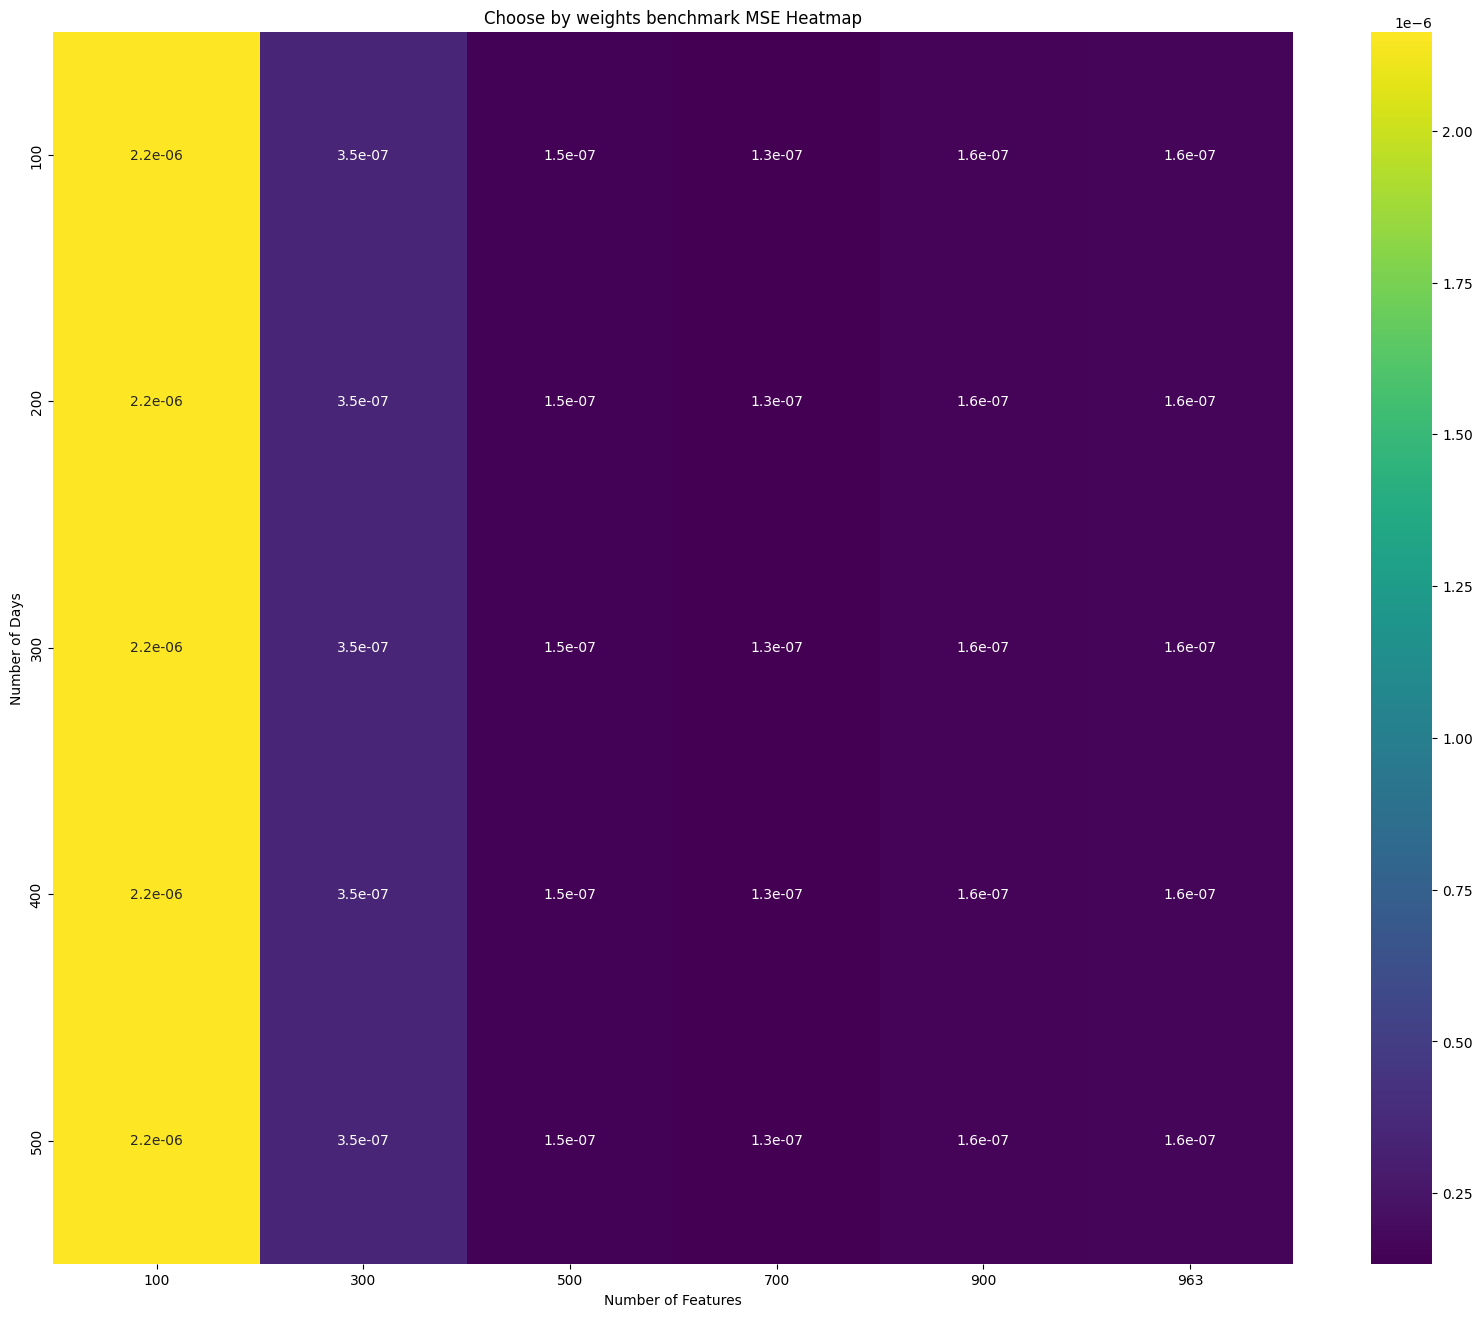

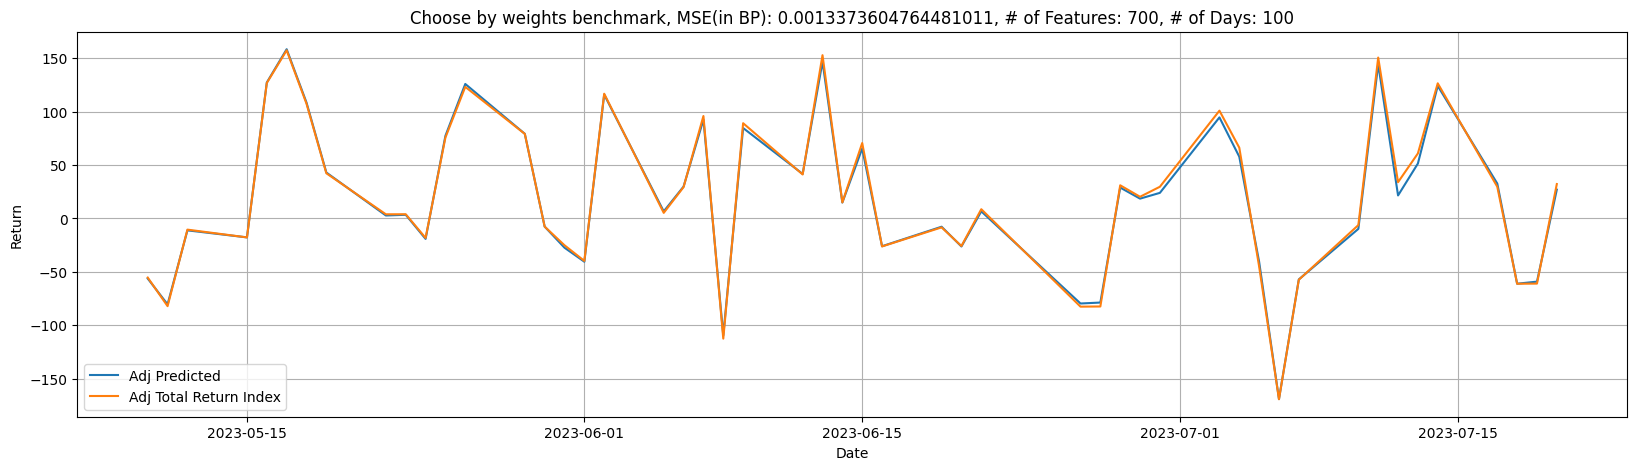

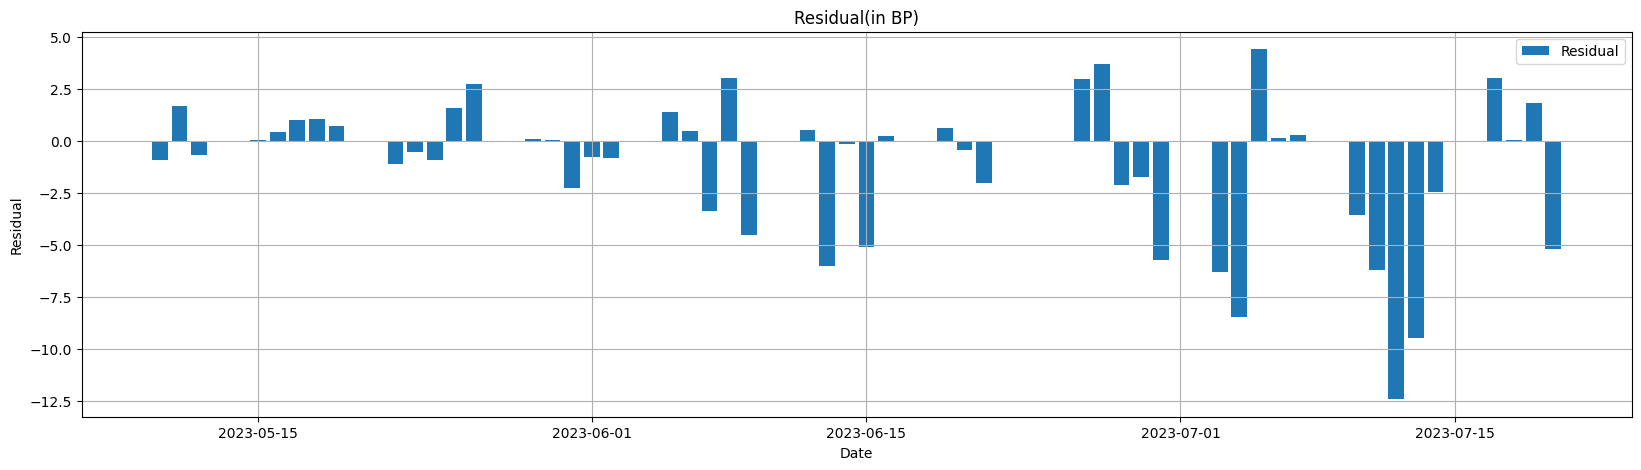

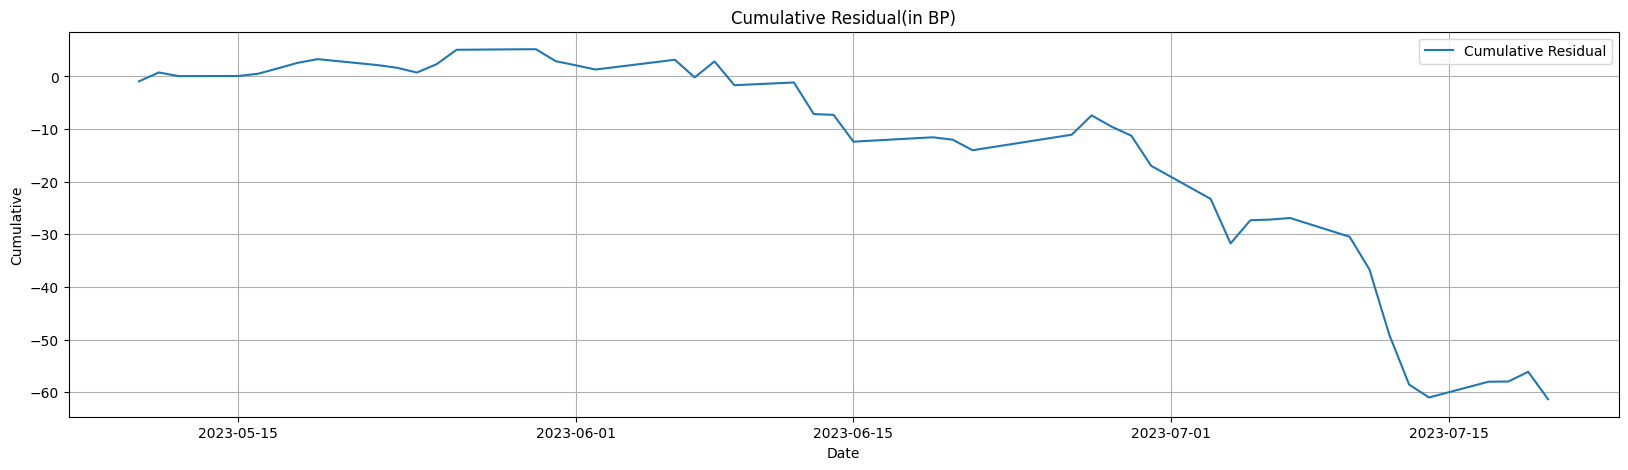

Weights
2330     NaN
2317     NaN
2454     NaN
2412     NaN
2308     NaN
...      ...
6792     NaN
6861     NaN
3338     NaN
6283     NaN
2399     NaN

[700 rows x 1 columns]

0.0012403678953093397


In [35]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].iloc[-1]
        initial_weights.fillna(0, inplace=True)
        # print(initial_weights.sum())
        optimization = (initial_weights * X_test).sum(axis = 1)

        mse = mean_squared_error(y_test, optimization)
        print(f'Number of Days: {num_of_day}, Number of Features: {num_of_feature}, MSE: {mse}, Nan in weights: {initial_weights.isna().any()}')

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Choose by weights benchmark MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[TX_Weights.columns[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[TX_Closing.columns[:num_of_feature]].loc[final_date]
weights = (TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].iloc[-1]
initial_weights.fillna(0, inplace=True)

optimization = (initial_weights * X_test).sum(axis = 1)

mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Choose by weights benchmark, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(initial_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## ***benchmark 02***

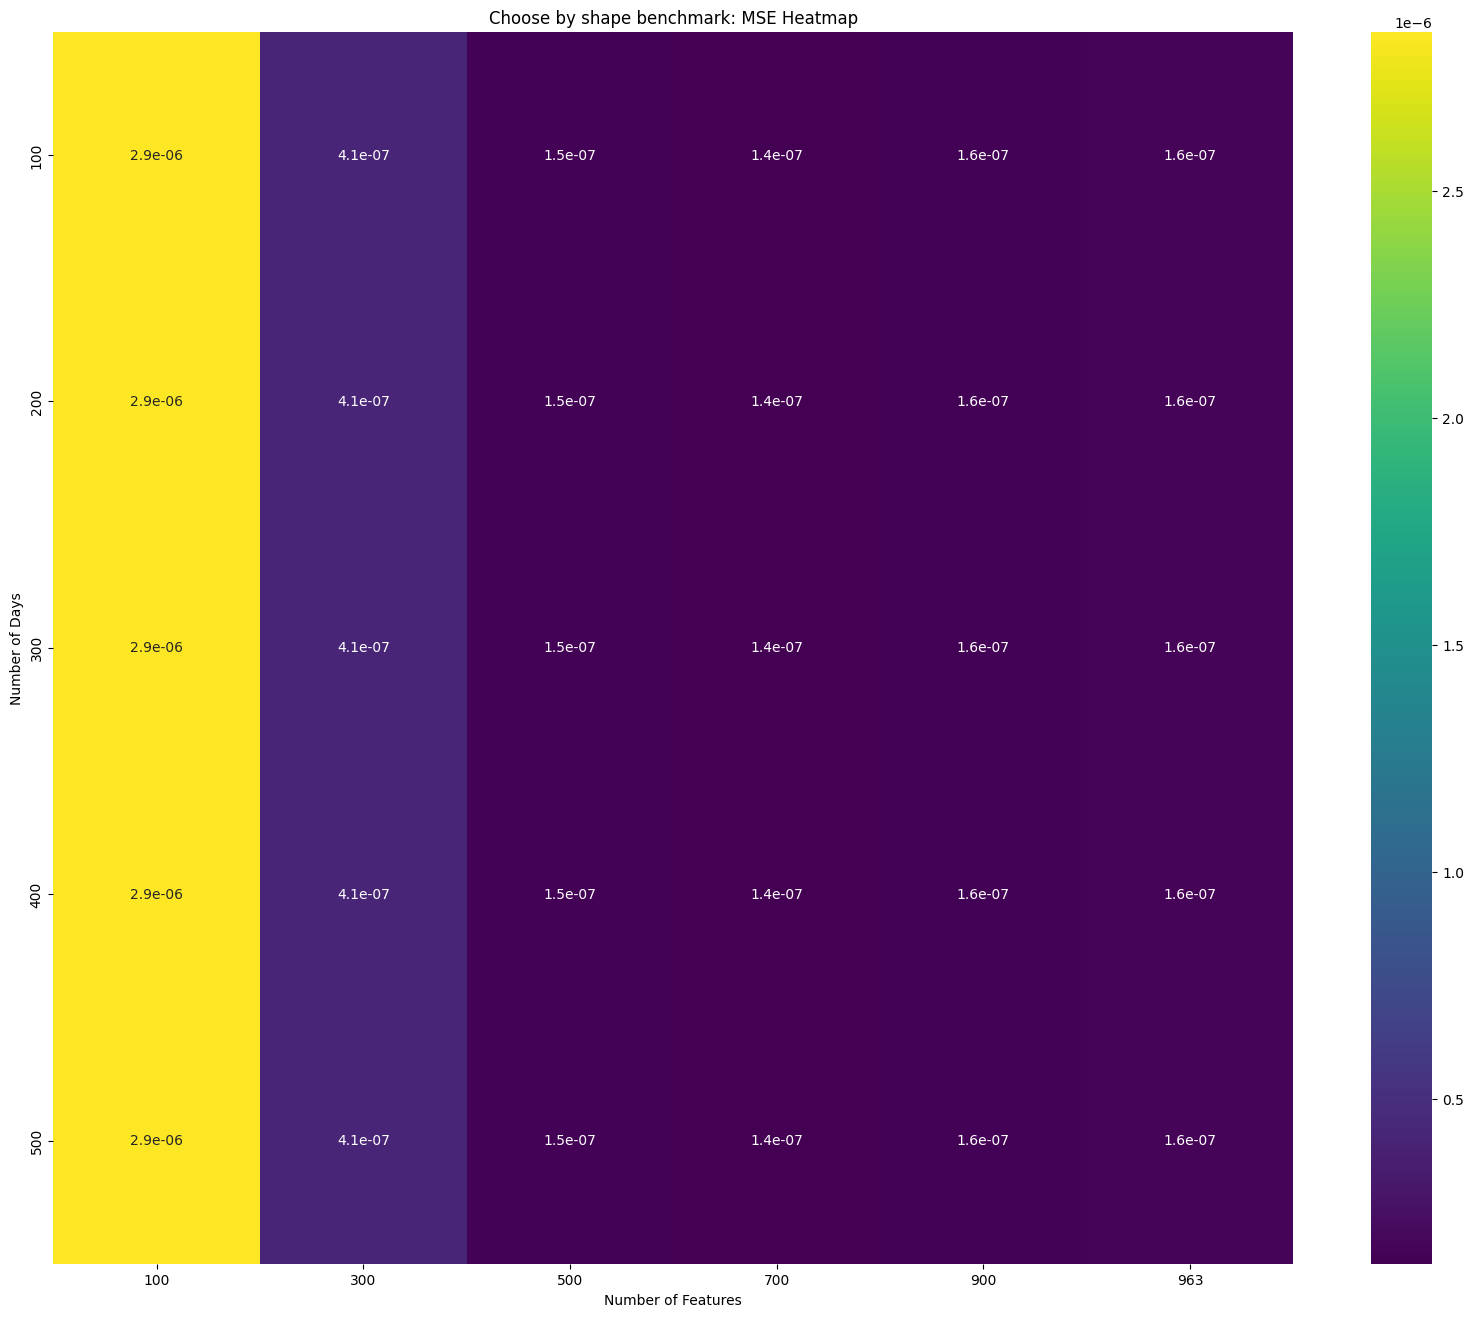

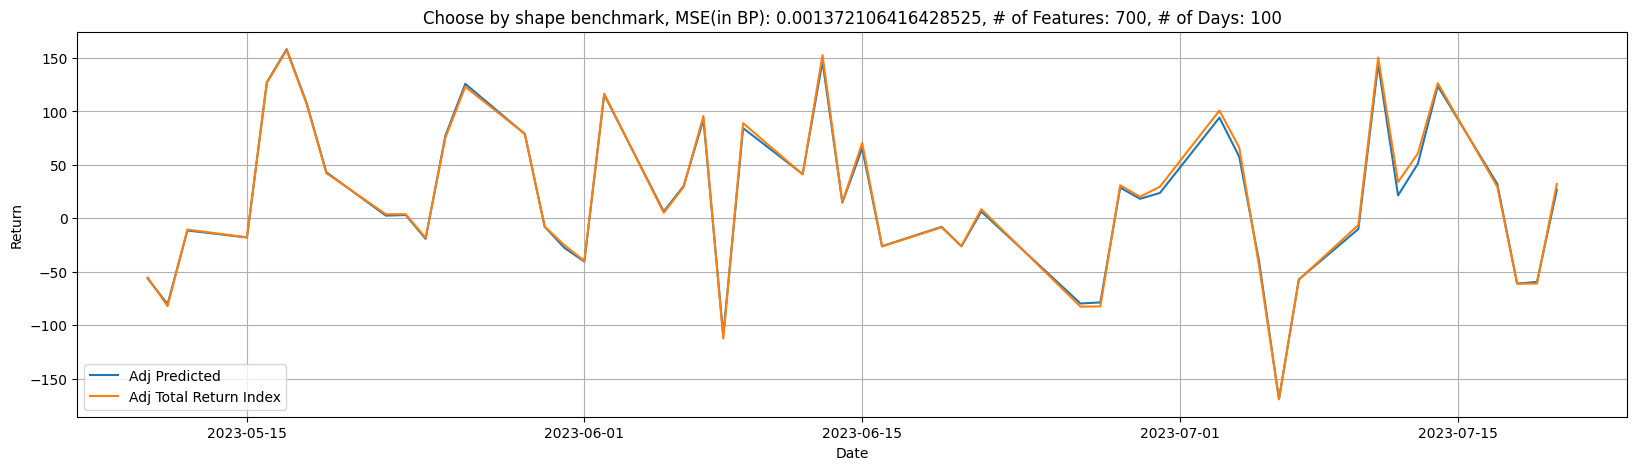

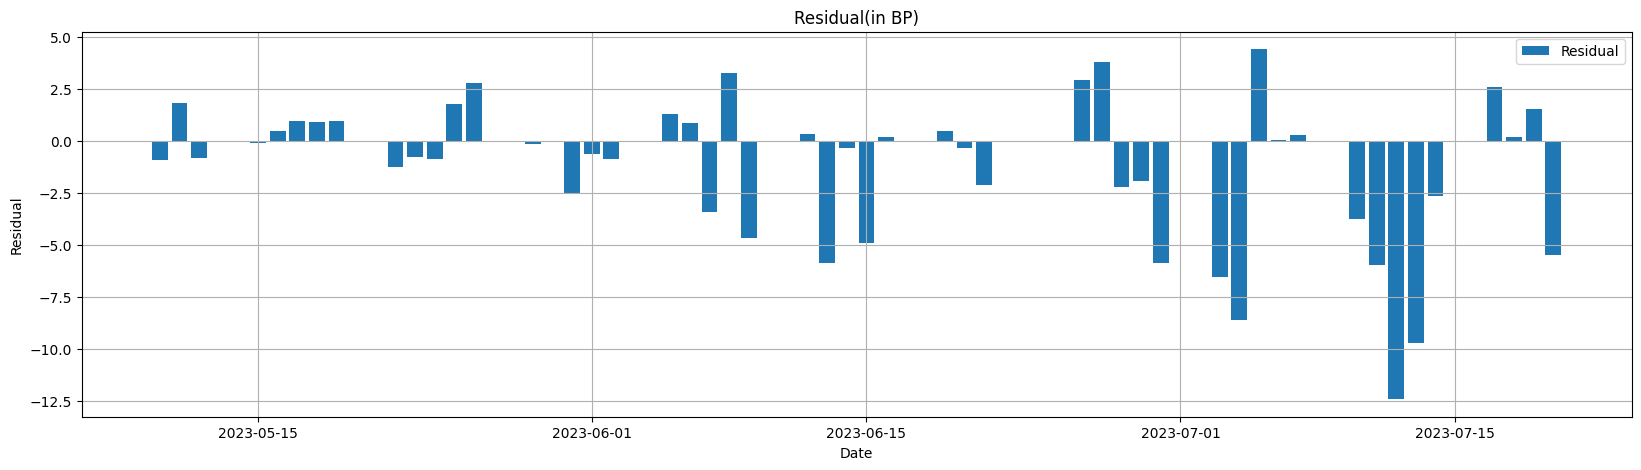

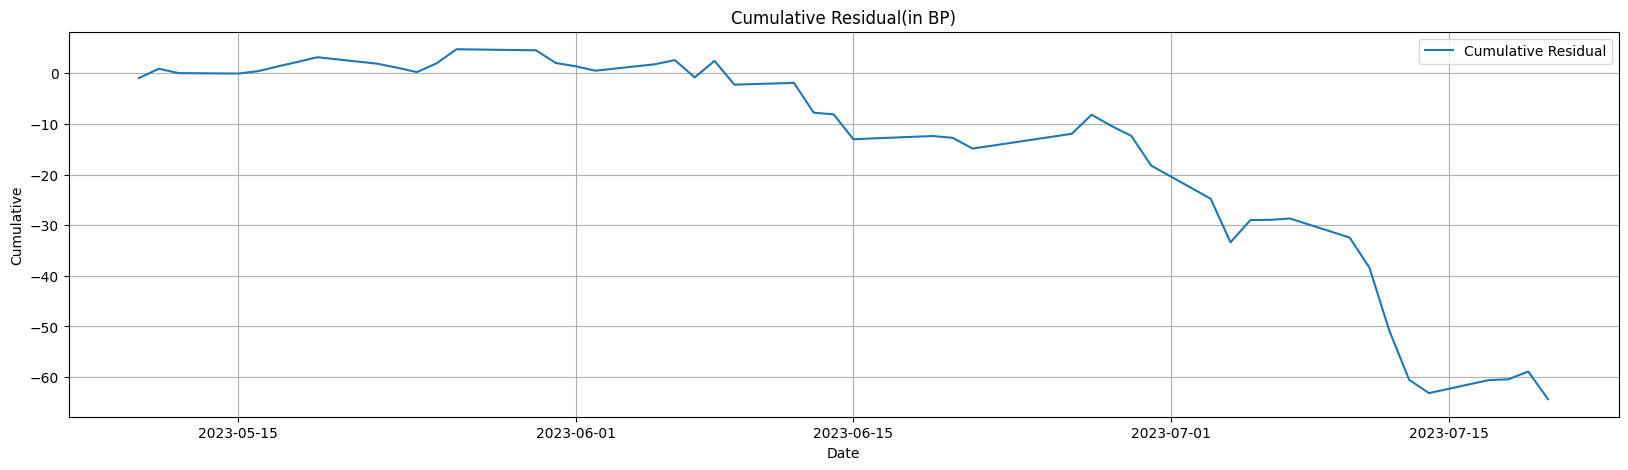

Weights
2330     NaN
2317     NaN
2454     NaN
2412     NaN
2308     NaN
...      ...
2509     NaN
2506     NaN
5515     NaN
4722     NaN
5546     NaN

[700 rows x 1 columns]

0.0012415150280068346


In [40]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


        E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].iloc[-1]
        initial_weights.fillna(0, inplace=True)

        optimization = (initial_weights * X_test).sum(axis = 1)


        mse = mean_squared_error(y_test, optimization)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Choose by shape benchmark: MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_list[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_list[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_list[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


E_closing = TX_Closing[E_list[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_list[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_list[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_list[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_list[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_list[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].iloc[-1]
initial_weights.fillna(0, inplace=True)

optimization = (initial_weights * X_test).sum(axis = 1)

# in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test
# in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array((optmized_weights * X_train).sum(axis = 1)), label='Adj Predicted')
# plt.plot(y_train.index, 10000 * np.array(y_train) , label='Adj Total Return Index')
# plt.legend()
# plt.title(f'In-sample Linear Regression, MSE(in BP): {in_sample_mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
# plt.xlabel('Date')
# plt.ylabel('Return')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.bar(y_train.index, 10000 * np.array(in_sample_residual), label='Residual')
# plt.legend()
# plt.title(f'Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('In-Sample Residual')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array(in_sample_residual).cumsum(), label='Cumulative Residual')
# plt.legend()
# plt.title(f'In-Sample Cumulative Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('Cumulative')
# plt.grid()
# plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Choose by shape benchmark, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(initial_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## ***benchmark 03***

Number of Days: 100, Number of Features: 100, MSE: 1.0123759589312818e-05, Nan in weights: False
Number of Days: 200, Number of Features: 100, MSE: 1.0238688501850217e-05, Nan in weights: False
Number of Days: 300, Number of Features: 100, MSE: 1.025859953159018e-05, Nan in weights: False
Number of Days: 400, Number of Features: 100, MSE: 1.0260771480167993e-05, Nan in weights: False
Number of Days: 500, Number of Features: 100, MSE: 1.0201683517910618e-05, Nan in weights: False
Number of Days: 100, Number of Features: 300, MSE: 5.6813005283609075e-06, Nan in weights: False
Number of Days: 200, Number of Features: 300, MSE: 5.790107455306057e-06, Nan in weights: False
Number of Days: 300, Number of Features: 300, MSE: 5.737019396512753e-06, Nan in weights: False
Number of Days: 400, Number of Features: 300, MSE: 5.78663782696483e-06, Nan in weights: False
Number of Days: 500, Number of Features: 300, MSE: 5.70031038432762e-06, Nan in weights: False
Number of Days: 100, Number of Featur

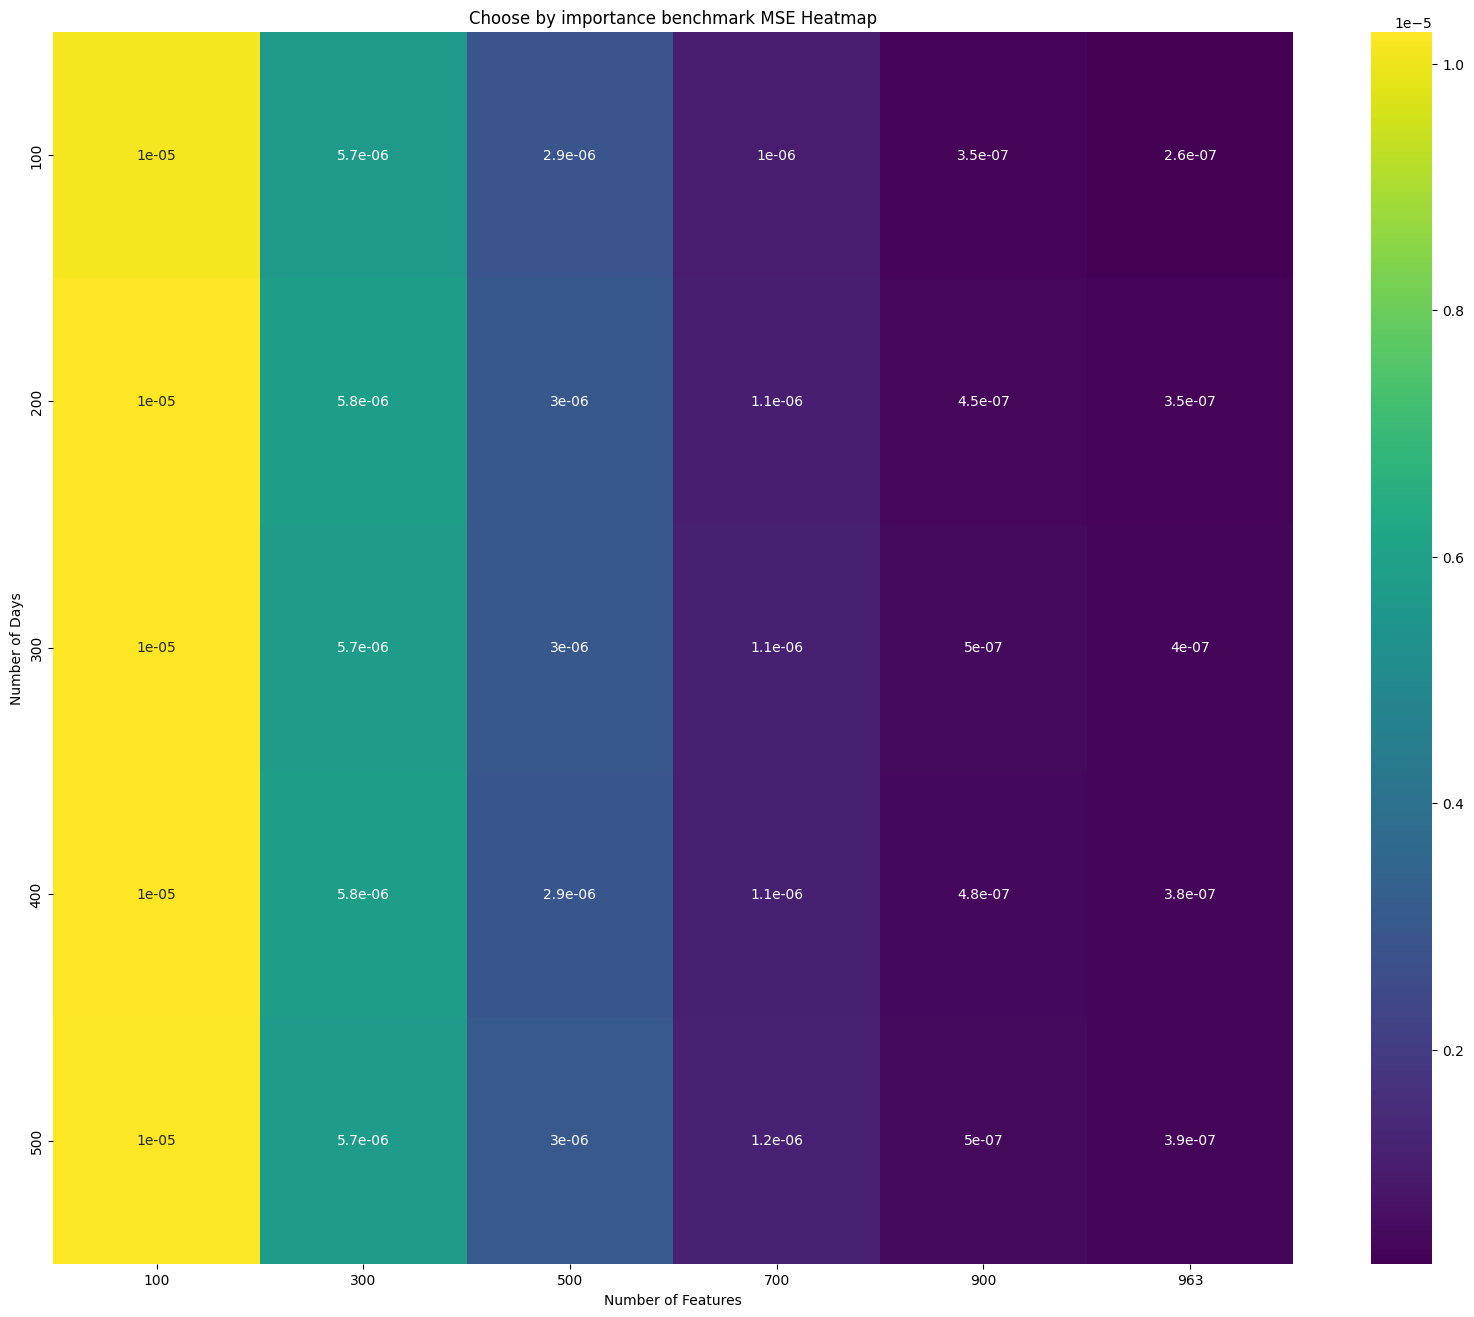

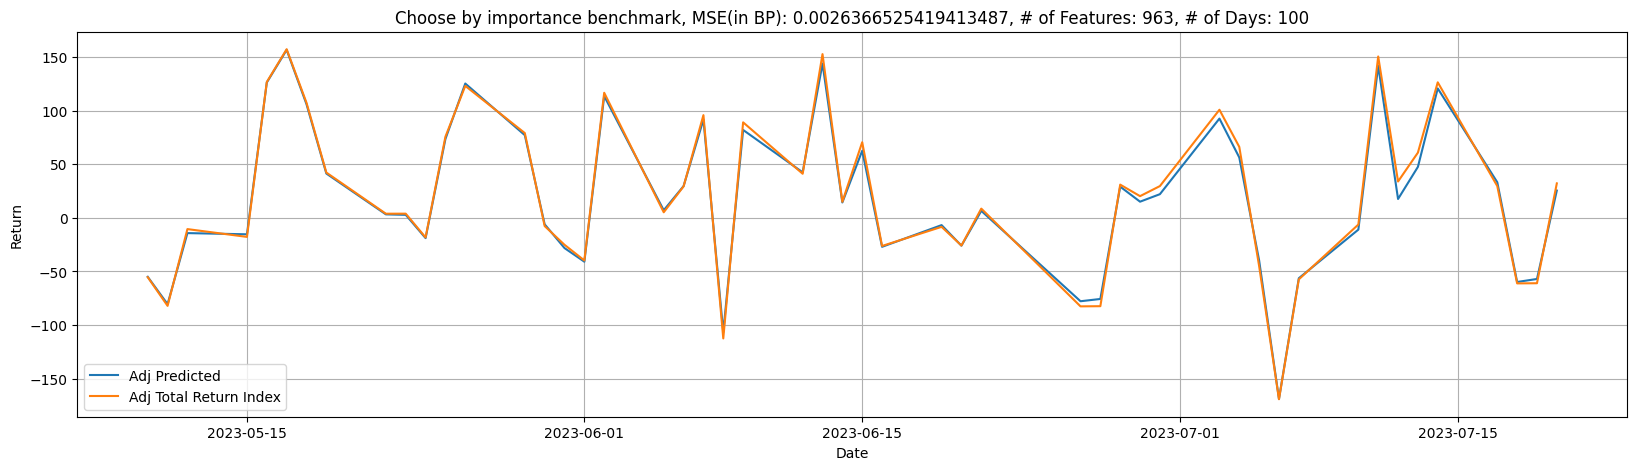

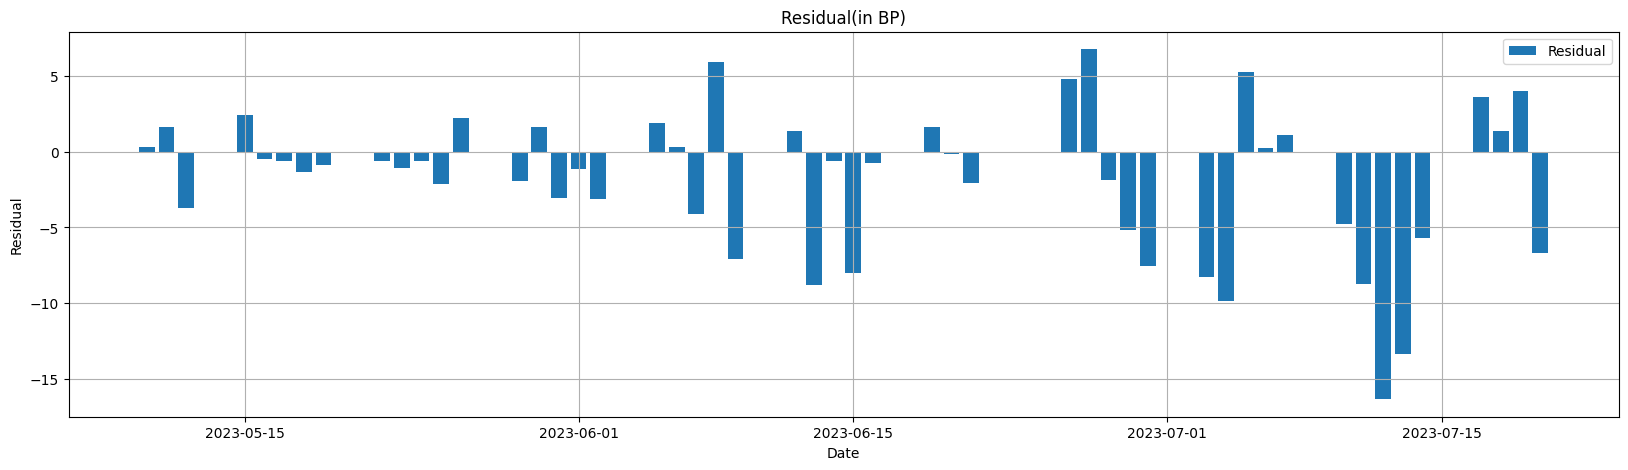

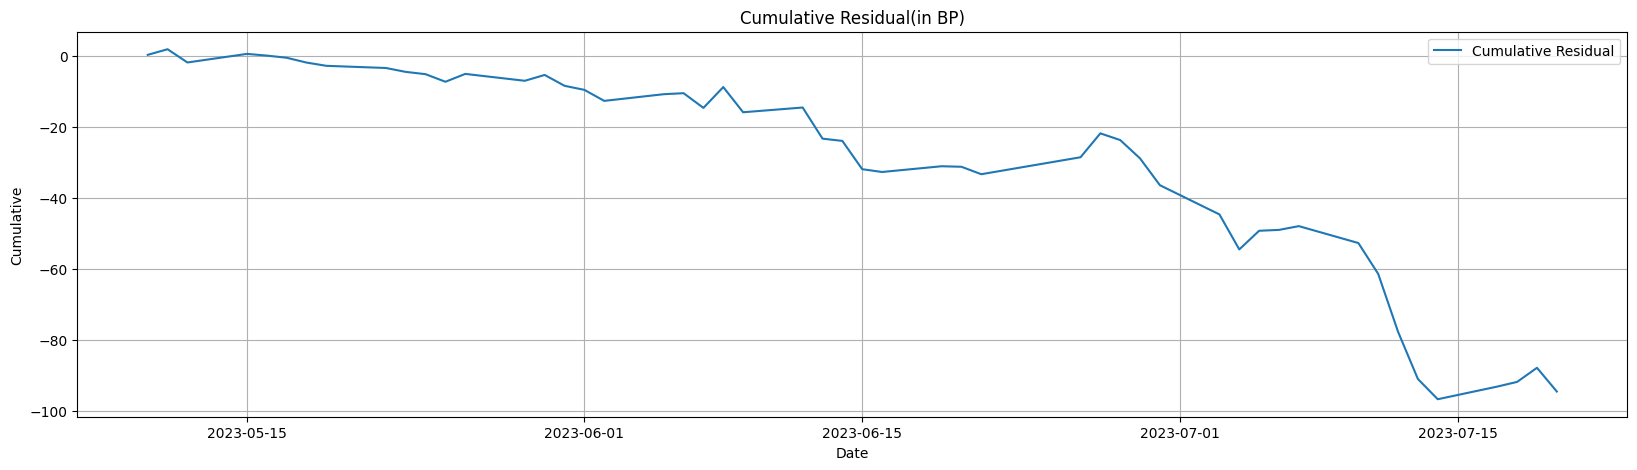

Weights
2330  0.273657
3653  0.001175
3413  0.000368
2338  0.000454
6770  0.002776
...        ...
2461  0.000070
6442  0.000073
9935  0.000067
1582  0.000161
1110  0.000223

[963 rows x 1 columns]

0.0016310655273306912


In [41]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
        weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1
            closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id
        closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
        weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].sum(axis = 0) / len(weights[:num_of_day])
        initial_weights = initial_weights.fillna(0)

        optimization = (initial_weights * X_test).sum(axis = 1)


        mse = mean_squared_error(y_test, optimization)
        print(f'Number of Days: {num_of_day}, Number of Features: {num_of_feature}, MSE: {mse}, Nan in weights: {initial_weights.isna().any()}')

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Choose by importance benchmark MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]
weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days:]

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1
    closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    weights = TX_Weights[importance_df["Feature"].values[:num_of_feature]].iloc[-need_days-count:]
    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id
closing_px = TX_Closing[importance_df["Feature"].values[:num_of_feature]].loc[final_date]
weights = (TX_Weights[importance_df["Feature"].values[:num_of_feature]].loc[final_date]).div(TX_Weights[TX_Weights.columns[:num_of_feature]].loc[final_date].sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].sum(axis = 0) / len(weights[:num_of_day])
initial_weights = initial_weights.fillna(0)

optimization = (initial_weights * X_test).sum(axis = 1)


mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Choose by importance benchmark, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(initial_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

# Importance with shape

In [50]:
X_E = calculate_log_returns(TX_Closing[E_list].dropna())[1:]
y_E = ((TX_Weights[X_E.columns].loc[X_E.index]) * X_E).sum(axis = 1)

# 创建随机森林回归器实例
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_E, y_E)

nl = []
for i in X_E.columns:
    nl.append(name_l.loc[i][0])

# 输出特征重要性
E_importance_df = pd.DataFrame({'Feature': X_E.columns, "Name": nl
                            ,"Importance": rf.feature_importances_}).sort_values(by='Importance', ascending=False)
display(E_importance_df.head(5))

Feature Name  Importance
0      2330  台積電    0.717298
313    6695   芯鼎    0.014532
105    6213   聯茂    0.013746
282    3356   奇偶    0.007593
334    8104   錸寶    0.006826

In [49]:
X_F = calculate_log_returns(TX_Closing[F_list].dropna())[1:]
y_F = ((TX_Weights[X_F.columns].loc[X_F.index]) * X_F).sum(axis = 1)

# 创建随机森林回归器实例
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_F, y_F)

nl = []
for i in X_F.columns:
    nl.append(name_l.loc[i][0])

# 输出特征重要性
F_importance_df = pd.DataFrame({'Feature': X_F.columns, "Name": nl
                            ,"Importance": rf.feature_importances_}).sort_values(by='Importance', ascending=False)
display(F_importance_df.head(5))

Feature Name  Importance
0    2881  富邦金    0.259498
7    2880  華南金    0.154056
4    5880  合庫金    0.134619
1    2882  國泰金    0.120053
3    2891  中信金    0.083562

In [51]:
X_NEF = calculate_log_returns(TX_Closing[NEF_list].dropna())[1:]
y_NEF = ((TX_Weights[X_NEF.columns].loc[X_NEF.index]) * X_NEF).sum(axis = 1)

# 创建随机森林回归器实例
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_NEF, y_NEF)

nl = []
for i in X_NEF.columns:
    nl.append(name_l.loc[i][0])

# 输出特征重要性
NEF_importance_df = pd.DataFrame({'Feature': X_NEF.columns, "Name": nl
                            ,"Importance": rf.feature_importances_}).sort_values(by='Importance', ascending=False)
display(NEF_importance_df.head(5))

Feature  Name  Importance
98     6806  森崴能源    0.234574
443    2032    新鋼    0.086002
162    1718    中纖    0.052010
6      1326    台化    0.035379
383    2038    海光    0.031689

## Linear Regression

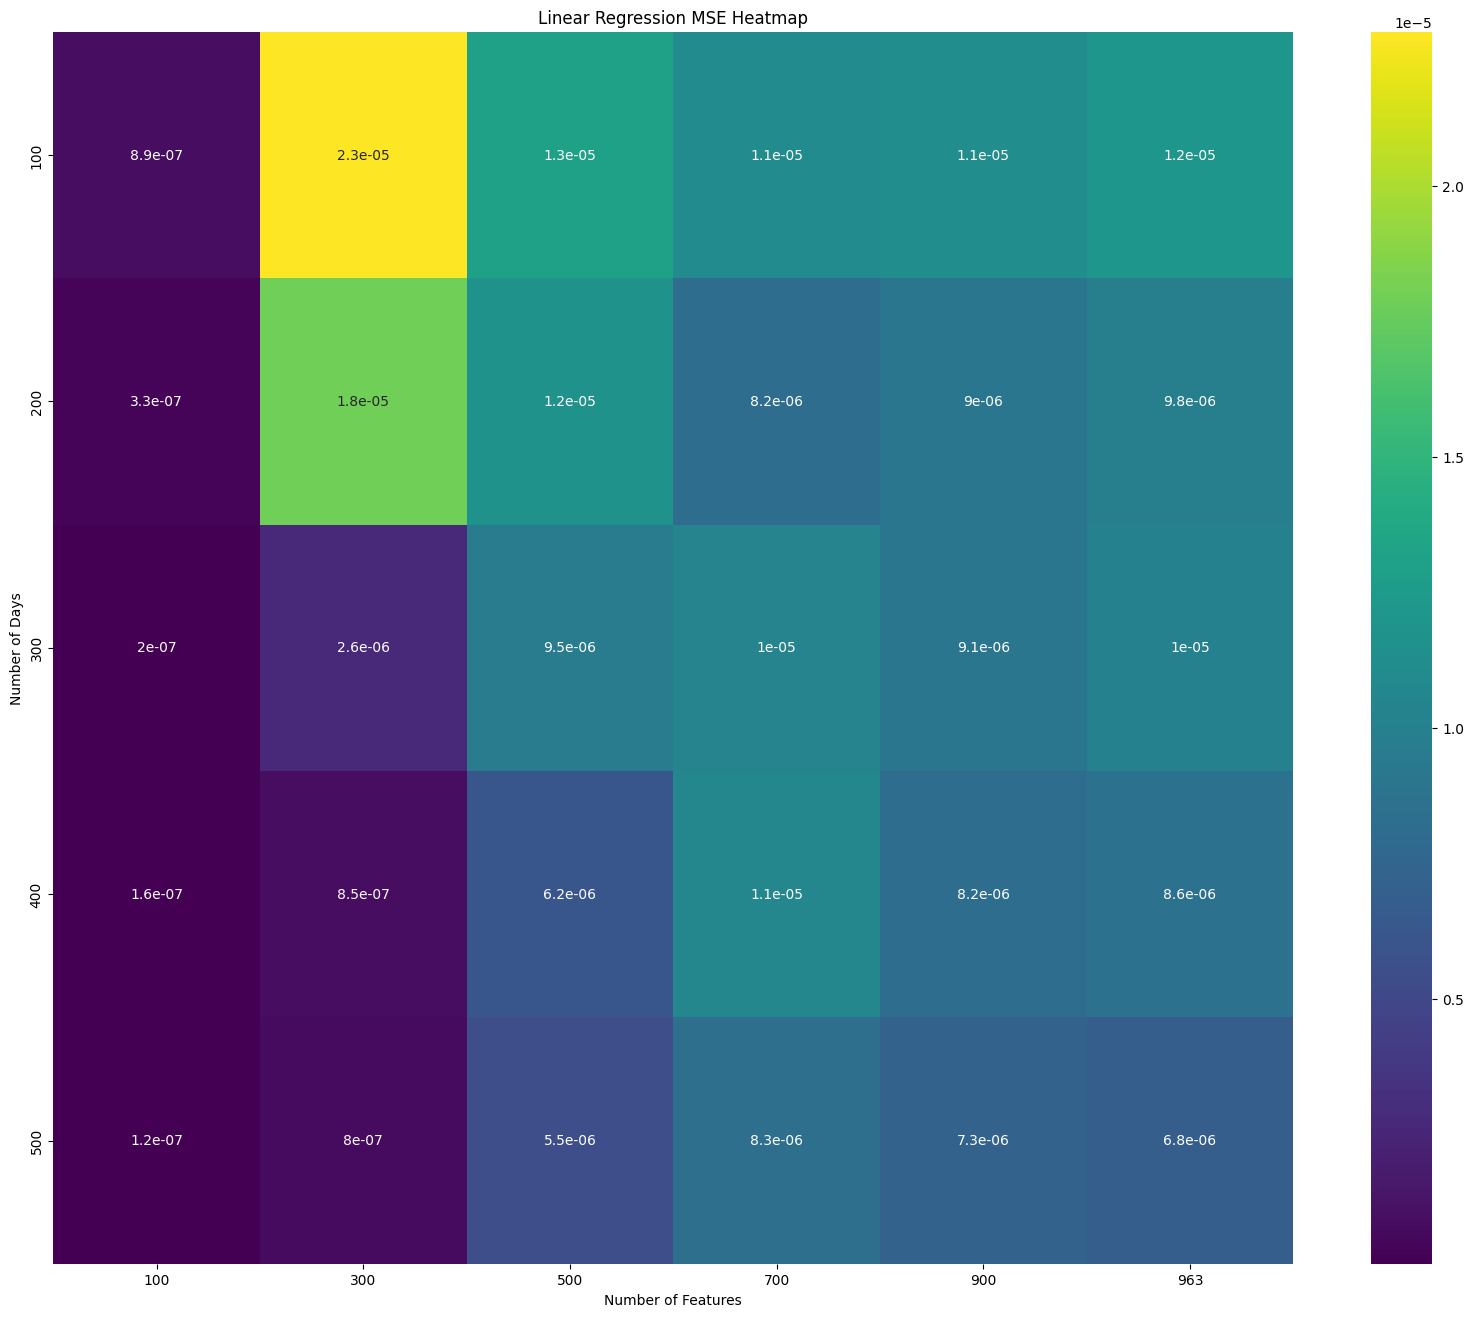

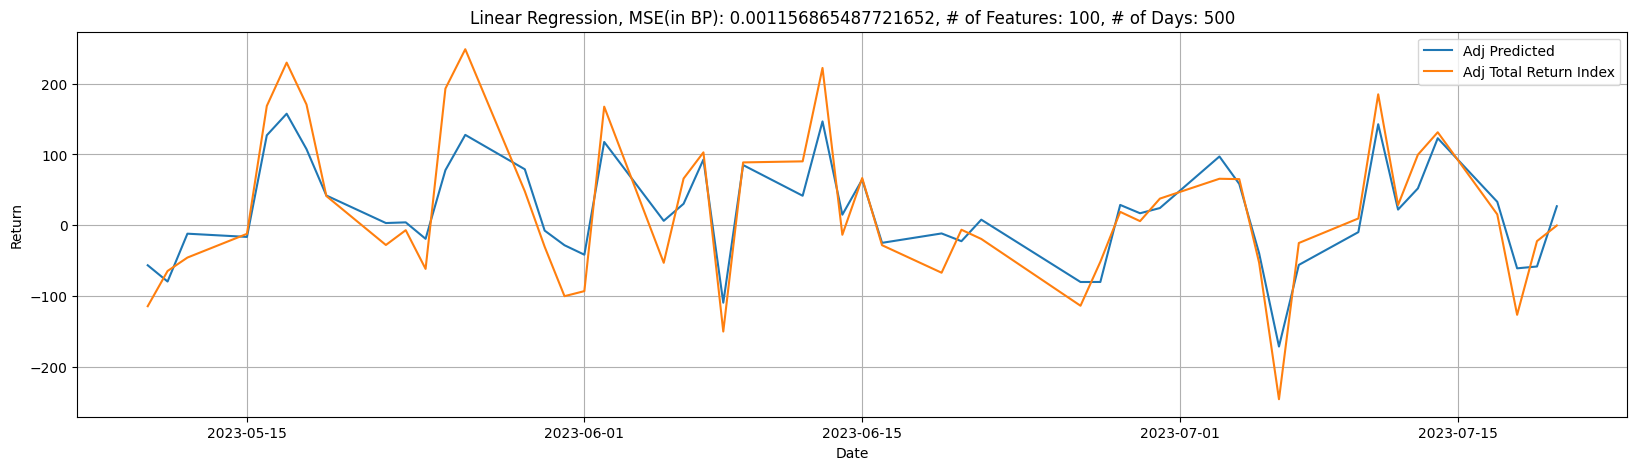

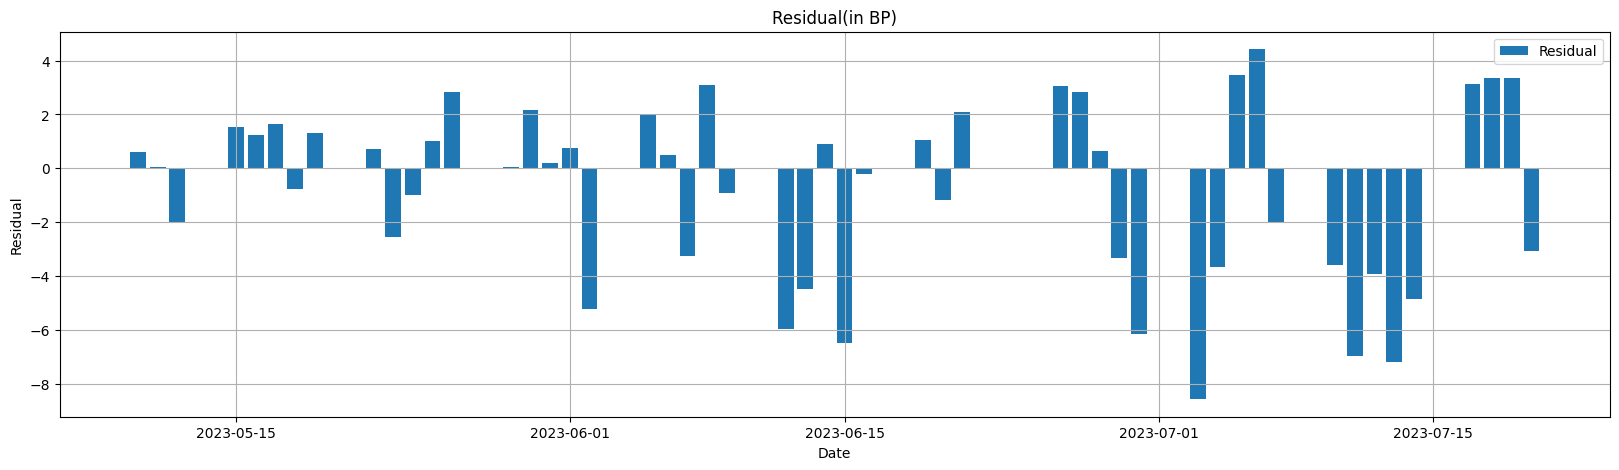

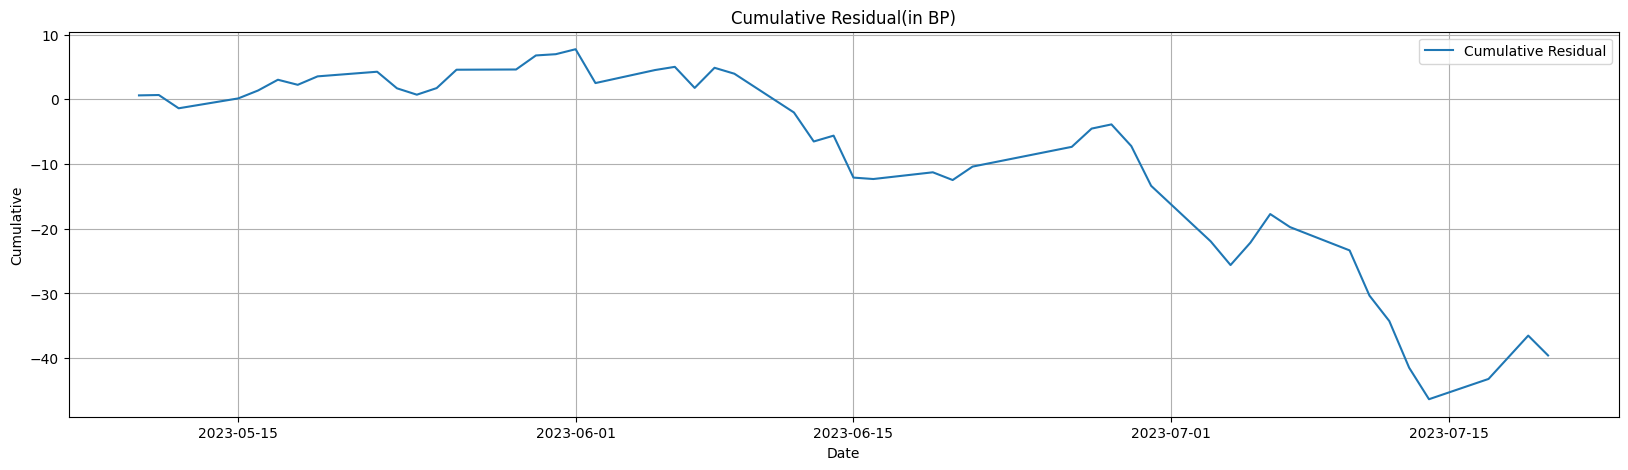

Weights
2330  0.635407
6213  0.000752
3356 -0.000684
8104  0.001446
6533  0.001151
...        ...
2101  0.001298
3705 -0.001290
4438  0.000571
1560  0.000335
9929 -0.001568

[96 rows x 1 columns]

0.000858135474951725


In [54]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id

        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = LinearRegression(fit_intercept = False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Linear Regression MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id

E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Linear Regression, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day:].sum(axis = 1)[-1],
                    index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## Lasso

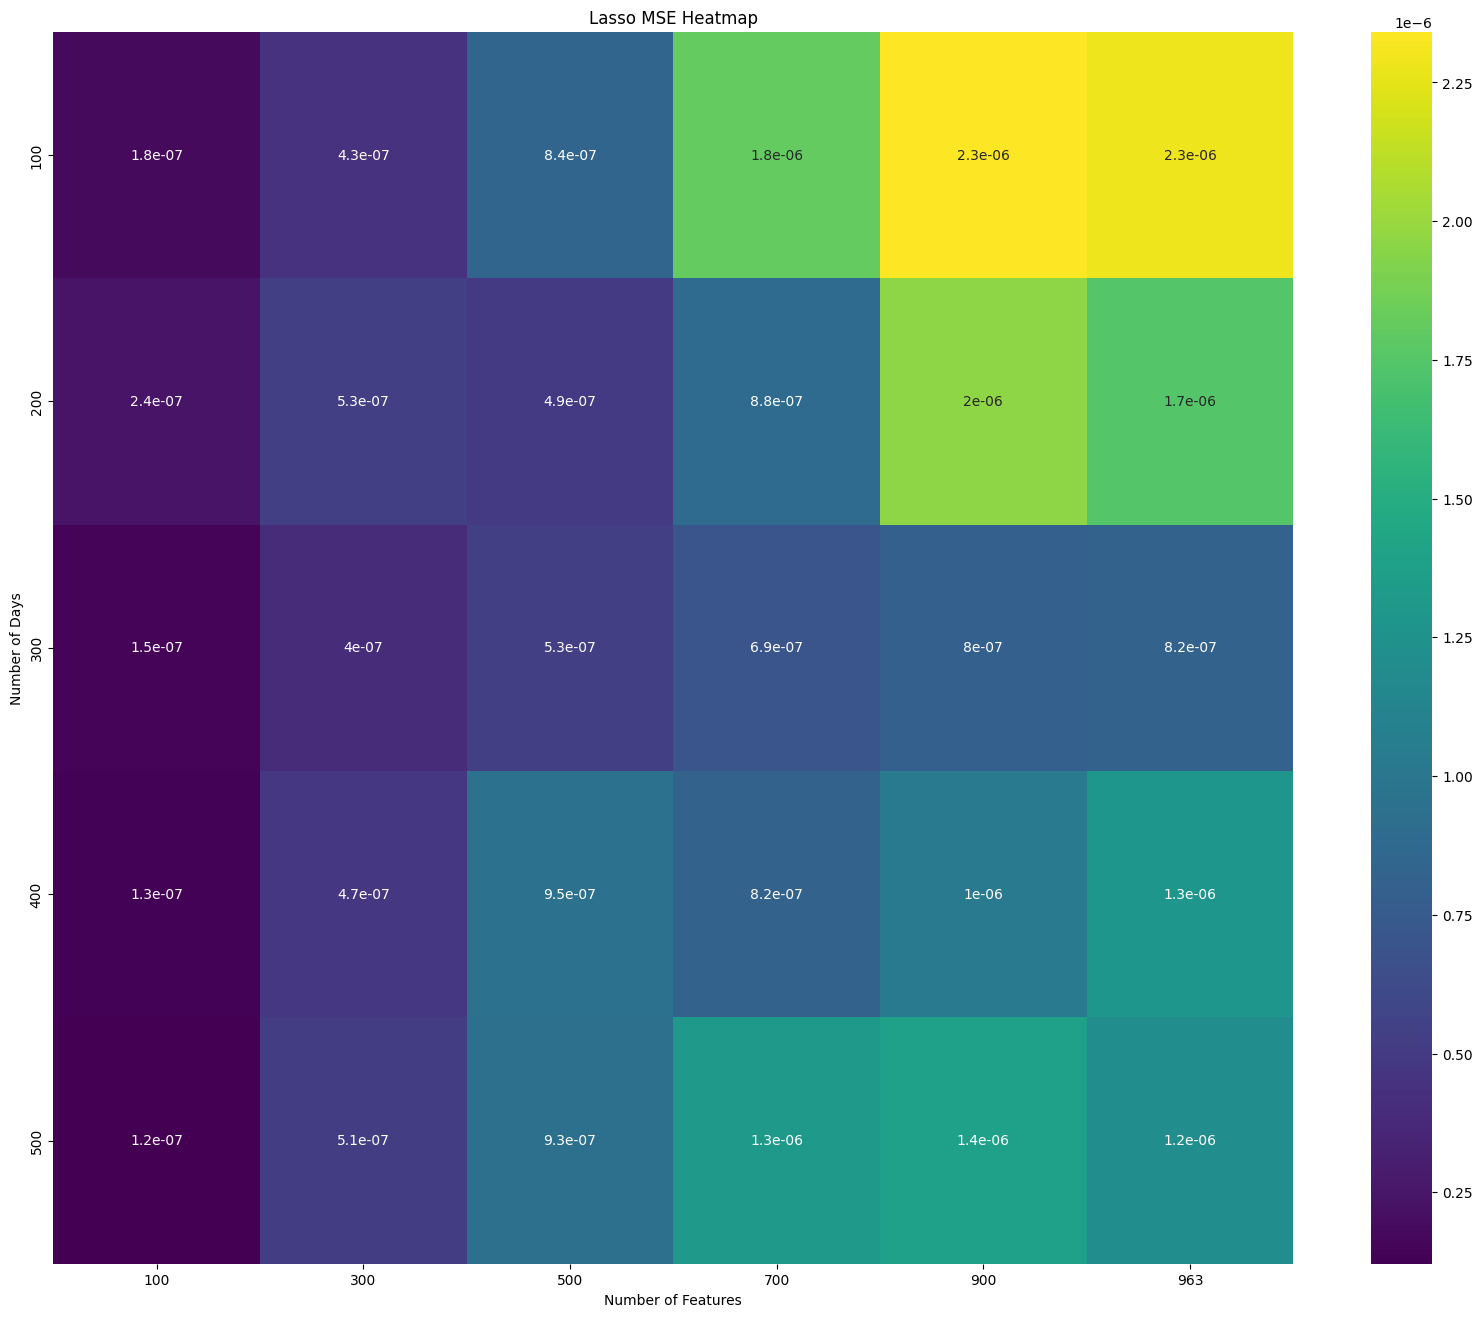

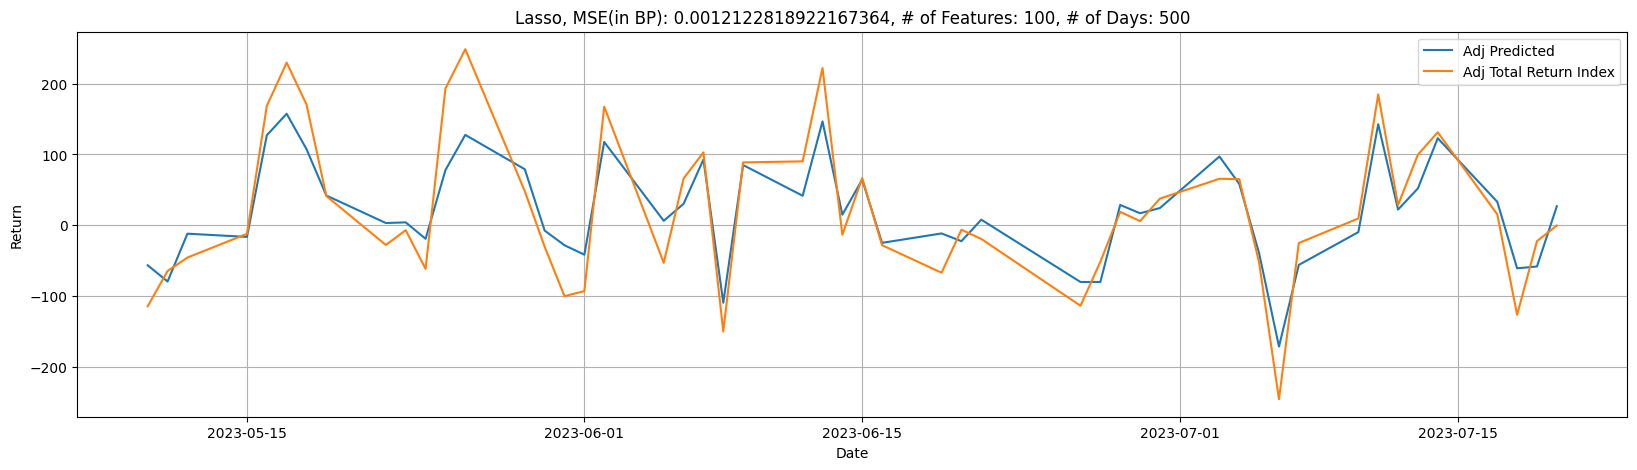

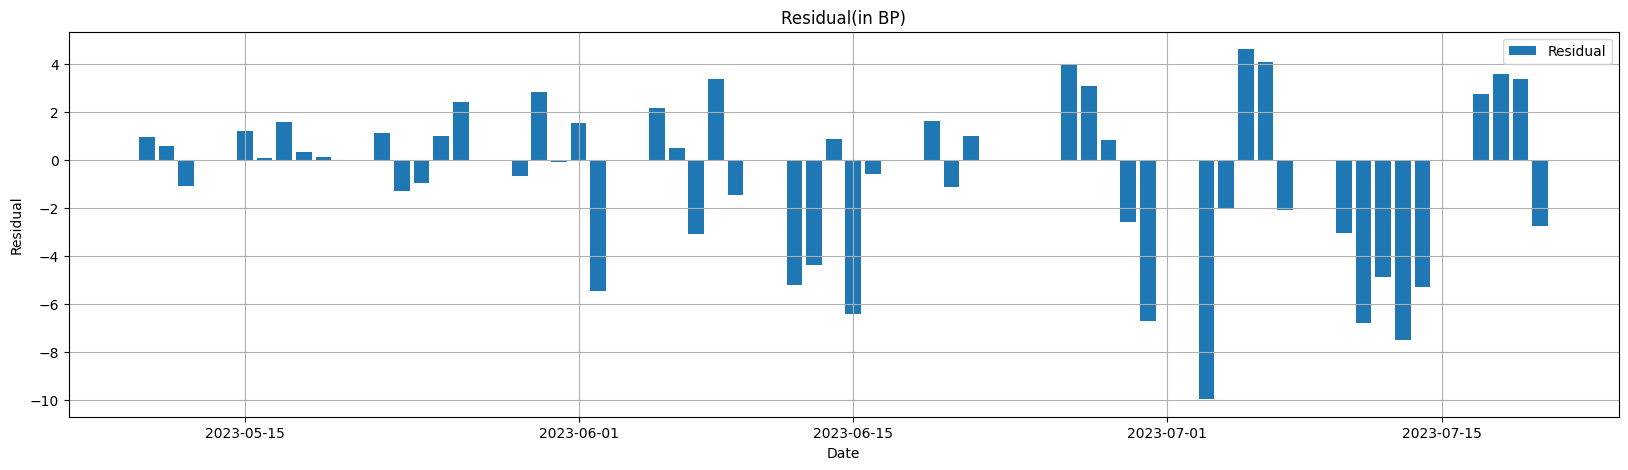

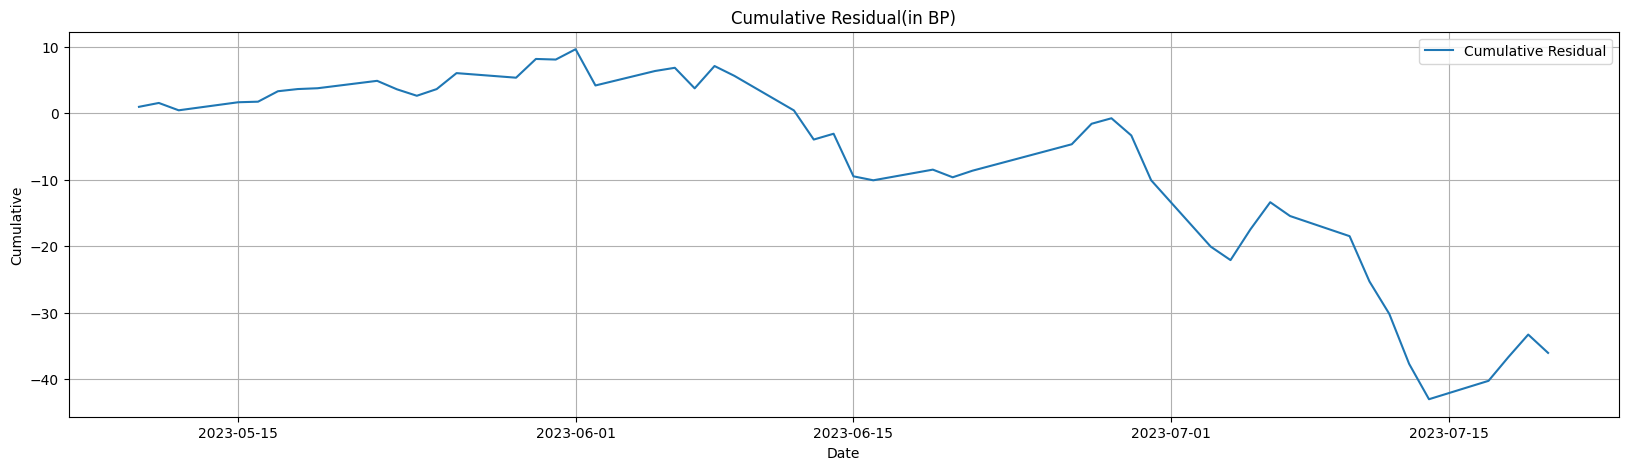

Weights
2330  0.635450
6213  0.000534
3356 -0.000246
8104  0.001478
6533  0.001272
...        ...
2101  0.001233
3705 -0.000000
4438  0.000167
1560  0.000240
9929 -0.000669

[96 rows x 1 columns]

0.000997503557169062


In [55]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()
alpha = 0.0000001


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
        final_good_id = good_stocks_id
        final_bad_id = bad_stocks_id

        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)  

        good_returns = returns[final_good_id]
        bad_returns = returns[final_bad_id]

        good_weights = weights[final_good_id]
        bad_weights = weights[final_bad_id]

        good_total_return_index = (good_returns * good_weights).sum(axis = 1)
        adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


        X_train = good_returns[1:num_of_day+1]
        y_train = adj_good_total_return_index[1:num_of_day+1]
        X_test = good_returns[num_of_day+1:]
        y_test = adj_good_total_return_index[num_of_day+1:]

        model = Lasso(fit_intercept = False, alpha = alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
        adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

        mse = mean_squared_error(adj_y_test, adj_y_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Lasso MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]
final_good_id = good_stocks_id
final_bad_id = bad_stocks_id

E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]

returns = calculate_log_returns(closing_px)  

good_returns = returns[final_good_id]
bad_returns = returns[final_bad_id]

good_weights = weights[final_good_id]
bad_weights = weights[final_bad_id]

good_total_return_index = (good_returns * good_weights).sum(axis = 1)
adj_good_total_return_index = good_total_return_index.div(good_weights.sum(axis = 1), axis=0) 


X_train = good_returns[1:num_of_day+1]
y_train = adj_good_total_return_index[1:num_of_day+1]
X_test = good_returns[num_of_day+1:]
y_test = adj_good_total_return_index[num_of_day+1:]

model = Lasso(fit_intercept = False, alpha = alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

adj_y_pred = y_pred * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)
adj_y_test = y_test * good_weights[num_of_day:].sum(axis = 1)+ (bad_weights[num_of_day+1:] * bad_returns[num_of_day+1:]).sum(axis = 1)

mse = mean_squared_error(adj_y_test, adj_y_pred)
residual = adj_y_pred - adj_y_test

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Lasso, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(model.coef_ * good_weights[num_of_day:].sum(axis = 1)[-1],
                    index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## CGR

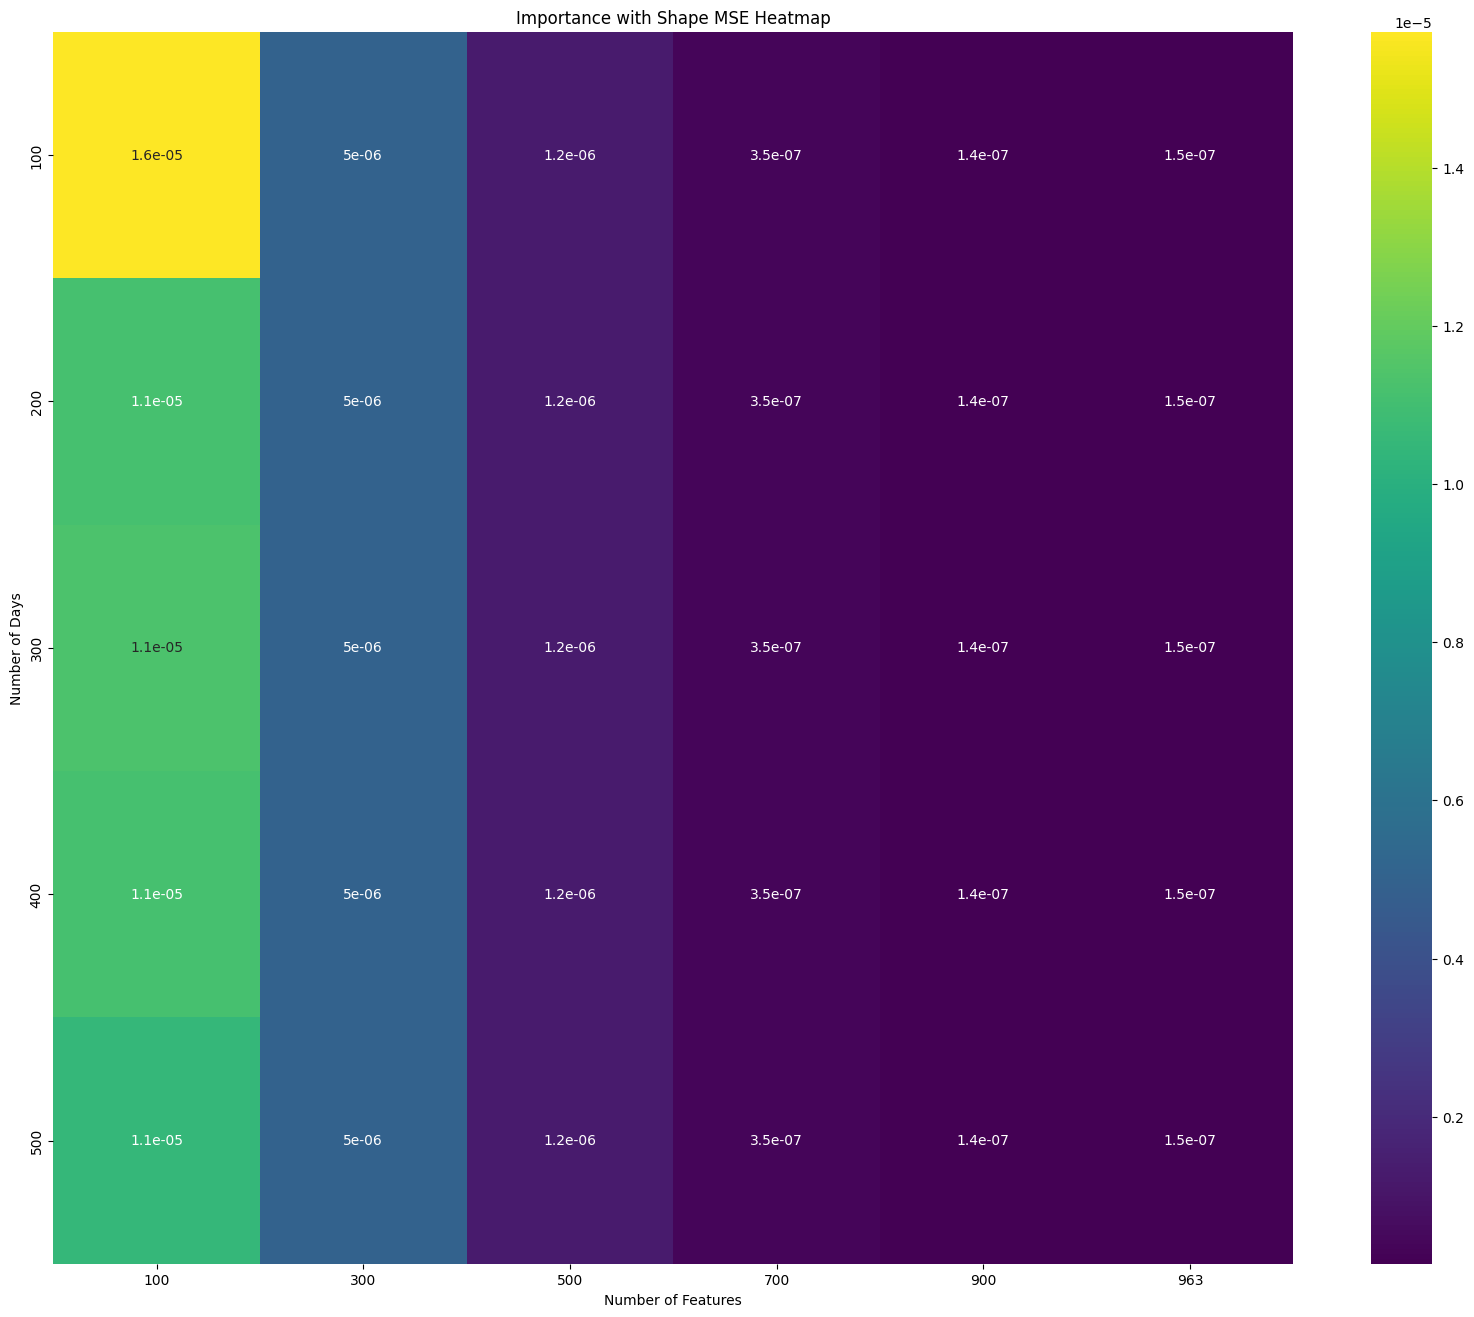

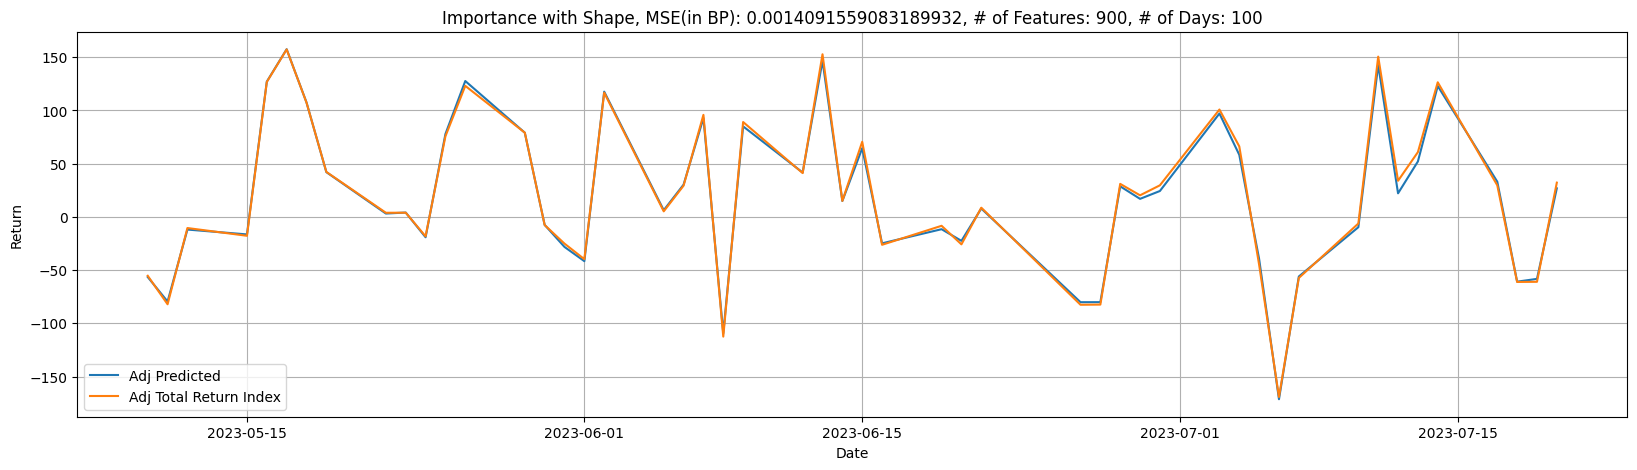

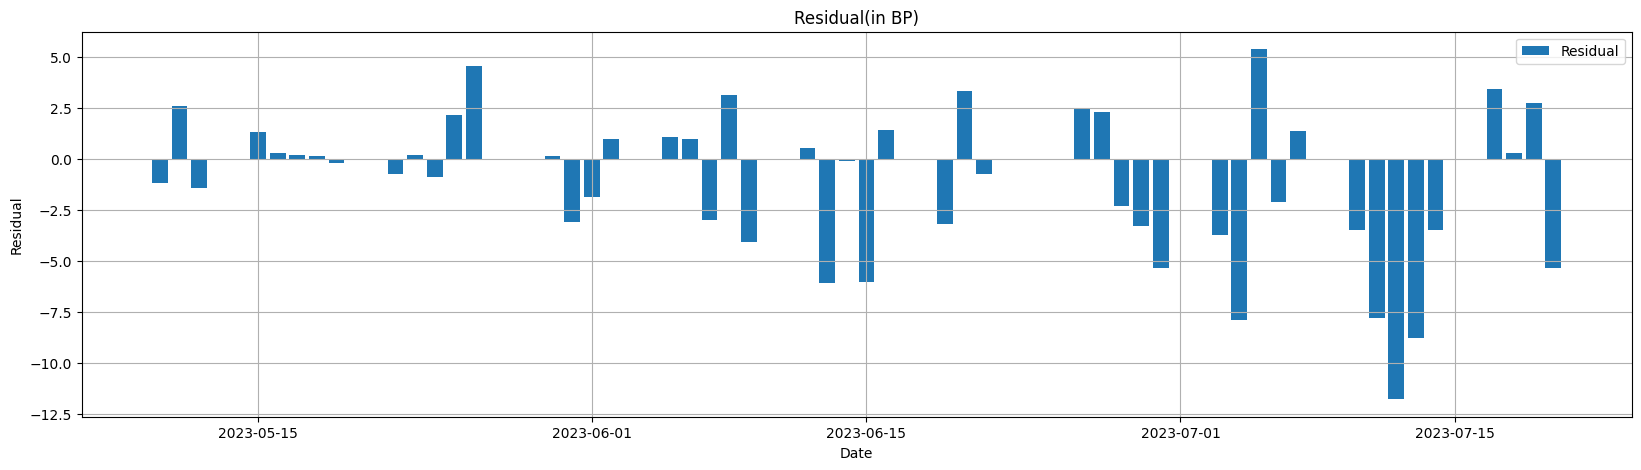

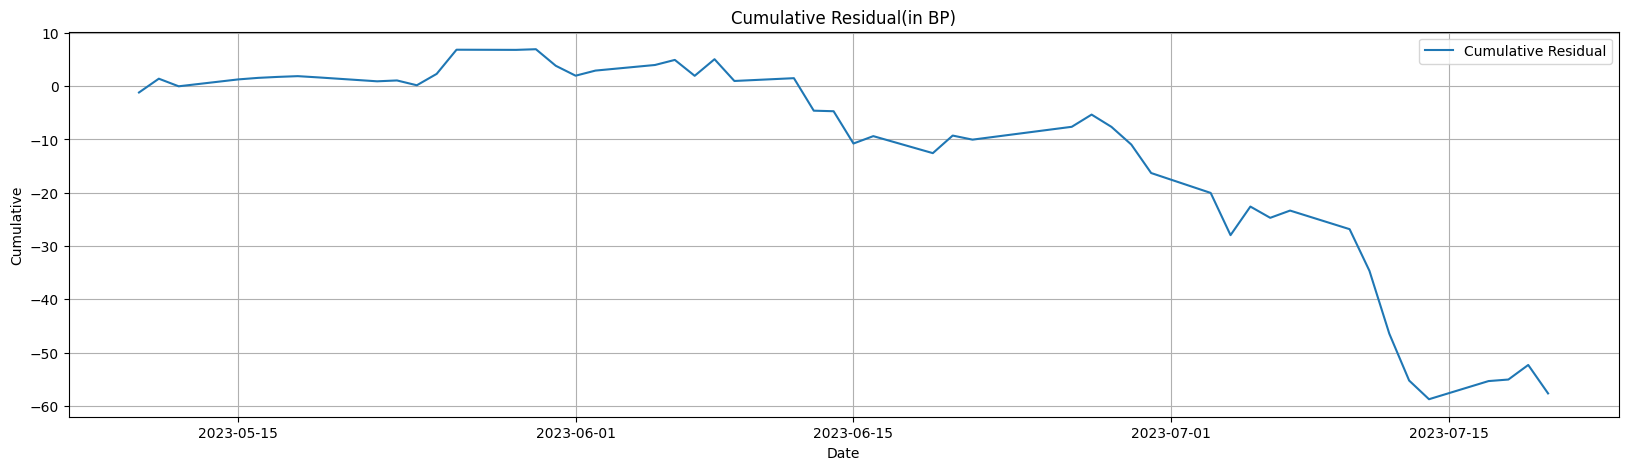

Weights
2330  0.276477
6695  0.000077
6213  0.000539
3356  0.000071
8104  0.000065
...        ...
1762  0.000157
9919  0.000075
1417  0.000058
4133  0.000046
4560  0.000057

[898 rows x 1 columns]

0.0011788673940612885


In [52]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].iloc[-1]

        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
            {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
        )

        bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]
    
        optmized_weights = Optimizer(X_train,y_train,initial_weights,
                                    constraints, bounds, 
                                    method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

        optimization = (optmized_weights * X_test).sum(axis = 1)
        # in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
        # in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

        # plt.figure(figsize=(20, 5))
        # plt.bar(y_train.index, np.array(in_sample_residual), label='Residual')
        # plt.legend()
        # plt.title(f'Residual(in BP)')
        # plt.xlabel('Date')
        # plt.ylabel('In-Sample Residual')
        # plt.grid()
        # plt.show()




        mse = mean_squared_error(y_test, optimization)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Importance with Shape MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].iloc[-1]

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0}, # sum of weights is 1
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + tested_return.dot(weights) - target}, # residuals are greater than -0.0005
    {'type': 'ineq', 'fun': lambda weights: 0.0005 + target - tested_return.dot(weights)} # residuals are less than 0.0005
)
bounds = [(0.0, 1.0) if weight > 0 else (0.0, 0.0) for weight in initial_weights]

optmized_weights = Optimizer(X_train,y_train,initial_weights,
                            constraints, bounds, 
                            method='CG', options={'maxiter': 100000000, 'ftol': 1e-8})

optimization = (optmized_weights * X_test).sum(axis = 1)

# in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test
# in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array((optmized_weights * X_train).sum(axis = 1)), label='Adj Predicted')
# plt.plot(y_train.index, 10000 * np.array(y_train) , label='Adj Total Return Index')
# plt.legend()
# plt.title(f'In-sample Linear Regression, MSE(in BP): {in_sample_mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
# plt.xlabel('Date')
# plt.ylabel('Return')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.bar(y_train.index, 10000 * np.array(in_sample_residual), label='Residual')
# plt.legend()
# plt.title(f'Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('In-Sample Residual')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array(in_sample_residual).cumsum(), label='Cumulative Residual')
# plt.legend()
# plt.title(f'In-Sample Cumulative Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('Cumulative')
# plt.grid()
# plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Importance with Shape, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(optmized_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))

## benchmark

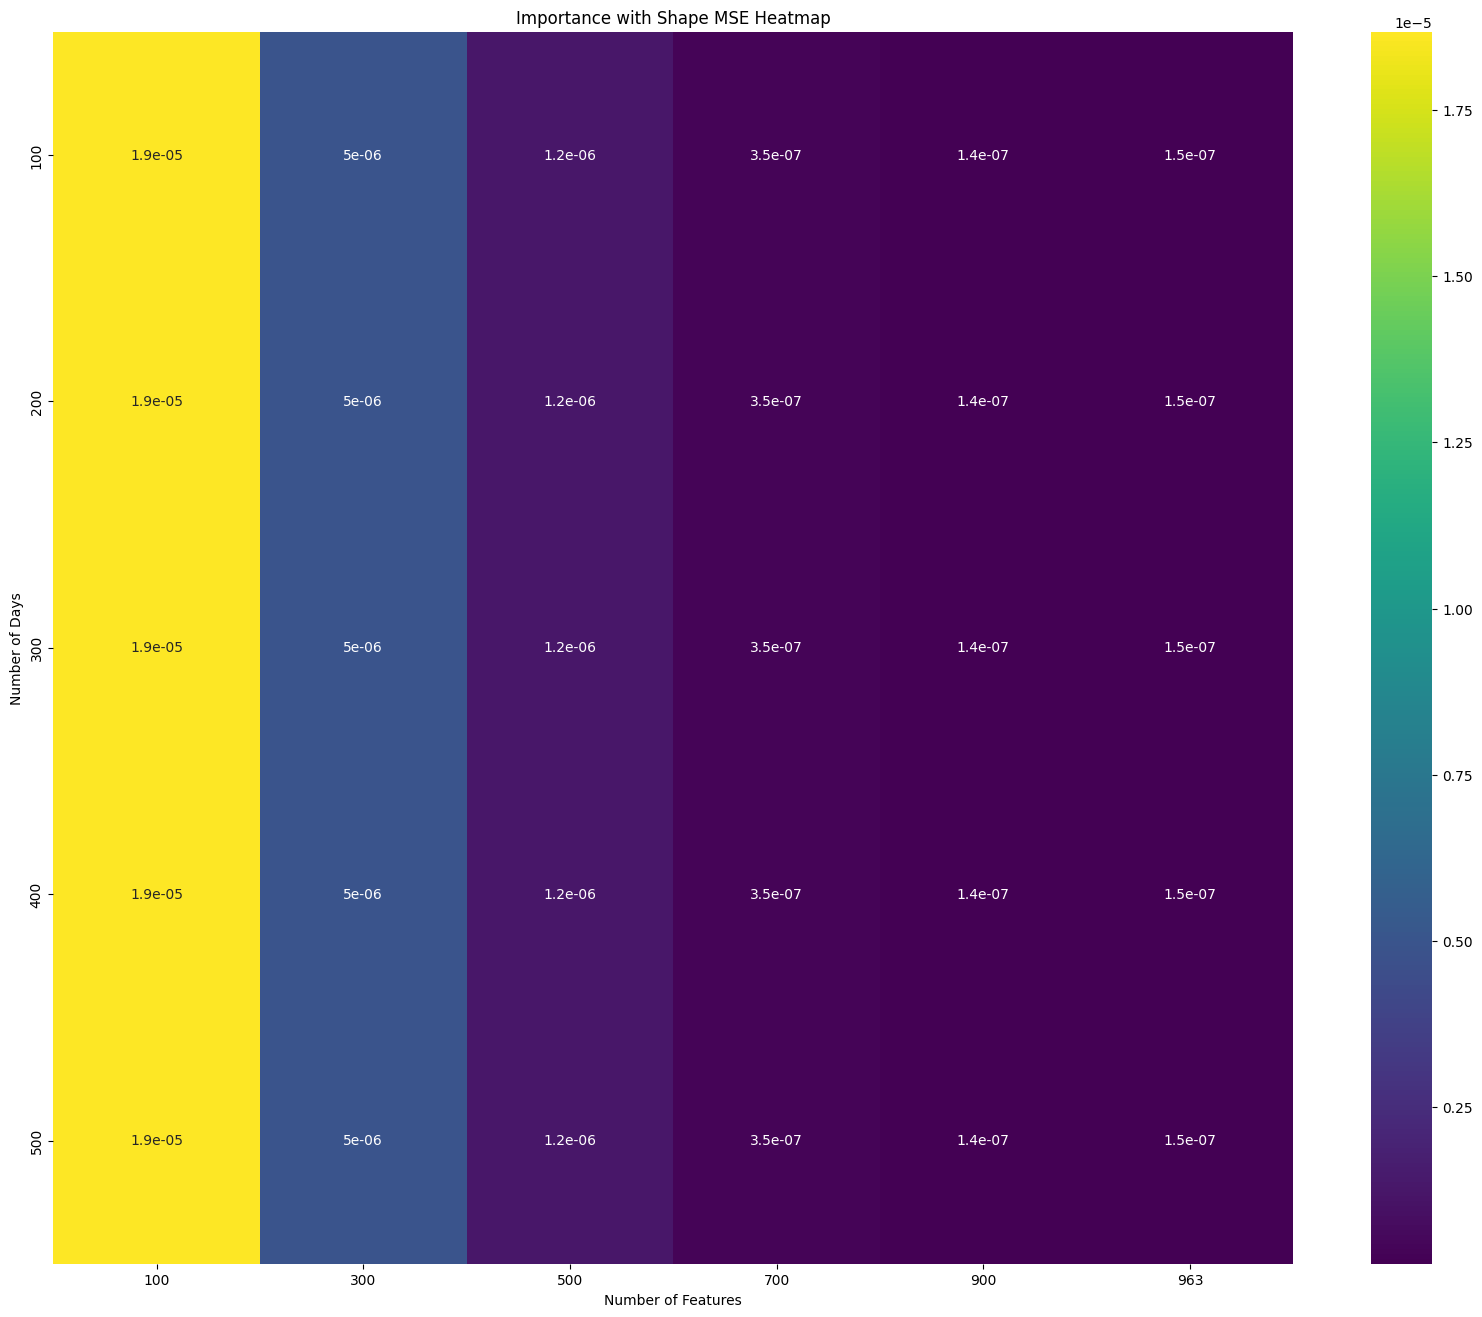

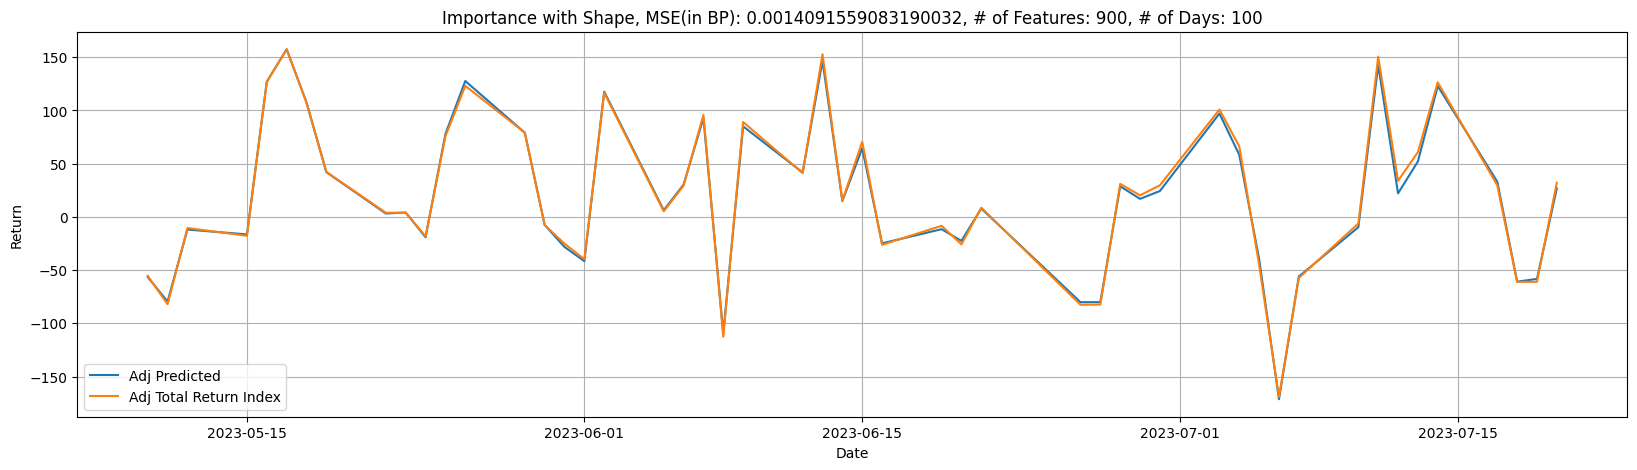

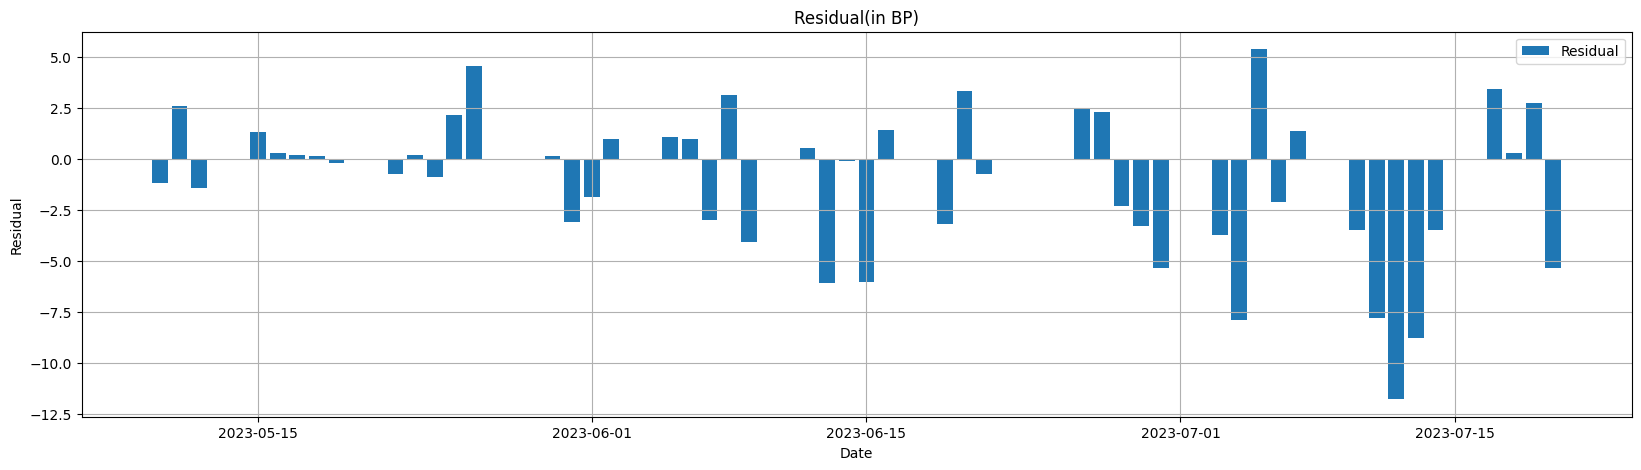

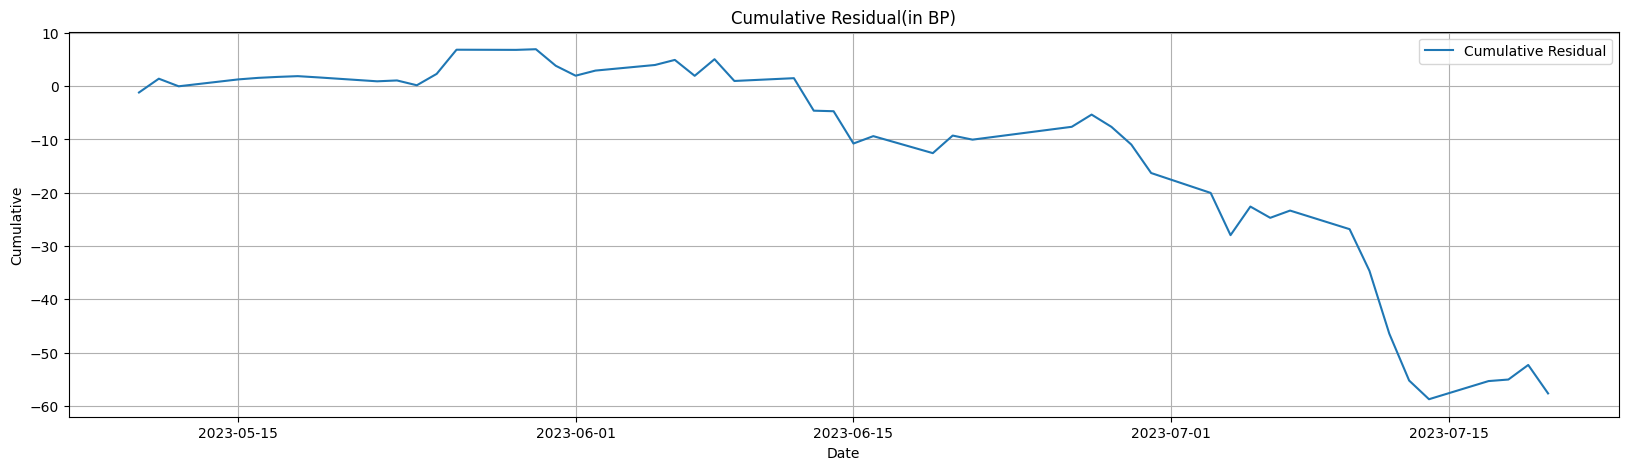

Weights
2330     NaN
6695     NaN
6213     NaN
3356     NaN
8104     NaN
...      ...
1762     NaN
9919     NaN
1417     NaN
4133     NaN
4560     NaN

[898 rows x 1 columns]

0.0011788673940612859


In [57]:
mse_df = pd.DataFrame(index = num_of_days, columns=num_of_features)
best_mse = np.inf
best_feature = ()


for num_of_feature in num_of_features:
    for num_of_day in num_of_days:
        need_days = num_of_day + testing_days +1

        num_of_elec = int(num_of_feature * 0.40)
        num_of_fin = int(num_of_feature * 0.04)
        num_of_nef = int(num_of_feature * 0.56)

        total_num = num_of_elec + num_of_fin + num_of_nef

        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

        bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
        good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


        count = 0
        while need_days > len(closing_px[good_stocks_id].dropna()): 
            count += 1

            E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
            F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
            NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

            closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
            weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

            bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
            good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

        final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


        E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
        F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
        NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

        closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
        weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
        weights = weights.div(weights.sum(axis=1), axis=0)[1:]

        returns = calculate_log_returns(closing_px)[1:]
        total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

        X_train = returns[:num_of_day]
        y_train = total_return_idx[:num_of_day]
        X_test = returns[num_of_day:]
        y_test = total_return_idx[num_of_day:]

        initial_weights = weights[:num_of_day].iloc[-1]
        initial_weights.fillna(0, inplace=True)

        optimization = (initial_weights * X_test).sum(axis = 1)
        # in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
        # in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

        # plt.figure(figsize=(20, 5))
        # plt.bar(y_train.index, np.array(in_sample_residual), label='Residual')
        # plt.legend()
        # plt.title(f'Residual(in BP)')
        # plt.xlabel('Date')
        # plt.ylabel('In-Sample Residual')
        # plt.grid()
        # plt.show()




        mse = mean_squared_error(y_test, optimization)

        if mse < best_mse:
            best_mse = mse
            best_feature = (num_of_day, num_of_feature)

        mse_df.loc[num_of_day, num_of_feature] = mse  # store mse in dataframe



mse_df = mse_df.astype(float)

plt.figure(figsize=(20, 16))
sns.heatmap(mse_df, annot=True, cmap='viridis')
plt.title(f"Importance with Shape MSE Heatmap")
plt.xlabel("Number of Features")
plt.ylabel("Number of Days")
plt.show()

num_of_day, num_of_feature = best_feature

need_days = num_of_day + testing_days +1

num_of_elec = int(num_of_feature * 0.40)
num_of_fin = int(num_of_feature * 0.04)
num_of_nef = int(num_of_feature * 0.56)

E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days:]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days:]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days:]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]


count = 0
while need_days > len(closing_px[good_stocks_id].dropna()): 
    count += 1

    E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].iloc[-need_days-count:]
    F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].iloc[-need_days-count:]
    NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].iloc[-need_days-count:]

    closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
    weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)

    bad_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].isnull()]
    good_stocks_id = (closing_px * weights).columns[(closing_px * weights).iloc[0].notnull()]

final_date = closing_px[good_stocks_id].dropna().index[-need_days:]


E_closing = TX_Closing[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_closing = TX_Closing[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_closing = TX_Closing[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

E_weights = TX_Weights[E_importance_df["Feature"].values[:num_of_elec]].loc[final_date]
F_weights = TX_Weights[F_importance_df["Feature"].values[:num_of_fin]].loc[final_date]
NEF_weights = TX_Weights[NEF_importance_df["Feature"].values[:num_of_nef]].loc[final_date]

closing_px = pd.concat([E_closing, F_closing, NEF_closing], axis=1)
weights = pd.concat([E_weights, F_weights, NEF_weights], axis=1)
weights = weights.div(weights.sum(axis=1), axis=0)[1:]
returns = calculate_log_returns(closing_px)[1:]
total_return_idx = (calculate_log_returns(TX_Closing.loc[final_date])[1:] * TX_Weights.loc[final_date][1:]).sum(axis = 1)

X_train = returns[:num_of_day]
y_train = total_return_idx[:num_of_day]
X_test = returns[num_of_day:]
y_test = total_return_idx[num_of_day:]

initial_weights = weights[:num_of_day].iloc[-1]
initial_weights.fillna(0, inplace=True)

optimization = (initial_weights * X_test).sum(axis = 1)

# in_sample_mse = mean_squared_error(y_train, (optmized_weights * X_train).sum(axis = 1))
mse = mean_squared_error(y_test, optimization)

residual = optimization - y_test
# in_sample_residual = (optmized_weights * X_train).sum(axis = 1) - y_train

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array((optmized_weights * X_train).sum(axis = 1)), label='Adj Predicted')
# plt.plot(y_train.index, 10000 * np.array(y_train) , label='Adj Total Return Index')
# plt.legend()
# plt.title(f'In-sample Linear Regression, MSE(in BP): {in_sample_mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
# plt.xlabel('Date')
# plt.ylabel('Return')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.bar(y_train.index, 10000 * np.array(in_sample_residual), label='Residual')
# plt.legend()
# plt.title(f'Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('In-Sample Residual')
# plt.grid()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.plot(y_train.index, 10000 * np.array(in_sample_residual).cumsum(), label='Cumulative Residual')
# plt.legend()
# plt.title(f'In-Sample Cumulative Residual(in BP)')
# plt.xlabel('Date')
# plt.ylabel('Cumulative')
# plt.grid()
# plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(optimization), label='Adj Predicted')
plt.plot(adj_y_test.index, 10000 * np.array(y_test) , label='Adj Total Return Index')
plt.legend()
plt.title(f'Importance with Shape, MSE(in BP): {mse * 10000}, # of Features: {num_of_feature}, # of Days: {num_of_day}')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(adj_y_test.index, 10000 * np.array(residual), label='Residual')
plt.legend()
plt.title(f'Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(adj_y_test.index, 10000 * np.array(residual).cumsum(), label='Cumulative Residual')
plt.legend()
plt.title(f'Cumulative Residual(in BP)')
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.grid()
plt.show()

coef_df = pd.DataFrame(initial_weights , index = X_train.columns, columns = ['Weights'])   
display(coef_df)
print(np.max(np.abs(residual)))